## This project is to analyze survey data collected from Student Conservation Assocation (SCA) participants to  better understand what contributes to a positive experience, and thus improve their programs
Matthew Terribile, September 2017

In [150]:
# Import libraries and set defaults
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import datetime
from datetime import timedelta
import time
import requests
import json
import statsmodels.api as sm 
import statsmodels.formula.api as sml
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

### INITIAL DATA LOAD OF 2 FILES FROM SCA

In [151]:
# Load member dataset, rename columns
# Omit some columns that aren't useful
mem_usecols = [1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
member = pd.read_csv('SCA Member and Position Data.csv',usecols=mem_usecols)

# short names of columns to make easier to work with
memcols = ['pos_id','op_id','mem_id','prog_type','pos_tit','org_mng','org','org_par',
           'loc_str','loc_city','loc_st','loc_zip','op_stat','job_title','start_dt',
           'end_dt','weeks','mem_city','mem_st','mem_zip','mem_school','vet',
           'ethnicity','ethnicity_code', 'educ_lev','age','gender']
member.columns=memcols

In [152]:
member.shape


(7923, 27)

In [153]:
# Load survey dataset, omit some columns
sur_usecols = [2,8,9,10,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,
              31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,
              57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,
              81,82,83,84,85,86,87,88]
survey = pd.read_csv('SCA Member Post-Survey Data.csv',usecols=sur_usecols)

# Shorten names of columns to make easier to work with
surcols = ['time_stamp','mem_id','op_id','pos_id','prog_type','americorps','budget_cd','loc_st',
           'start_dt','end_dt','q18','q19','q20','q22','q24','q26a','q26b','q26c','q26d',
           'q35','q36','q48a','q48b','q48c','q48d','q48e','q48f','q49','q50','q76',
           'q85a','q85b','q85c','q85d','q85e','q85f','q86','q88a','q88b','q88c',
           'q93a','q93b','q93c','q93d','q93e','q94a','q94b','q94c','q95a','q95b','q95c','q95d',
           'q96a','q96b','q96c','q96d','q96e','q96f','q96g','q96h',
           'q97a','q97b','q97c','q97d','q97e','q97f',
           'q98a','q98b','q98c','q98d','q98e','q98f','q98g','q98h',
           'q99a','q99b','q99c','q100','recommend']
survey.columns=surcols

In [154]:
survey.shape

(4812, 79)

In [155]:
survey.head(2)

time_stamp           mem_id            op_id           pos_id  \
0  6/25/15 20:03  0034000001VPTIM  a0r40000007cgbt  a0s4000000ROeFX   
1  6/25/15 19:57  0034000001VPTIM  a0r40000007cgbt  a0s4000000ROeFX   

   prog_type americorps budget_cd loc_st start_dt   end_dt  q18  q19  q20  \
0  Community         No       267     IL  3/10/15  5/30/15  NaN  NaN  NaN   
1  Community         No       267     IL  3/10/15  5/30/15  NaN  NaN  NaN   

   q22  q24  q26a  q26b  q26c  q26d  q35  q36  q48a  q48b  q48c  q48d  q48e  \
0  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
1  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   

   q48f  q49  q50  q76  q85a  q85b  q85c  q85d  q85e  q85f  q86  q88a  q88b  \
0   NaN  NaN  NaN  4.0   4.0   4.0   4.0   4.0   4.0   4.0  4.0   4.0   4.0   
1   NaN  NaN  NaN  4.0   4.0   4.0   4.0   4.0   4.0   4.0  4.0   5.0   5.0   

   q88c  q93a  q93b  q93c  q93d  q93e  q94a  q94b  q94c  q95a  q95b  q95c  \
0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   
1   5.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   

   q95d  q96a  q96b  q96c  q96d  q96e  q96f  q96g q96h  q97a  q97b  q97c  \
0   4.0   NaN   NaN   1.0   NaN   NaN   NaN   NaN  NaN   4.0   4.0   4.0   
1   4.0   NaN   NaN   1.0   NaN   NaN   NaN   NaN  NaN   4.0   4.0   4.0   

   q97d  q97e  q97f  q98a  q98b  q98c  q98d  q98e  q98f  q98g  q98h  q99a  \
0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   
1   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   

   q99b  q99c  q100  recommend  
0   4.0   4.0   1.0        8.0  
1   4.0   4.0   1.0        NaN

### INITIAL DATA CLEANUP PRIOR TO MERGING TWO FILES

In [156]:
# Look for 100% duplicates in each file 
print survey.duplicated().sum()
print member.duplicated().sum()

0
0


In [157]:
# Check time stamp for null values and change to date_time
print survey['time_stamp'].isnull().sum()
survey.time_stamp=pd.to_datetime(survey.time_stamp) 

0


In [158]:
# Some issues below with nulls and bad date format in 4th to last rows that will need to fix
survey.tail(5)

time_stamp           mem_id            op_id           pos_id  \
4807 2017-08-04 19:34:00  0033300001kJ5Ym  a0rf300000BBJ3R  a0sf300000r2h6Q   
4808 2015-09-25 11:50:00  0033300001eouRC  a0r330000080VTk  a0s3300000Xnvjn   
4809 2015-09-02 16:30:00              NaN              NaN              NaN   
4810 2015-09-01 21:06:00              NaN              NaN              NaN   
4811 2015-09-01 21:06:00              NaN              NaN              NaN   

      prog_type americorps budget_cd loc_st start_dt    end_dt  q18  q19  q20  \
4807  Community         No       255     DC   7/3/17   8/11/17  NaN  NaN  NaN   
4808  Community         No       253     CA   7/6/15  2015-08-  NaN  NaN  NaN   
4809  Community        NaN  312q9=NH    NaN      NaN       NaN  NaN  NaN  NaN   
4810  Community        NaN  312q9=NH    NaN      NaN       NaN  NaN  NaN  NaN   
4811  Community        NaN  312q9=NH    NaN      NaN       NaN  NaN  NaN  NaN   

      q22  q24  q26a  q26b  q26c  q26d  q35  q36  q48a  q48b  q48c  q48d  \
4807  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4808  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4809  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4810  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4811  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   

      q48e  q48f  q49  q50  q76  q85a  q85b  q85c  q85d  q85e  q85f  q86  \
4807   NaN   NaN  NaN  NaN  5.0   5.0   5.0   4.0   5.0   5.0   5.0  NaN   
4808   NaN   NaN  NaN  NaN  3.0   4.0   5.0   5.0   5.0   5.0   5.0  5.0   
4809   NaN   NaN  NaN  NaN  3.0   3.0   4.0   4.0   4.0   3.0   3.0  4.0   
4810   NaN   NaN  NaN  NaN  4.0   4.0   4.0   3.0   4.0   4.0   4.0  4.0   
4811   NaN   NaN  NaN  NaN  4.0   5.0   5.0   4.0   5.0   4.0   5.0  4.0   

      q88a  q88b  q88c  q93a  q93b  q93c  q93d  q93e  q94a  q94b  q94c  q95a  \
4807   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   4.0   
4808   3.0   4.0   4.0   4.0   5.0   5.0   4.0   4.0   3.0   4.0   5.0   5.0   
4809   4.0   3.0   4.0   3.0   4.0   3.0   3.0   4.0   4.0   3.0   3.0   4.0   
4810   3.0   4.0   4.0   4.0   3.0   4.0   4.0   4.0   3.0   3.0   3.0   1.0   
4811   5.0   5.0   4.0   5.0   5.0   5.0   5.0   5.0   4.0   5.0   4.0   4.0   

      q95b  q95c  q95d  q96a  q96b  q96c  q96d  q96e  q96f  q96g q96h  q97a  \
4807   5.0   4.0   5.0   NaN   NaN   NaN   NaN   1.0   NaN   NaN  NaN   5.0   
4808   5.0   4.0   4.0   NaN   NaN   NaN   NaN   1.0   NaN   NaN  NaN   3.0   
4809   4.0   3.0   4.0   NaN   NaN   NaN   NaN   1.0   NaN   NaN  NaN   4.0   
4810   3.0   3.0   3.0   NaN   NaN   1.0   NaN   NaN   NaN   NaN  NaN   4.0   
4811   4.0   4.0   5.0   NaN   NaN   1.0   NaN   NaN   NaN   NaN  NaN   5.0   

      q97b  q97c  q97d  q97e  q97f  q98a  q98b  q98c  q98d  q98e  q98f  q98g  \
4807   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   4.0   5.0   5.0   4.0   
4808   4.0   4.0   4.0   5.0   5.0   5.0   4.0   4.0   4.0   5.0   NaN   5.0   
4809   3.0   3.0   3.0   4.0   3.0   4.0   3.0   3.0   3.0   4.0   4.0   3.0   
4810   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   
4811   4.0   5.0   4.0   5.0   5.0   4.0   5.0   5.0   5.0   5.0   4.0   4.0   

      q98h  q99a  q99b  q99c  q100  recommend  
4807   5.0   3.0   4.0   4.0   1.0       10.0  
4808   5.0   5.0   4.0   5.0   4.0        NaN  
4809   3.0   3.0   4.0   4.0   1.0        8.0  
4810   4.0   4.0   4.0   4.0   1.0       10.0  
4811   4.0   5.0   4.0   4.0   1.0        9.0

In [159]:
# Check for nulls in op_id column that will be merging on
print survey['op_id'].isnull().sum()
print member['op_id'].isnull().sum()

3
0


In [160]:
# Will eliminate last 3 rows in survey file with null member_id, op_id, and pos_id
# No good way to recreate the data and the loss of 3 rows of 4800 won't significantly impact analysis
print survey.shape
survey.dropna(axis=0, subset=['op_id'], inplace=True)
print survey.shape
survey.tail(4)

(4812, 79)
(4809, 79)


time_stamp           mem_id            op_id           pos_id  \
4805 2017-08-04 21:01:00  0034000001IDkIf  a0rf300000BBJ4J  a0s3300000r2SHT   
4806 2017-08-04 20:47:00  0033300001u5KxC  a0rf300000BBJ4T  a0s3300000r2JK2   
4807 2017-08-04 19:34:00  0033300001kJ5Ym  a0rf300000BBJ3R  a0sf300000r2h6Q   
4808 2015-09-25 11:50:00  0033300001eouRC  a0r330000080VTk  a0s3300000Xnvjn   

      prog_type americorps budget_cd loc_st start_dt    end_dt  q18  q19  q20  \
4805  Community         No       255     MD   7/3/17   8/11/17  NaN  NaN  NaN   
4806  Community         No       255     DC   7/3/17   8/11/17  NaN  NaN  NaN   
4807  Community         No       255     DC   7/3/17   8/11/17  NaN  NaN  NaN   
4808  Community         No       253     CA   7/6/15  2015-08-  NaN  NaN  NaN   

      q22  q24  q26a  q26b  q26c  q26d  q35  q36  q48a  q48b  q48c  q48d  \
4805  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4806  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4807  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4808  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   

      q48e  q48f  q49  q50  q76  q85a  q85b  q85c  q85d  q85e  q85f  q86  \
4805   NaN   NaN  NaN  NaN  5.0   3.0   5.0   3.0   5.0   3.0   4.0  3.0   
4806   NaN   NaN  NaN  NaN  5.0   5.0   4.0   3.0   4.0   3.0   4.0  4.0   
4807   NaN   NaN  NaN  NaN  5.0   5.0   5.0   4.0   5.0   5.0   5.0  NaN   
4808   NaN   NaN  NaN  NaN  3.0   4.0   5.0   5.0   5.0   5.0   5.0  5.0   

      q88a  q88b  q88c  q93a  q93b  q93c  q93d  q93e  q94a  q94b  q94c  q95a  \
4805   4.0   4.0   3.0   4.0   4.0   5.0   5.0   5.0   2.0   2.0   3.0   5.0   
4806   4.0   3.0   2.0   3.0   4.0   5.0   4.0   4.0   5.0   5.0   5.0   5.0   
4807   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   4.0   
4808   3.0   4.0   4.0   4.0   5.0   5.0   4.0   4.0   3.0   4.0   5.0   5.0   

      q95b  q95c  q95d  q96a  q96b  q96c  q96d  q96e  q96f  q96g  \
4805   4.0   4.0   4.0   NaN   NaN   NaN   NaN   NaN   NaN   1.0   
4806   5.0   5.0   5.0   NaN   NaN   NaN   NaN   1.0   NaN   NaN   
4807   5.0   4.0   5.0   NaN   NaN   NaN   NaN   1.0   NaN   NaN   
4808   5.0   4.0   4.0   NaN   NaN   NaN   NaN   1.0   NaN   NaN   

                 q96h  q97a  q97b  q97c  q97d  q97e  q97f  q98a  q98b  q98c  \
4805  Take a gap year   5.0   3.0   5.0   5.0   3.0   5.0   4.0   5.0   3.0   
4806              NaN   3.0   4.0   4.0   4.0   4.0   4.0   3.0   3.0   4.0   
4807              NaN   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
4808              NaN   3.0   4.0   4.0   4.0   5.0   5.0   5.0   4.0   4.0   

      q98d  q98e  q98f  q98g  q98h  q99a  q99b  q99c  q100  recommend  
4805   5.0   5.0   2.0   5.0   4.0   5.0   5.0   4.0   3.0       10.0  
4806   4.0   5.0   5.0   4.0   5.0   5.0   5.0   5.0   2.0        8.0  
4807   4.0   5.0   5.0   4.0   5.0   3.0   4.0   4.0   1.0       10.0  
4808   4.0   5.0   NaN   5.0   5.0   5.0   4.0   5.0   4.0        NaN

In [161]:
# Look for duplicate opening ids in each file
print survey.op_id.duplicated().sum()
print member.op_id.duplicated().sum()


46
0


In [162]:
# It appears that duplicate survey responses were submitted.   
# Keep the one with the latest time stamp for each opening id

# Sort rows by time_stamps with latest to the end
print survey.shape
survey.sort_values('time_stamp', axis=0, ascending=True, inplace=True)

# Drop duplicates keeping last (latest time stamp)
survey.drop_duplicates(subset=['op_id'], keep='last', inplace=True)
print survey.shape

(4809, 79)
(4763, 79)


### MERGE PRIMARY DATA FILES AND DO DATA CLEANUP ON MERGED FILE

In [163]:
# Merge two files based on opening IDs
sur = pd.merge(survey, member, left_on='op_id', right_on='op_id',
      how='left', sort=False)
print sur.shape
sur.head(4)

(4763, 105)


time_stamp         mem_id_x            op_id         pos_id_x  \
0 2015-06-09 01:11:00  0034000001Oq11u  a0r40000007cPLS  a0s4000000RMW4e   
1 2015-06-10 18:03:00  0034000000zq5gR  a0r40000004pvX5  a0s4000000RMW4j   
2 2015-06-10 18:05:00  0034000001N0R1W  a0r40000004qEVo  a0s4000000RMW4e   
3 2015-06-11 16:47:00  0034000000wNZAS  a0r40000004pvWv  a0s4000000RMW4j   

  prog_type_x americorps budget_cd loc_st_x start_dt_x end_dt_x  q18  q19  \
0   Community         No       252       WA    12/3/14   6/6/15  NaN  NaN   
1   Community         No       252       WA   10/15/14   6/6/15  NaN  NaN   
2   Community         No       252       WA    12/3/14   6/6/15  NaN  NaN   
3   Community         No       252       WA   10/15/14   6/6/15  NaN  NaN   

   q20  q22  q24  q26a  q26b  q26c  q26d  q35  q36  q48a  q48b  q48c  q48d  \
0  NaN  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
1  NaN  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
2  NaN  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
3  NaN  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   

   q48e  q48f  q49  q50  q76  q85a  q85b  q85c  q85d  q85e  q85f  q86  q88a  \
0   NaN   NaN  NaN  NaN  4.0   3.0   5.0   5.0   5.0   4.0   5.0  3.0   5.0   
1   NaN   NaN  NaN  NaN  5.0   5.0   5.0   5.0   5.0   5.0   5.0  5.0   5.0   
2   NaN   NaN  NaN  NaN  4.0   4.0   4.0   3.0   4.0   4.0   4.0  4.0   4.0   
3   NaN   NaN  NaN  NaN  4.0   5.0   5.0   5.0   5.0   5.0   5.0  5.0   5.0   

   q88b  q88c  q93a  q93b  q93c  q93d  q93e  q94a  q94b  q94c  q95a  q95b  \
0   5.0   5.0   5.0   3.0   4.0   5.0   NaN   5.0   2.0   2.0   4.0   5.0   
1   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
2   5.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   
3   5.0   4.0   5.0   5.0   4.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   

   q95c  q95d  q96a  q96b  q96c  q96d  q96e  q96f  q96g q96h  q97a  q97b  \
0   5.0   5.0   NaN   NaN   NaN   NaN   1.0   NaN   NaN  NaN   5.0   5.0   
1   5.0   5.0   NaN   NaN   1.0   NaN   NaN   NaN   NaN  NaN   5.0   5.0   
2   3.0   4.0   NaN   NaN   NaN   NaN   1.0   NaN   NaN  NaN   4.0   4.0   
3   5.0   5.0   NaN   NaN   NaN   NaN   1.0   NaN   NaN  NaN   4.0   5.0   

   q97c  q97d  q97e  q97f  q98a  q98b  q98c  q98d  q98e  q98f  q98g  q98h  \
0   5.0   5.0   5.0   3.0   5.0   5.0   5.0   5.0   4.0   5.0   5.0   5.0   
1   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
2   4.0   4.0   4.0   3.0   4.0   4.0   4.0   4.0   4.0   4.0   3.0   4.0   
3   5.0   5.0   4.0   4.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   

   q99a  q99b  q99c  q100  recommend         pos_id_y         mem_id_y  \
0   5.0   5.0   5.0   1.0       10.0  a0s4000000RMW4e  0034000001Oq11u   
1   5.0   5.0   5.0   1.0       10.0  a0s4000000RMW4j  0034000000zq5gR   
2   4.0   4.0   5.0   1.0        9.0  a0s4000000RMW4e  0034000001N0R1W   
3   5.0   5.0   5.0   1.0       10.0  a0s4000000RMW4j  0034000000wNZAS   

  prog_type_y                                         pos_tit  \
0   Community      Salix- Seattle School Year 2014-15, Crew 3   
1   Community  Seattle School Year 2014-15, Old Faithful Crew   
2   Community      Salix- Seattle School Year 2014-15, Crew 3   
3   Community  Seattle School Year 2014-15, Old Faithful Crew   

                            org_mng  org org_par             loc_str loc_city  \
0  Student Conservation Association  NaN     NaN     1265 S. Main St  Seattle   
1  Student Conservation Association  NaN     NaN  1265 s main street  seattle   
2  Student Conservation Association  NaN     NaN     1265 S. Main St  Seattle   
3  Student Conservation Association  NaN     NaN  1265 s main street  seattle   

  loc_st_y loc_zip           op_stat    job_title start_dt_y end_dt_y  weeks  \
0       WA   98144  Out of the Field          NaN    12/3/14   6/6/15   27.0   
1       WA   98144  Out of the Field  Cre

In [164]:
# Check if other columns besides op_id that existed in both data frames (_x and _y) 
# before merge are equivalent (mem_id, pos_id, prog_type, loc_st, start_dt, end_dt)

In [165]:
# Check for nulls before and after merge in a few fields - position id
print survey['pos_id'].isnull().sum()
print member['pos_id'].isnull().sum()
print sur['pos_id_x'].isnull().sum()
print sur['pos_id_y'].isnull().sum()
# may have been some surveys without member data?

0
0
0
104


In [166]:
# Check for nulls before and after merge in a few fields - member id
print survey['mem_id'].isnull().sum()
print member['mem_id'].isnull().sum()
print sur['mem_id_x'].isnull().sum()
print sur['mem_id_y'].isnull().sum()
# similar to above

0
0
0
104


In [167]:
# Check for nulls before and after merge in a few fields - start date
print survey['start_dt'].isnull().sum()
print member['start_dt'].isnull().sum()
print sur['start_dt_x'].isnull().sum()
print sur['start_dt_y'].isnull().sum()
# similar to above

0
0
0
104


In [168]:
# Check for nulls before and after merge in a few fields - end date
print survey['end_dt'].isnull().sum()
print member['end_dt'].isnull().sum()
print sur['end_dt_x'].isnull().sum()
print sur['end_dt_y'].isnull().sum()
# similar to above

0
0
0
104


In [169]:
# Check for nulls before and after merge in a few fields - location state
print survey['loc_st'].isnull().sum()
print member['loc_st'].isnull().sum()
print sur['loc_st_x'].isnull().sum()
print sur['loc_st_y'].isnull().sum()
# bit different - need to watch this one.

41
5
41
108


In [170]:
# Look for non equivalence
# Omit the cases where _y is null since 104 opening IDs with surveys don't exist in the member file
print 'Member ID non equivalent: '+ str(sur[(sur.mem_id_x != sur.mem_id_y)&pd.notnull(sur.mem_id_y)].op_id.count())
print 'Position ID non equivalent: '+ str(sur[(sur.pos_id_x != sur.pos_id_y)&pd.notnull(sur.pos_id_y)].op_id.count())
print 'Program type non equivalent: '+ str(sur[(sur.prog_type_x != sur.prog_type_y)&pd.notnull(sur.prog_type_y)].op_id.count())
print 'Location state non equivalent: '+ str(sur[(sur.loc_st_x != sur.loc_st_y)&pd.notnull(sur.loc_st_y)].op_id.count())
print 'Start date non equivalent: '+ str(sur[(sur.start_dt_x != sur.start_dt_y)&pd.notnull(sur.start_dt_y)].op_id.count())
print 'End date non equivalent: '+ str(sur[(sur.end_dt_x != sur.end_dt_y)&pd.notnull(sur.end_dt_y)].op_id.count())

Member ID non equivalent: 12
Position ID non equivalent: 2
Program type non equivalent: 23
Location state non equivalent: 36
Start date non equivalent: 12
End date non equivalent: 134


In [171]:
# Look at same, but instead omit the cases where _x (survey file) is null 
print 'Member ID non equivalent: '+ str(sur[(sur.mem_id_x != sur.mem_id_y)&pd.notnull(sur.mem_id_x)].op_id.count())
print 'Position ID non equivalent: '+ str(sur[(sur.pos_id_x != sur.pos_id_y)&pd.notnull(sur.pos_id_x)].op_id.count())
print 'Program type non equivalent: '+ str(sur[(sur.prog_type_x != sur.prog_type_y)&pd.notnull(sur.prog_type_x)].op_id.count())
print 'Location state non equivalent: '+ str(sur[(sur.loc_st_x != sur.loc_st_y)&pd.notnull(sur.loc_st_x)].op_id.count())
print 'Start date non equivalent: '+ str(sur[(sur.start_dt_x != sur.start_dt_y)&pd.notnull(sur.start_dt_x)].op_id.count())
print 'End date non equivalent: '+ str(sur[(sur.end_dt_x != sur.end_dt_y)&pd.notnull(sur.end_dt_x)].op_id.count())
# these are 104 more than the previous numbers, except for location state

Member ID non equivalent: 116
Position ID non equivalent: 106
Program type non equivalent: 127
Location state non equivalent: 103
Start date non equivalent: 116
End date non equivalent: 238


In [172]:
# In general, believe that member file is more accurate.    Will use that data (_y) except where it is null

# Fill null values of _y (member) with _x (survey)
previous_null= sur['mem_id_y'].isnull().sum()
sur.mem_id_y.fillna(sur.mem_id_x,inplace=True)
print 'Member ID null values= '+str(sur['mem_id_y'].isnull().sum())+', down from '+str(previous_null)

previous_null=  sur['pos_id_y'].isnull().sum()
sur.pos_id_y.fillna(sur.pos_id_x,inplace=True)
print 'Position ID null values= '+str(sur['pos_id_y'].isnull().sum())+', down from '+str(previous_null)

previous_null= sur['prog_type_y'].isnull().sum()
sur.prog_type_y.fillna(sur.prog_type_x,inplace=True)
print 'Program type null values= '+str(sur['prog_type_y'].isnull().sum())+', down from '+str(previous_null)

previous_null= sur['loc_st_y'].isnull().sum()
sur.loc_st_y.fillna(sur.loc_st_x,inplace=True)
print 'Location state null values= '+str(sur['loc_st_y'].isnull().sum())+', down from '+str(previous_null)

previous_null=  sur['start_dt_y'].isnull().sum()
sur.start_dt_y.fillna(sur.start_dt_x,inplace=True)
print 'Start date null values= '+str(sur['start_dt_y'].isnull().sum())+', down from '+str(previous_null)

previous_null=  sur['end_dt_y'].isnull().sum()
sur.end_dt_y.fillna(sur.end_dt_x,inplace=True)
print 'End date null values= '+str(sur['end_dt_y'].isnull().sum())+', down from '+str(previous_null)

# Only 5 nulls in location state remain.


Member ID null values= 0, down from 104
Position ID null values= 0, down from 104
Program type null values= 0, down from 104
Location state null values= 5, down from 108
Start date null values= 0, down from 104
End date null values= 0, down from 104


In [173]:
# Move the values of the _y variables 
sur['mem_id']= sur['mem_id_y']
sur['pos_id']= sur['pos_id_y']
sur['prog_type']= sur['prog_type_y']
sur['loc_st']= sur['loc_st_y']
sur['start_dt']= sur['start_dt_y']
sur['end_dt']= sur['end_dt_y']

# remove the_y and _x variables
sur.drop(['mem_id_y','pos_id_y','prog_type_y','loc_st_y','start_dt_y','end_dt_y',
          'mem_id_x','pos_id_x','prog_type_x','loc_st_x','start_dt_x','end_dt_x'],axis=1,inplace=True)

### EXAMINE NULL VALUES AND REMOVE ENTRIES THAT ARE PREDOMINATELY NULLS

In [174]:
# the variable 'recommend' that we are predicting is not present in 79 surveys.   
# before deleting, see whether they are across program types
sur.groupby('prog_type').recommend.value_counts(dropna=False)

prog_type    recommend
Community    10.0          530
             8.0           224
             9.0           212
             7.0            92
             5.0            56
             6.0            44
             NaN            42
             4.0            14
             1.0             6
             3.0             6
             2.0             5
Corps        10.0          212
             8.0           104
             9.0            80
             7.0            44
             5.0            15
             6.0            15
             3.0             9
             1.0             7
             2.0             7
             4.0             6
             NaN             3
Crew         10.0          269
             9.0            77
             8.0            55
             7.0            20
             5.0             6
             6.0             5
             NaN             2
             4.0             2
             2.0             1
             3.0

In [175]:
# Since null 'recommend' fields are across program types, and there aren't that many relative
# to any one program type (except perhaps 'other' which is small) will drop rows with null 'recommend'
sur.dropna(axis=0, subset=['recommend'], inplace=True)

## May want to come back later and see how they answered other questions
## when didn't answer recommend

In [176]:
# other notable missing data
# the surveys (104) without member data all have missing demographic fields - will hamper some
#      analysis if keep.   Need to see what they are
sur.groupby('prog_type').gender.value_counts(dropna=False)

prog_type    gender                
Community    Male                       594
             Female                     552
             NaN                         38
             Choose not to Identify       5
Corps        Female                     258
             Male                       235
             NaN                          3
             Choose not to Identify       3
Crew         Female                     228
             Male                       199
             Choose not to Identify       5
             NaN                          4
Internships  Female                    1576
             Male                       879
             NaN                         40
             Choose not to Identify      18
Leader Crew  Male                        12
             Female                      11
Other        NaN                         24
Name: gender, dtype: int64

In [177]:
# remove the records without demographics won't have major impact, except eliminating the 'other' category
# which was small and problematic anyway
# take a quick look at 'other' before remove
sur[(sur.prog_type=='Other')]

time_stamp            op_id americorps budget_cd  q18  q19  q20  \
7    2015-06-14 19:27:00  a0r330000080Flh         No       215  NaN  NaN  NaN   
9    2015-06-18 20:49:00  a0r330000080FtR         No       215  NaN  NaN  NaN   
11   2015-06-22 01:08:00  a0r330000080EeW         No       215  NaN  NaN  NaN   
14   2015-06-23 05:03:00  a0r330000080H4f         No       215  NaN  NaN  NaN   
20   2015-06-25 00:08:00  a0r330000080IIa         No       215  NaN  NaN  NaN   
21   2015-06-25 15:08:00  a0r330000080Eel         No       215  NaN  NaN  NaN   
24   2015-06-26 17:44:00  a0r330000080H0C         No       215  NaN  NaN  NaN   
25   2015-06-26 18:22:00  a0r40000006barL         No       210  NaN  NaN  NaN   
28   2015-06-27 16:04:00  a0r330000080EiD         No       215  NaN  NaN  NaN   
40   2015-06-29 22:40:00  a0r330000080Gzi         No       215  NaN  NaN  NaN   
1962 2016-04-20 19:34:00  a0r33000008IEaT         No       525  NaN  NaN  NaN   
2146 2016-05-27 10:09:00  a0r3300000AP7Oy         No       525  NaN  NaN  NaN   
2214 2016-06-13 06:40:00  a0r3300000Arrsi         No       215  NaN  NaN  NaN   
2240 2016-06-23 04:15:00  a0r3300000AP6Mb         No       215  NaN  NaN  NaN   
2247 2016-06-27 04:08:00  a0r3300000AOpiu         No       215  NaN  NaN  NaN   
2249 2016-06-27 23:49:00  a0r3300000APF3Z         No       215  NaN  NaN  NaN   
2252 2016-06-28 22:42:00  a0r3300000APF3F         No       215  NaN  NaN  NaN   
2275 2016-07-06 18:55:00  a0r3300000Ars80         No       215  NaN  NaN  NaN   
2314 2016-07-20 01:44:00  a0r3300000AP4IU         No       215  NaN  NaN  NaN   
4516 2017-06-20 23:09:00  a0r3300000BB6Zo         No       303  NaN  NaN  NaN   
4517 2017-06-21 05:37:00  a0r3300000B5W6Q         No       303  NaN  NaN  NaN   
4523 2017-06-24 01:26:00  a0rf300000BBGIe         No       303  NaN  NaN  NaN   
4528 2017-06-25 05:12:00  a0r3300000B5fJX         No       215  NaN  NaN  NaN   
4529 2017-06-26 06:41:00  a0rf300000BBGuJ         No       215  NaN  NaN  NaN   

      q22  q24  q26a  q26b  q26c  q26d  q35  q36  q48a  q48b  q48c  q48d  \
7     NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
9     NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
11    NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
14    NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
20    NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
21    NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
24    NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
25    NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
28    NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
40    NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
1962  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
2146  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
2214  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
2240  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
2247  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
2249  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
2252  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
2275  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
2314  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4516  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4517  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4523  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4528  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4529  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   

      q48e  q48f  q49  q50  q76  q85a  q85b  q85c  q85d  q85e  q85f  q86  \
7      NaN 

In [178]:
# only 18 of the 'other' records have any useful data
# will let them be eliminated as part of eliminating data with no demographics
## could revisit later if told they are interesting in some way

# eliminate data with no demographics (where project was, gender, age, where participant from, etc.)
# use 'age' as field to key off to drop based on NA value
sur.dropna(axis=0, subset=['age'], inplace=True)

### Additional Data Cleanup on Merged File

In [179]:
# change start_dt and end_dt to datetime
sur.start_dt= pd.to_datetime(sur.start_dt)
sur.end_dt= pd.to_datetime(sur.end_dt)


In [180]:
# some mem_zip fields are 9 digit, some are non-US.  Some are not valid zip codes
# change the 9 digit codes to 5 by taking the first 5 characters of all of them
sur['mem_zip']=sur.mem_zip.str[:5]

In [181]:
# question 96 is a 'choose one option' question so need to fill blanks with zeroes
sur['q96a'].fillna(value=0.0,inplace=True)
sur['q96b'].fillna(value=0.0,inplace=True)
sur['q96c'].fillna(value=0.0,inplace=True)
sur['q96d'].fillna(value=0.0,inplace=True)
sur['q96e'].fillna(value=0.0,inplace=True)
sur['q96f'].fillna(value=0.0,inplace=True)
sur['q96g'].fillna(value=0.0,inplace=True)

In [182]:
# question 96h is a write in to explain 'other' answer (96g).   Very sparse, no value
# q96h is an object rather than float like the others
# looking at the data it is a very sparsely responded to write in question.   Probably will eliminate in later analysis
sur.drop('q96h',axis=1,inplace=True)

In [183]:
# Data for the members home state is 'dirty'.   Map to correct values
sur['mem_st'] = map(lambda x: str(x).upper(),sur['mem_st'])
state_map = {'PENNSYLVANIA':'PA','NEW YORK':'NY','VIRGINIA':'VA',
            'UTAH':'UT','TEXAS':'TX','MARYLAND':'MA','ILLINOIS':'IL',
            'CHICAGO':'IL','CALIFORNIA':'CA','MICHIGAN':'MI','CONNECTICUT':'CT',
            'VERMONT':'VT','NEW HAMPSHIRE':'NH','FLORIDA':'FL','OHIO':'OH','NEBRASKA':'NE',
            'TX - TEXAS':'TX','WASHINGTON':'WA','ALASKA':'WA','ARKANSAS':'AR','OREGON':'OR'}
sur['mem_st']=sur.mem_st.replace(to_replace=state_map)  
# (to_replace=None, value=None, inplace=False, limit=None, regex=False, method='pad', axis=None)

### Initial EDA to Understand some Key (or Potentially) Key Variables

In [184]:
# Recommendation by program type
sur.groupby('prog_type').recommend.describe()

count      mean       std  min  25%   50%   75%   max
prog_type                                                          
Community    1161.0  8.667528  1.687598  1.0  8.0   9.0  10.0  10.0
Corps         496.0  8.449597  1.999363  1.0  8.0   9.0  10.0  10.0
Crew          434.0  9.267281  1.214800  2.0  9.0  10.0  10.0  10.0
Internships  2474.0  8.524252  1.891202  1.0  8.0   9.0  10.0  10.0
Leader Crew    23.0  9.521739  0.897956  7.0  9.5  10.0  10.0  10.0

In [185]:
print sur.recommend.value_counts()
count10s = sur[sur.recommend==10].recommend.agg('count')
countall = float(sur.recommend.agg('count'))
print '% of 10 surveys: '+str(round((count10s/countall),2))

10.0    2098
8.0      850
9.0      777
7.0      378
5.0      170
6.0      147
4.0       50
1.0       43
3.0       40
2.0       35
Name: recommend, dtype: int64
% of 10 surveys: 0.46


In [186]:
# age by program type
sur.groupby('prog_type').age.value_counts()

prog_type    age         
Community    15-17            880
             18-19            174
             14 and Under      66
             21+               33
             20-21              8
Corps        21+              430
             20-21             41
             18-19             25
Crew         15-17            343
             18-19             81
             14 and Under       7
             21+                2
             20-21              1
Internships  21+             1969
             20-21            331
             18-19            163
             15-17             11
Leader Crew  21+               22
             20-21              1
Name: age, dtype: int64

In [187]:
# recommend by age
sur.groupby('age').recommend.describe()

count      mean       std  min  25%   50%   75%   max
age                                                                 
14 and Under    73.0  7.712329  2.130985  1.0  7.0   8.0   9.0  10.0
15-17         1234.0  8.833874  1.543357  1.0  8.0   9.0  10.0  10.0
18-19          443.0  8.970655  1.531434  1.0  8.0  10.0  10.0  10.0
20-21          382.0  8.743455  1.710596  1.0  8.0   9.0  10.0  10.0
21+           2456.0  8.471498  1.954472  1.0  8.0   9.0  10.0  10.0

### Initial Visualizations to Help EDA

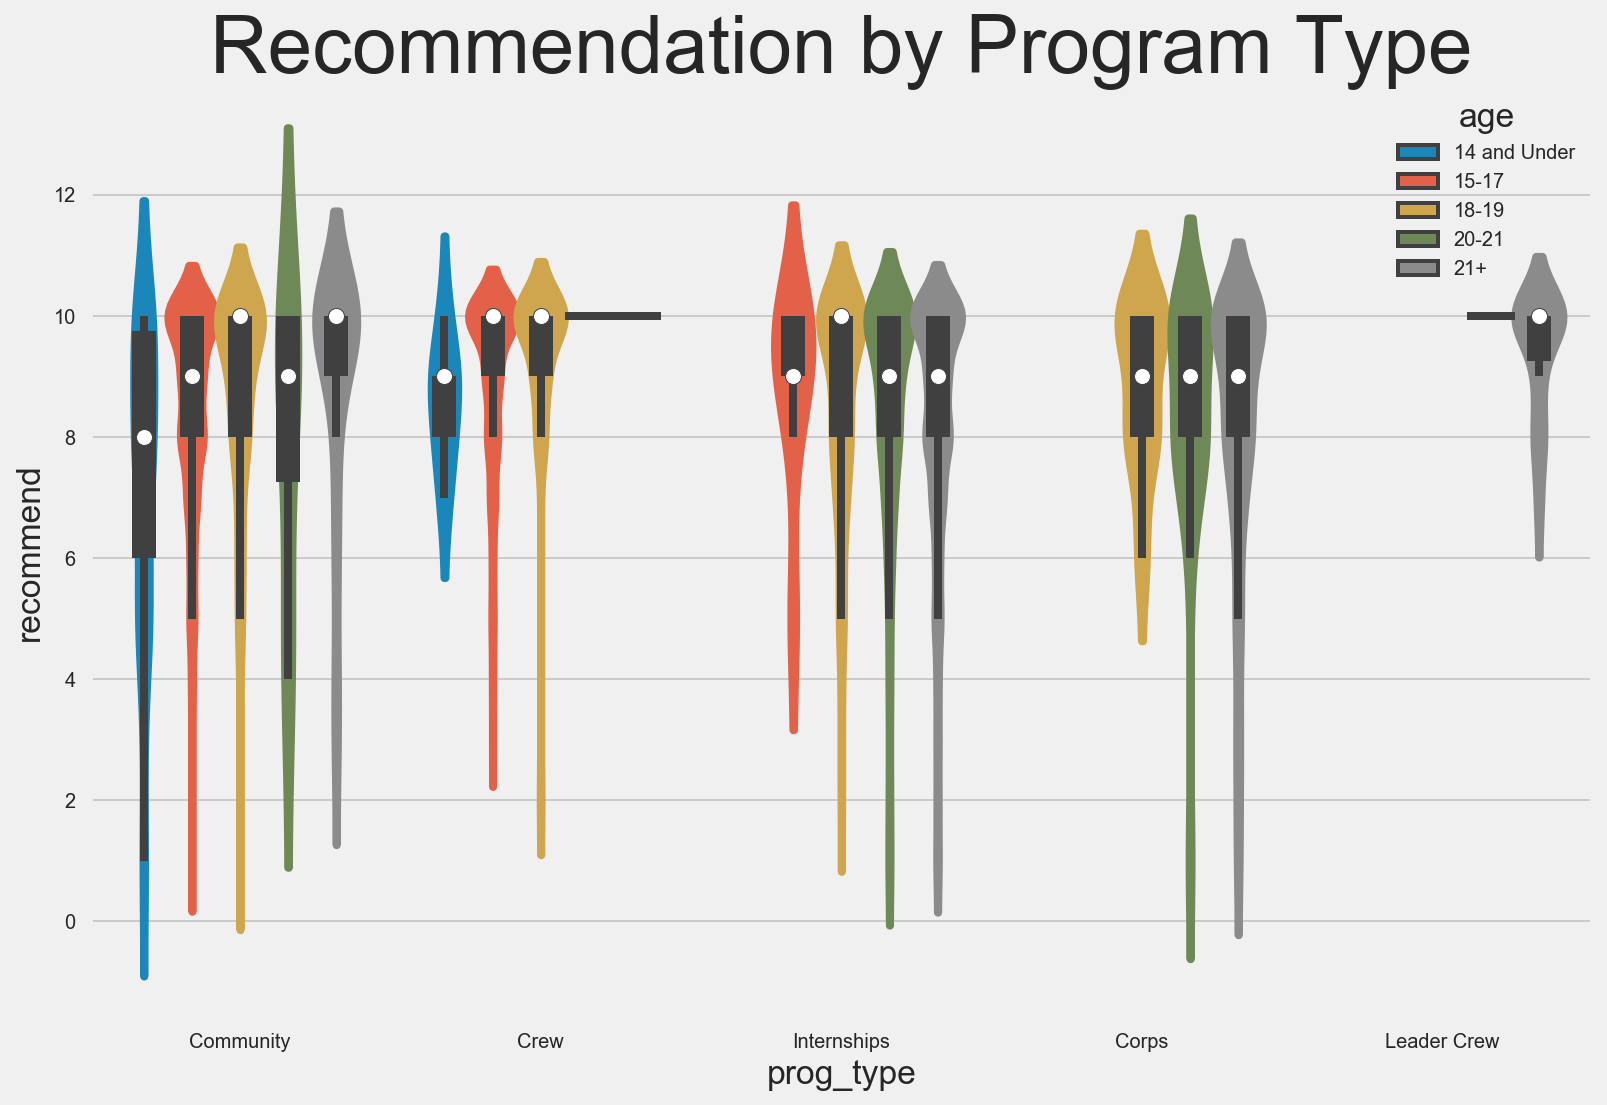

In [188]:
# Plot recommendation by program type and age - violin plot
fig=plt.figure(figsize=(12,8))
plt.title('Recommendation by Program Type',fontsize=40)
order_age = ['14 and Under','15-17','18-19','20-21','21+']
ax1 = sns.violinplot(y="recommend", x="prog_type", hue='age',hue_order=order_age,data=sur);
# plt.ylabel('# of Attacks',fontsize=26)
# plt.xlabel('Year',fontsize=26)
# for tick in ax1.xaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# for tick in ax1.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# fig.subplots_adjust(bottom=0.1)
# fig.subplots_adjust(left=0.1)
# plt.savefig('Attacks by region.png')

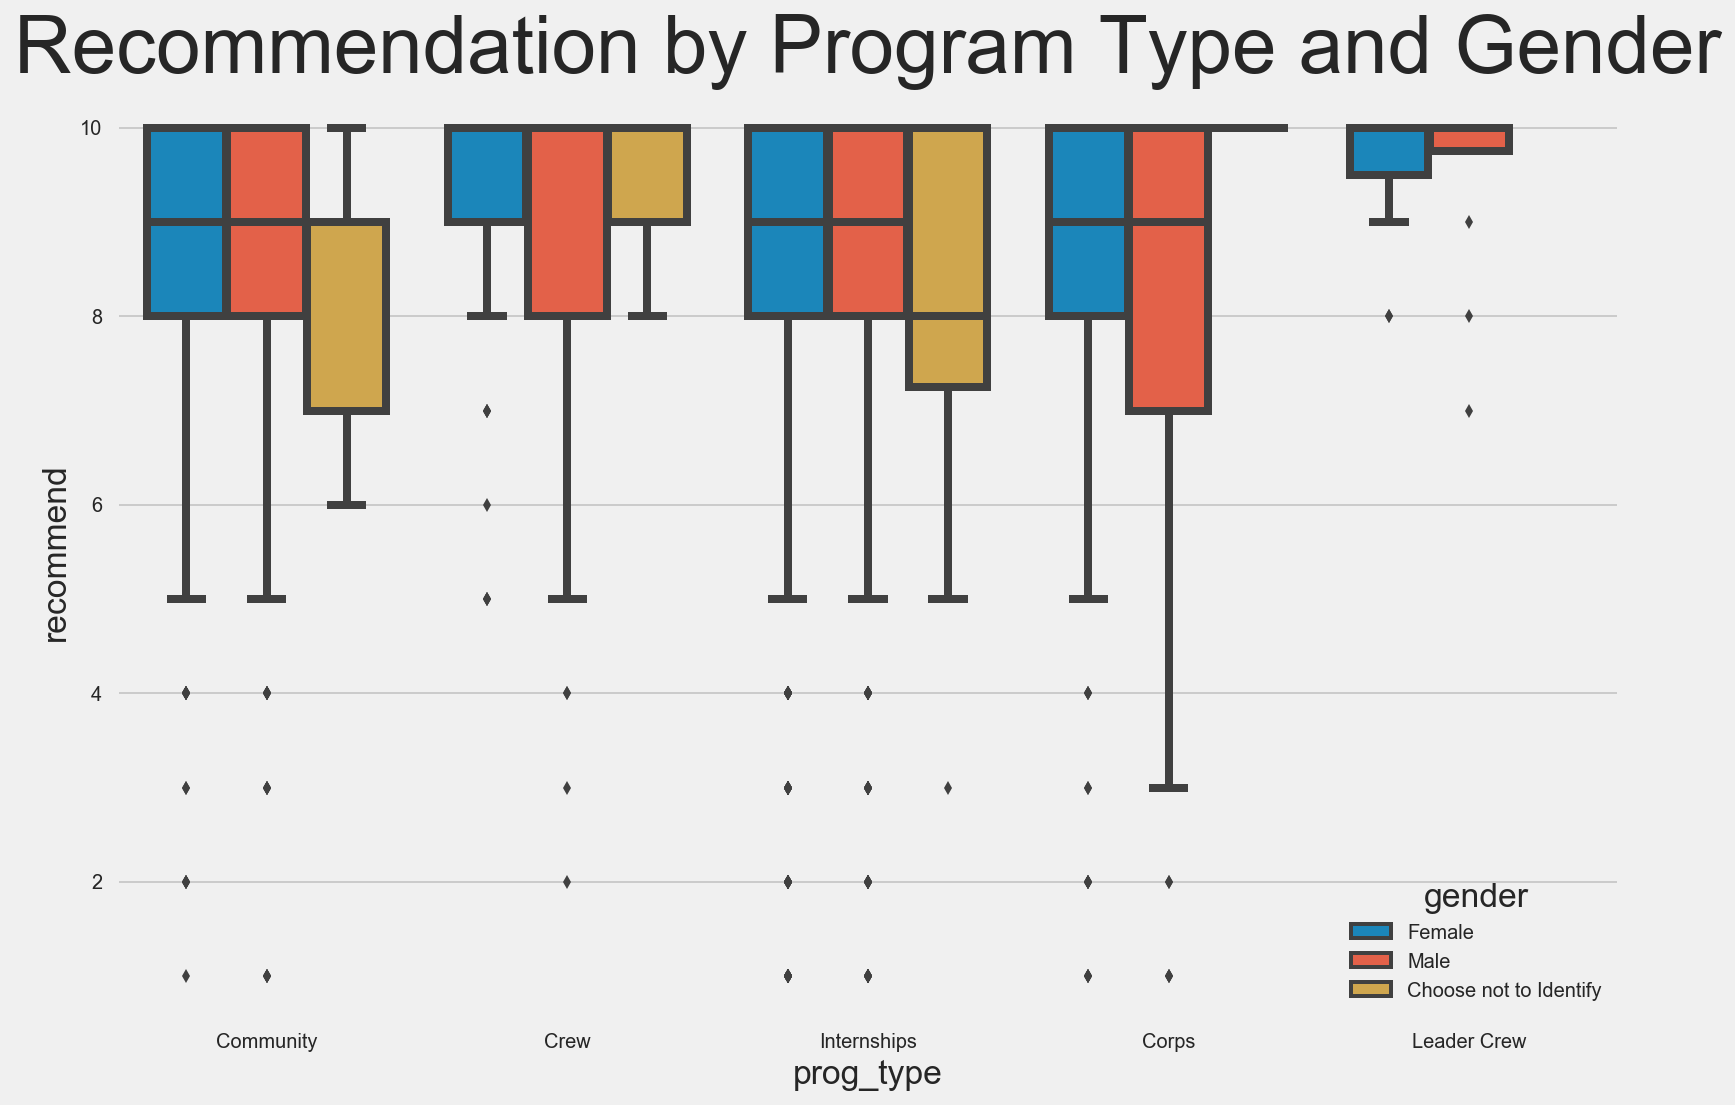

In [189]:
# Box plot by program type and gender
fig=plt.figure(figsize=(12,8))
plt.title('Recommendation by Program Type and Gender',fontsize=40)
ax1 = sns.boxplot(y="recommend", x="prog_type", hue='gender',data=sur);
plt.savefig('Recommendation by Program Type and Gender.png')

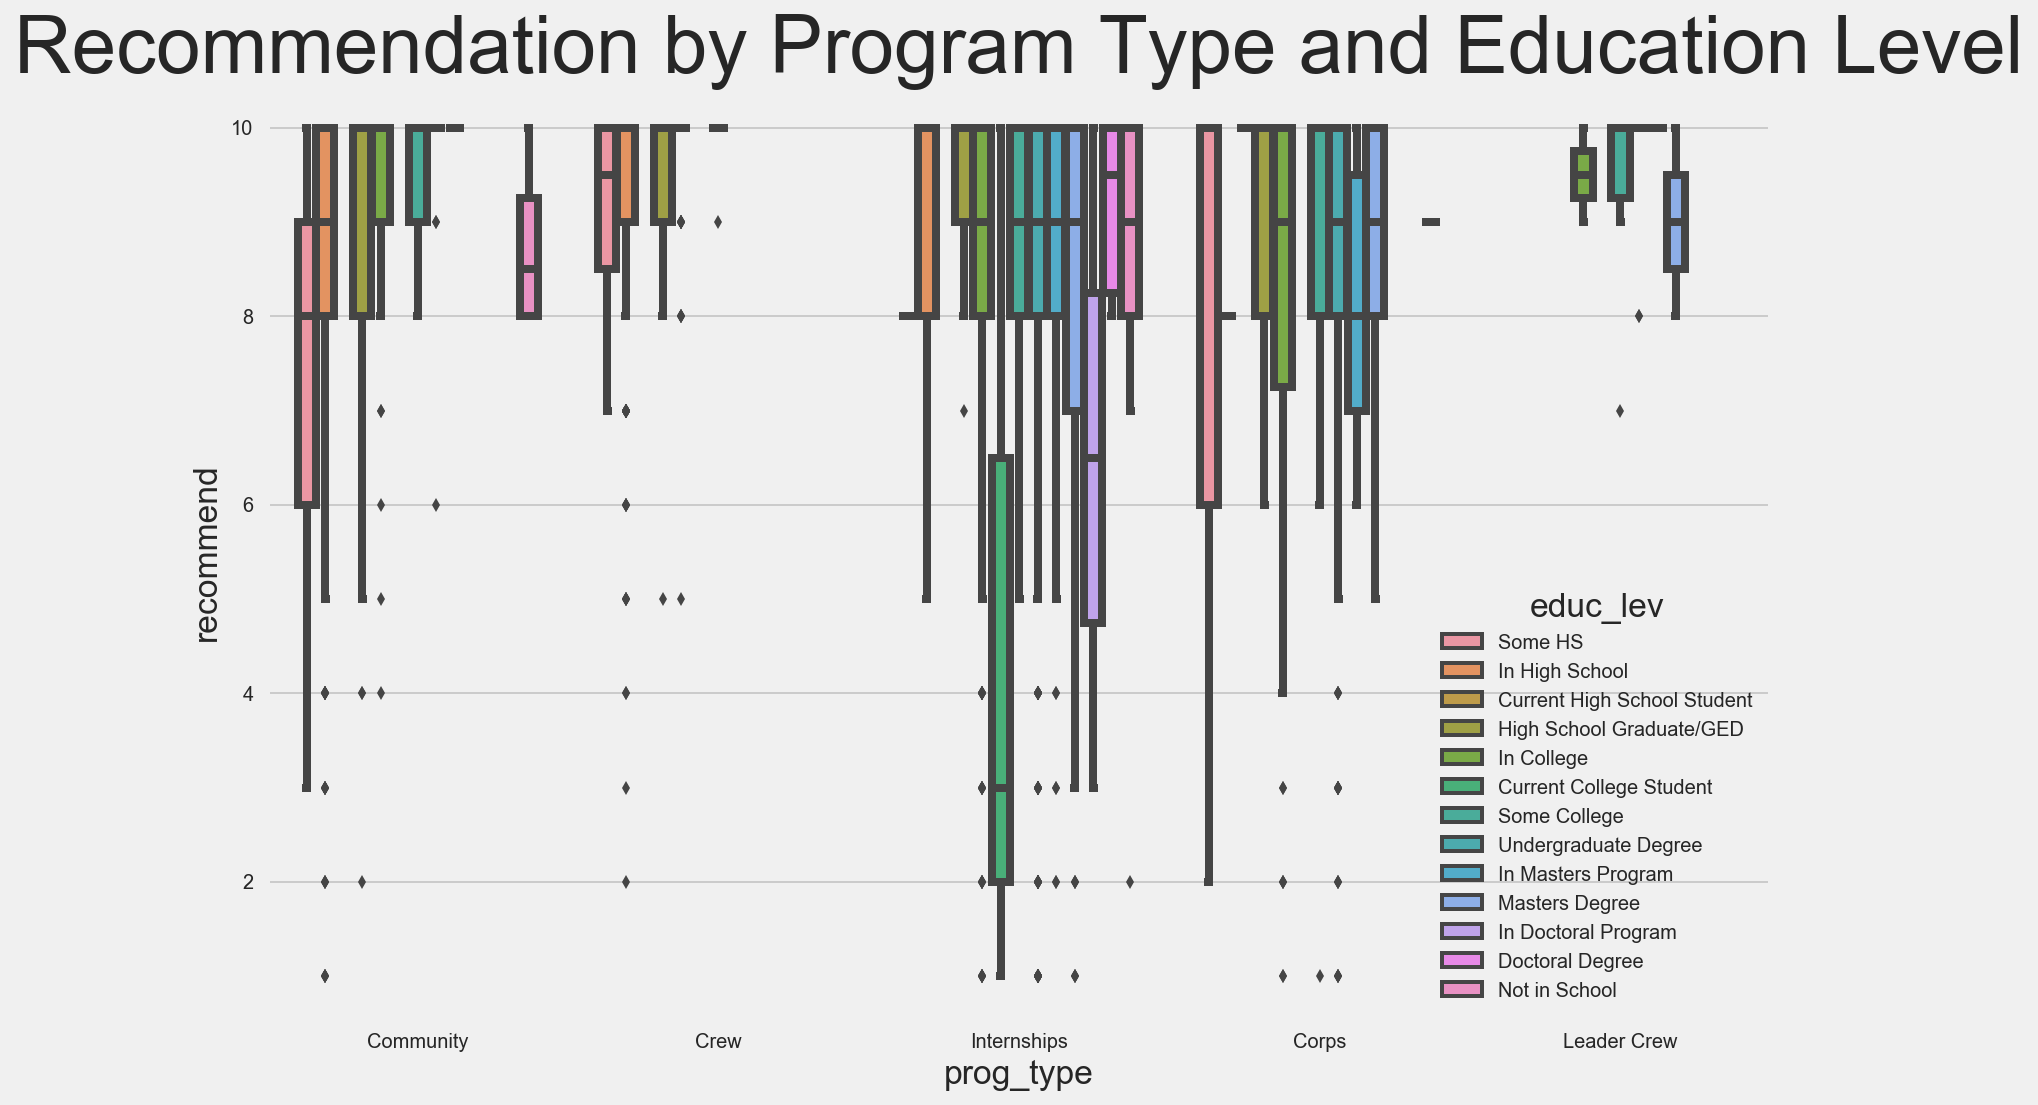

In [190]:
# Box plot by program type and education level
fig=plt.figure(figsize=(12,8))
plt.title('Recommendation by Program Type and Education Level',fontsize=40)
order_edu=['Some HS','In High School','Current High School Student',
           'High School Graduate/GED',
           'In College','Current College Student',
           'Some College','Undergraduate Degree','In Masters Program',
            'Masters Degree','In Doctoral Program',
           'Doctoral Degree','Not in School']
ax1 = sns.boxplot(y="recommend", x="prog_type", hue='educ_lev',
                  hue_order=order_edu,data=sur);
#plt.savefig('Recommendation by Program Type and Gender.png')

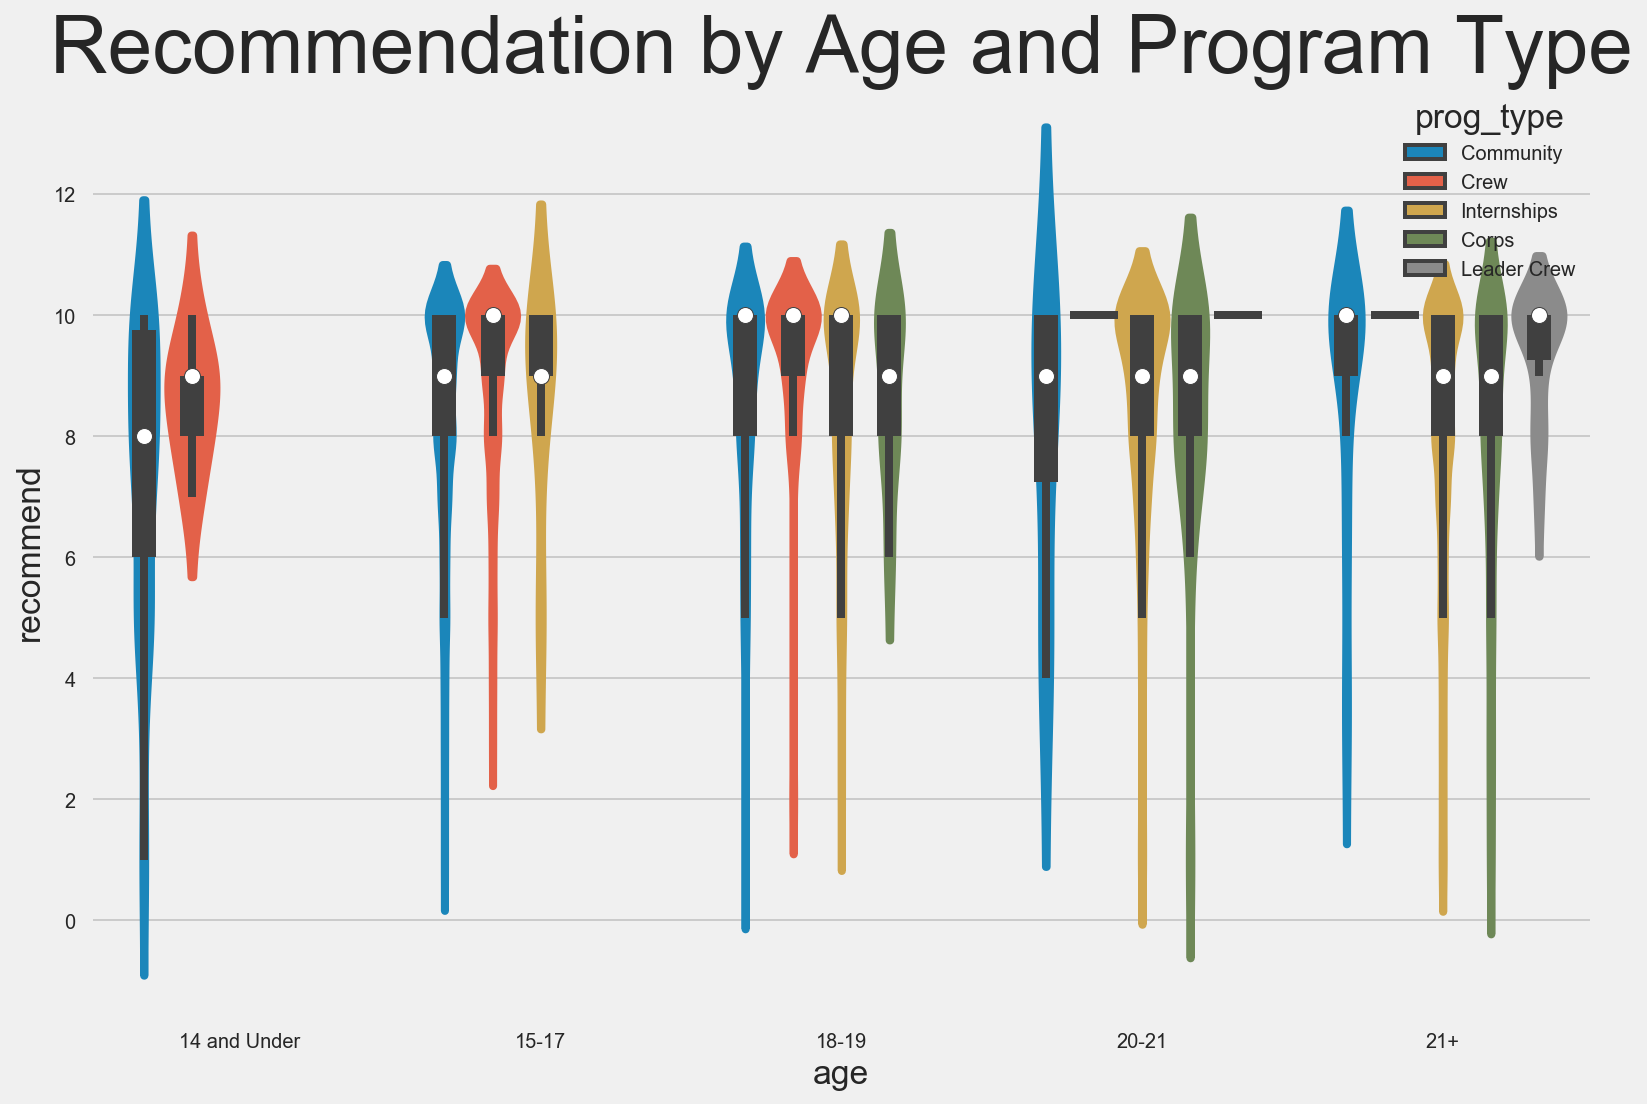

In [191]:
# Plot recommendation by age and program type - violin plot
fig=plt.figure(figsize=(12,8))
plt.title('Recommendation by Age and Program Type',fontsize=40)
order_age = ['14 and Under','15-17','18-19','20-21','21+']
ax1 = sns.violinplot(y="recommend", hue="prog_type", x='age',data=sur,order=order_age);


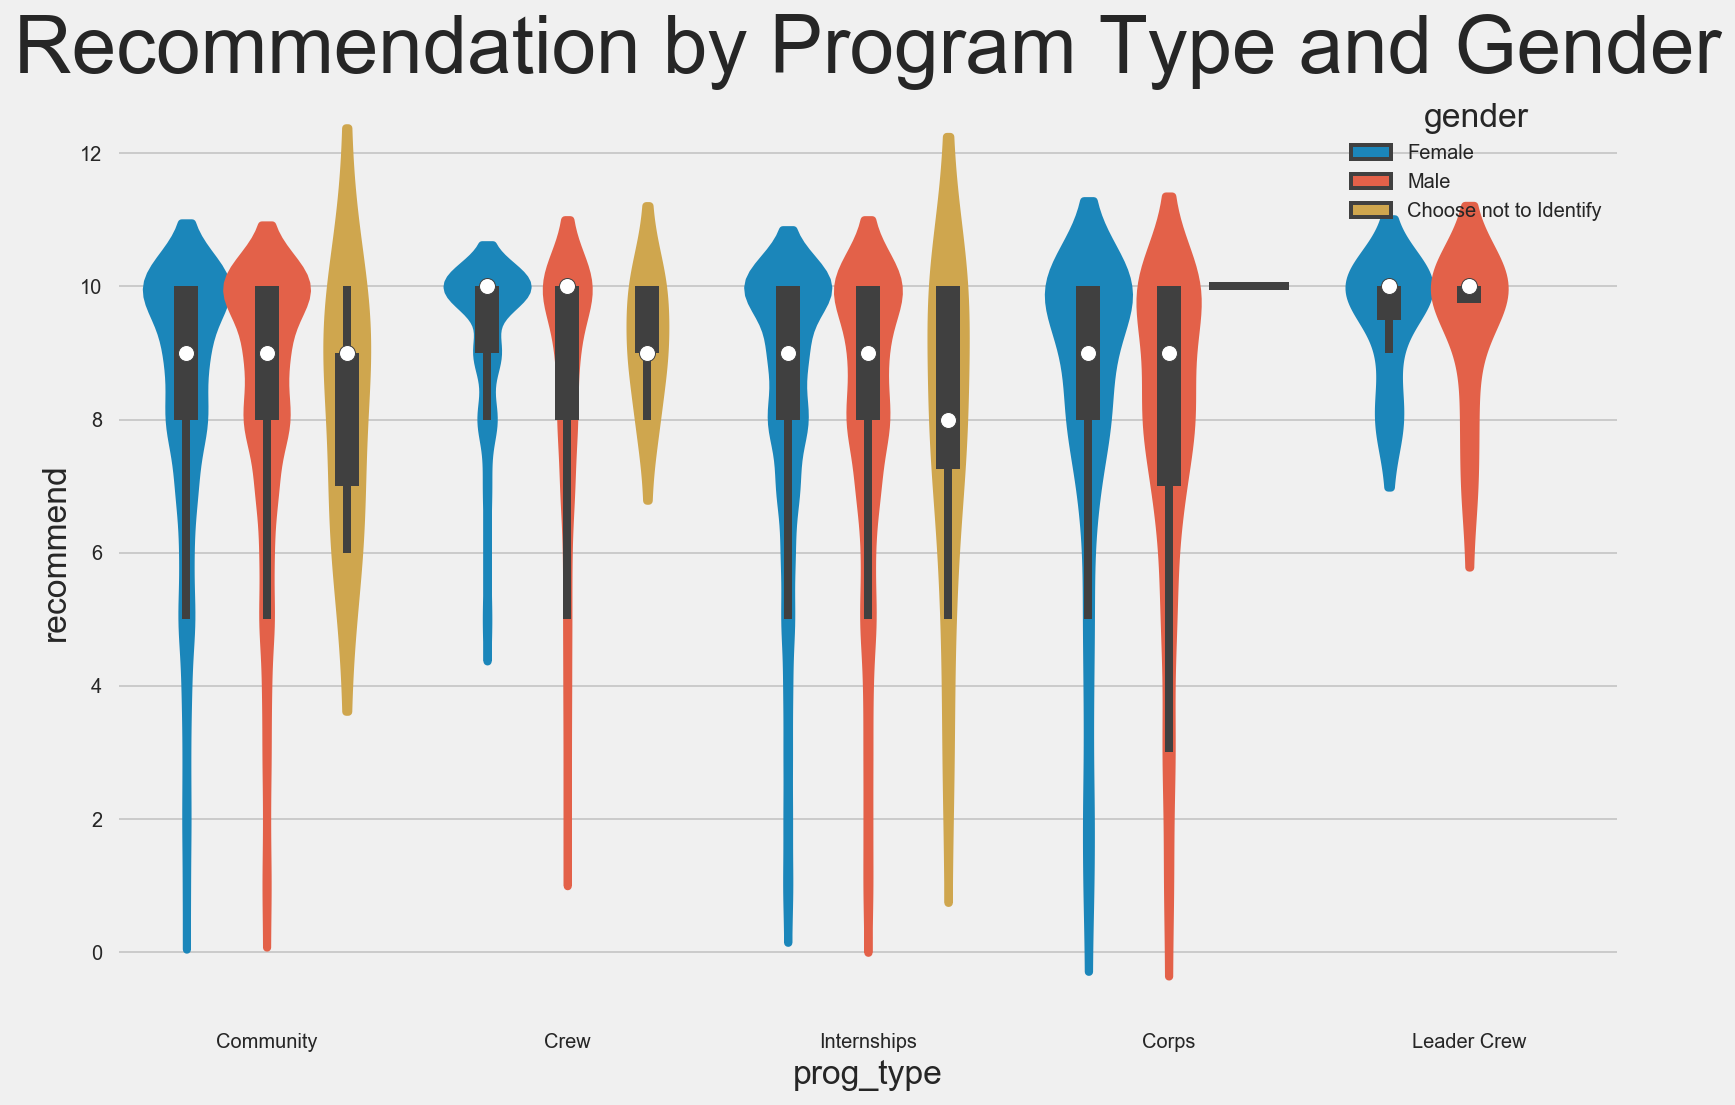

In [192]:
# Plot recommendation by program type and gender - violin plot
fig=plt.figure(figsize=(12,8))
plt.title('Recommendation by Program Type and Gender',fontsize=40)
ax1 = sns.violinplot(y="recommend", x="prog_type", hue='gender',data=sur);


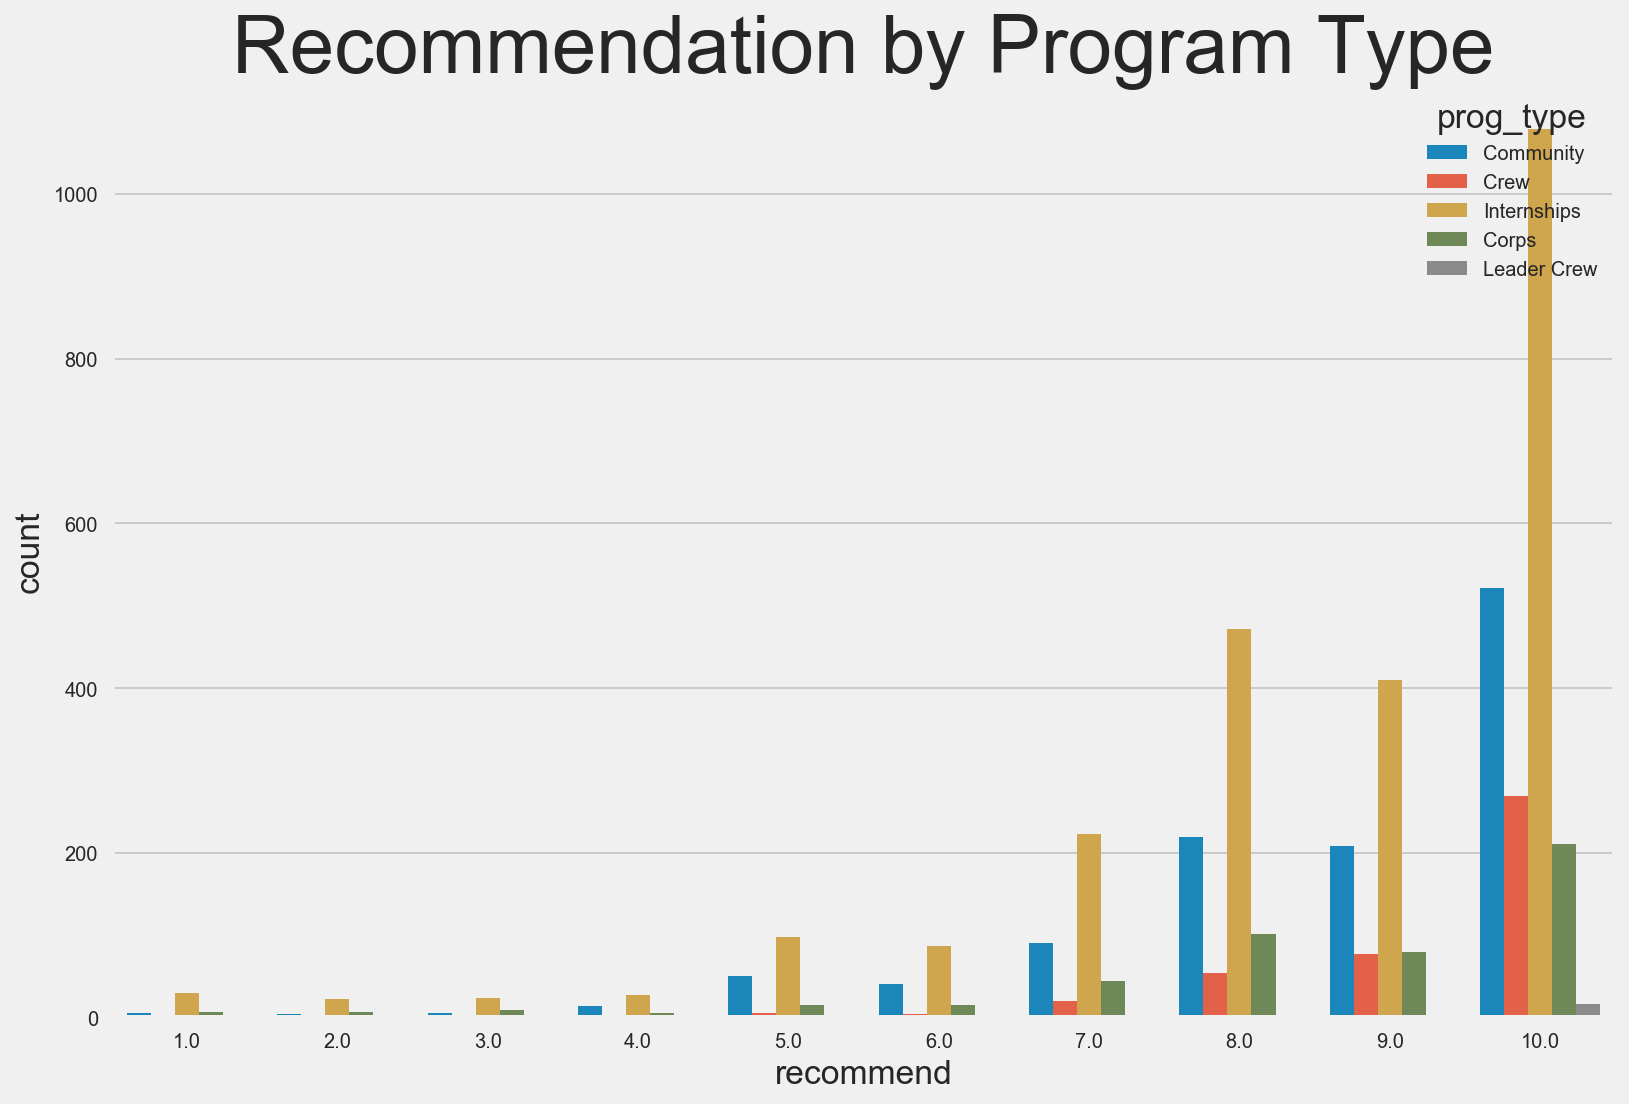

In [193]:
# count plot of recommendation by program type
fig=plt.figure(figsize=(12,8))
plt.title('Recommendation by Program Type',fontsize=40)
ax1 = sns.countplot(x="recommend", hue="prog_type",data=sur);

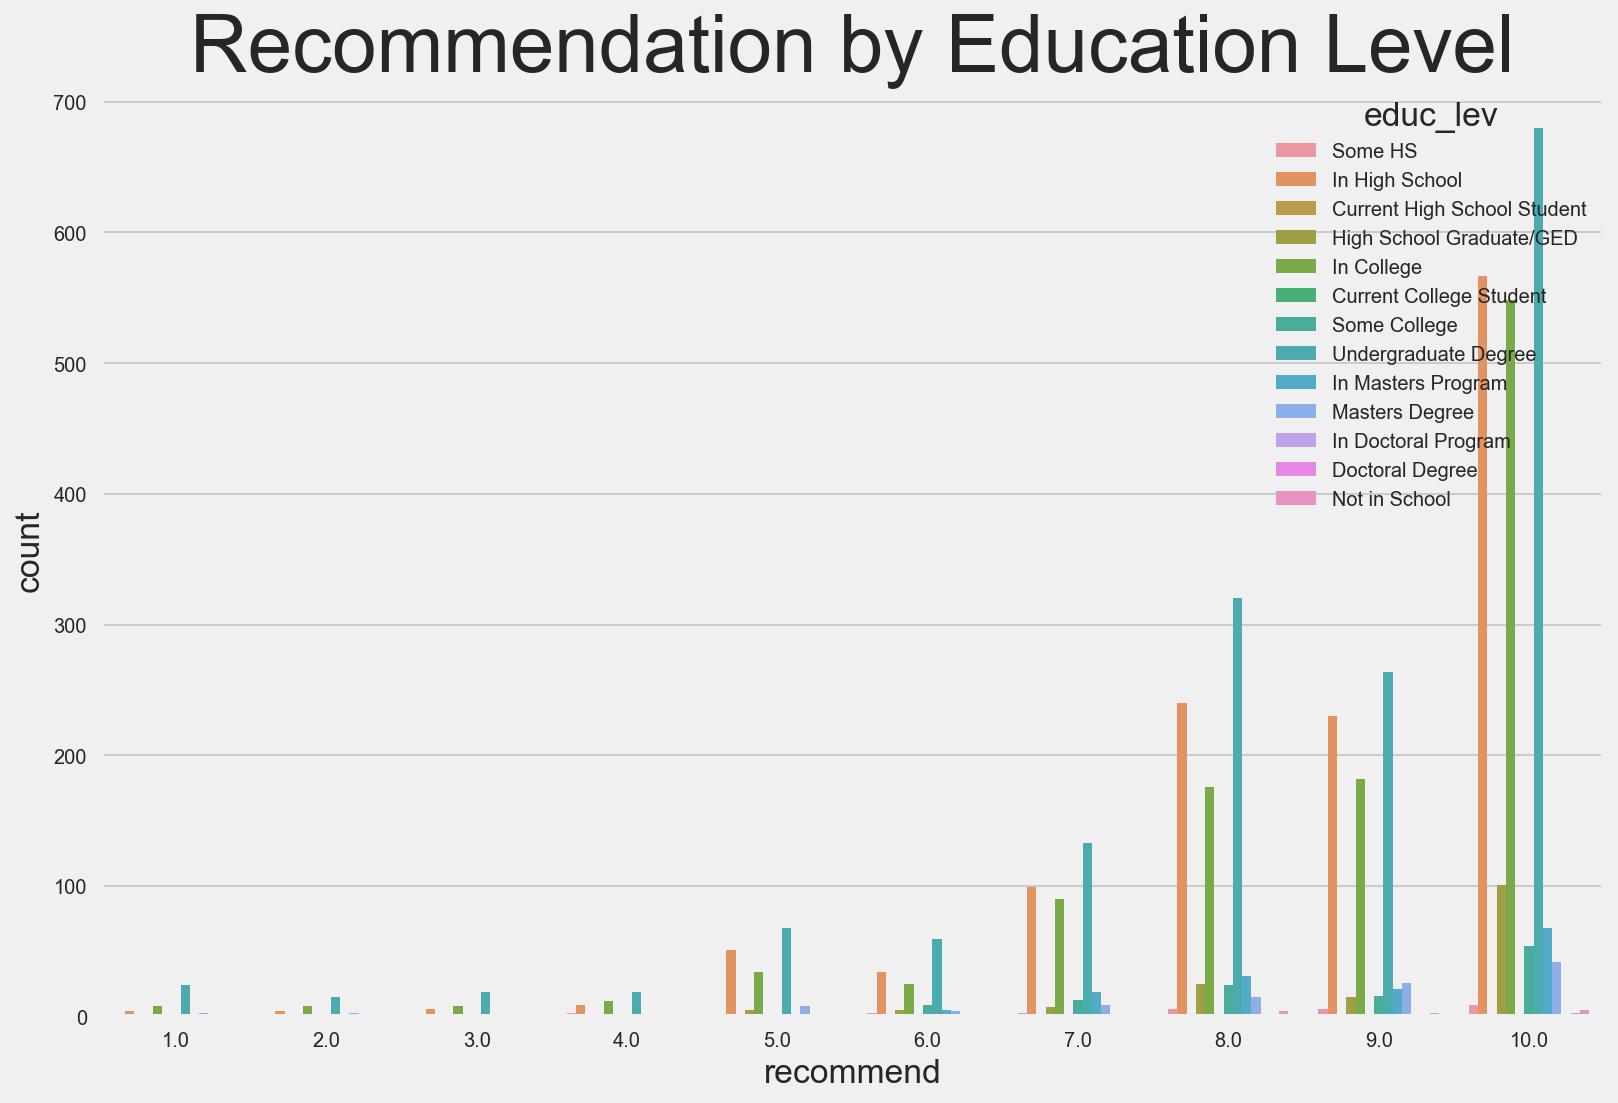

In [194]:
# count plot of recommendation by education level
fig=plt.figure(figsize=(12,8))
plt.title('Recommendation by Education Level',fontsize=40)
ax1 = sns.countplot(x="recommend", hue="educ_lev",hue_order=order_edu,
                    data=sur);

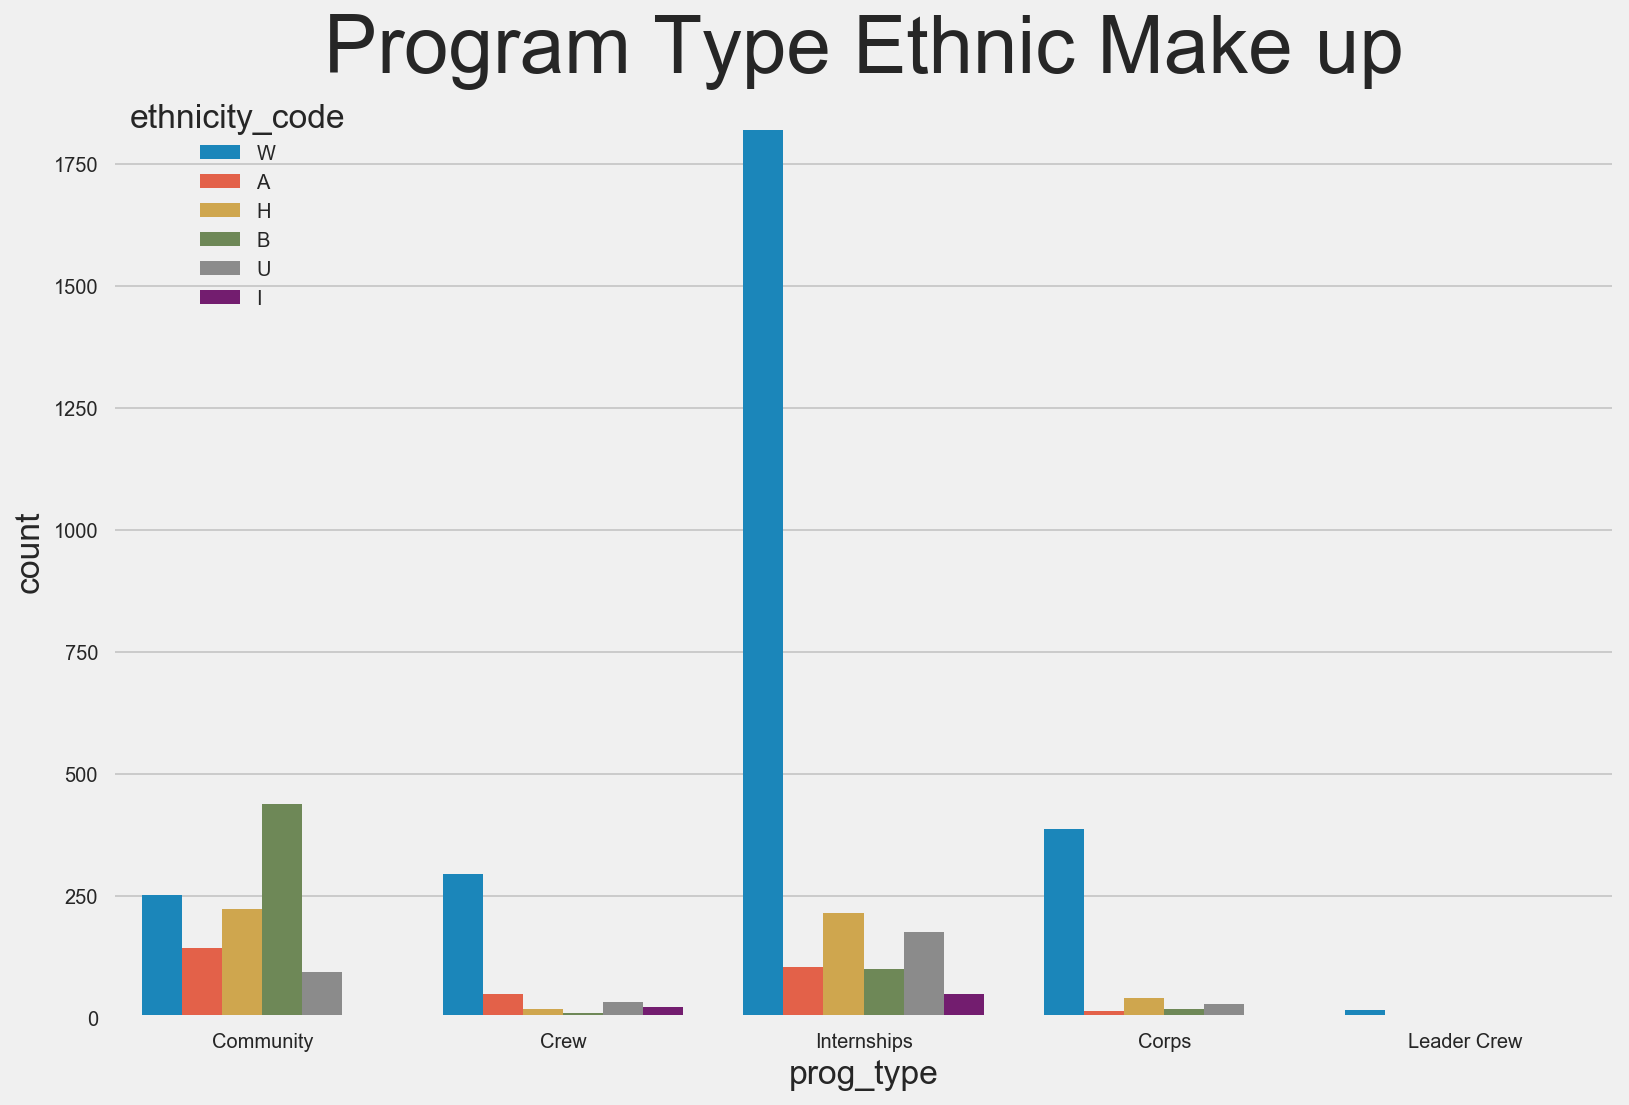

In [195]:
# count plot of program ethnic make up
fig=plt.figure(figsize=(12,8))
plt.title('Program Type Ethnic Make up',fontsize=40)
ax1 = sns.countplot(hue="ethnicity_code", x="prog_type",data=sur);
plt.savefig('Program Type Ethnic Make up.png')

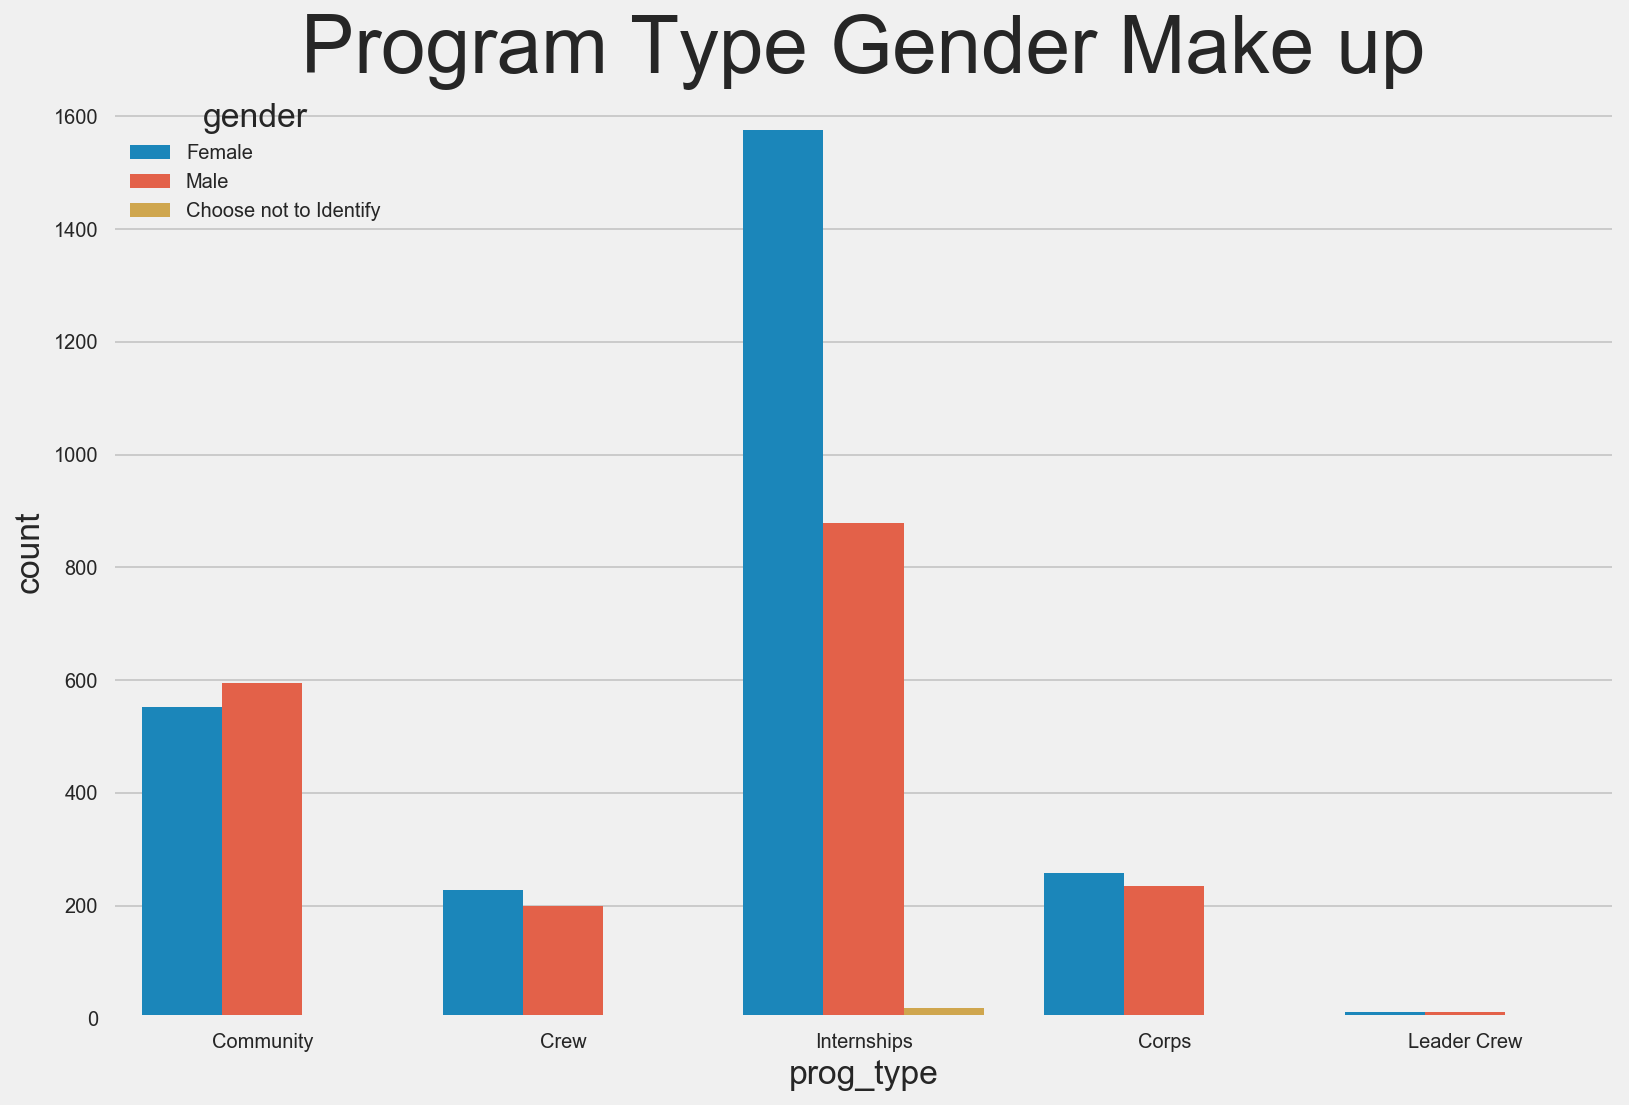

In [196]:
# count plot of program gender make up 
fig=plt.figure(figsize=(12,8))
plt.title('Program Type Gender Make up',fontsize=40)
ax1 = sns.countplot(hue="gender", x="prog_type",data=sur);

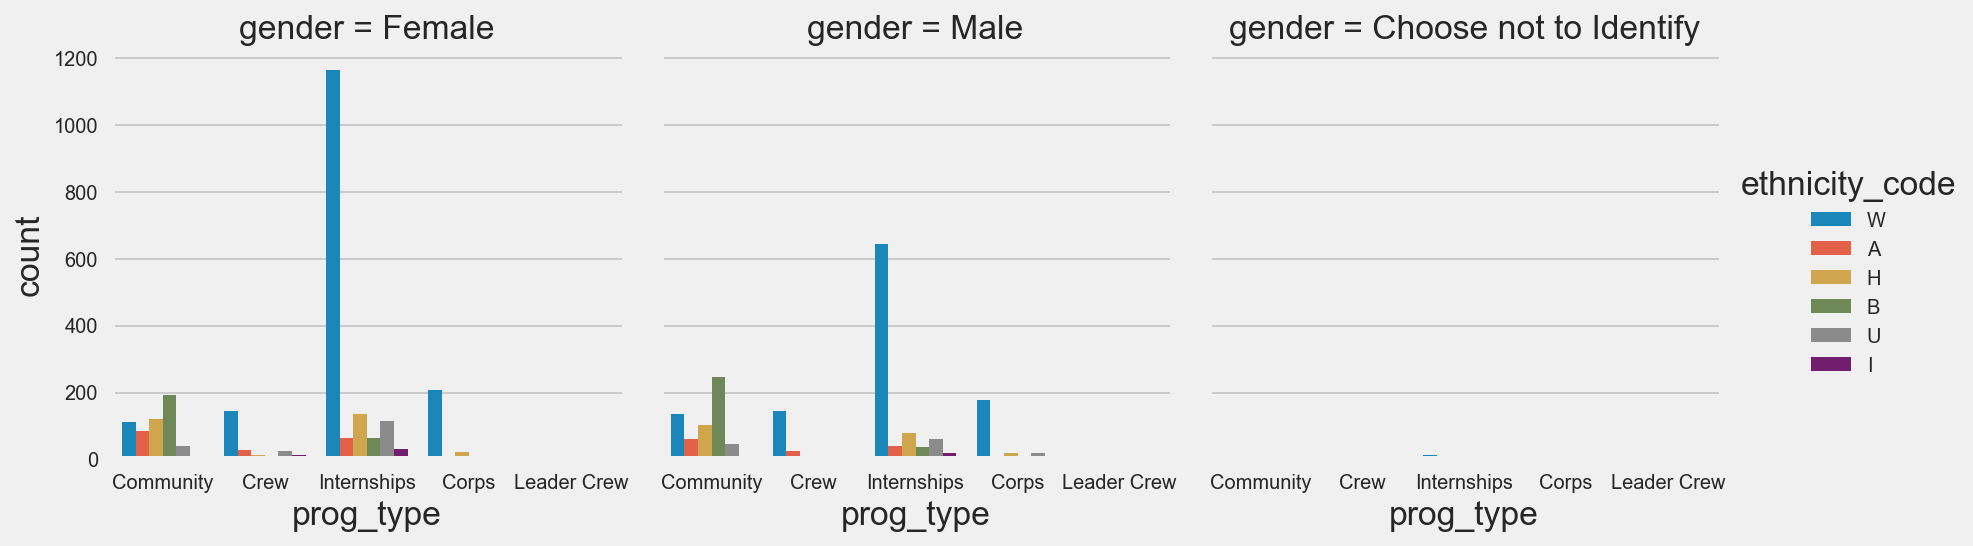

In [197]:
# count plots of ethnicity by program and gender 
#plt.title('Program Type Gender Make up',fontsize=40)
ax1 = sns.factorplot(hue="ethnicity_code", x="prog_type",col='gender',
                     data=sur,kind="count")
plt.savefig('Gender and Ethnicity for each Program Type.png')

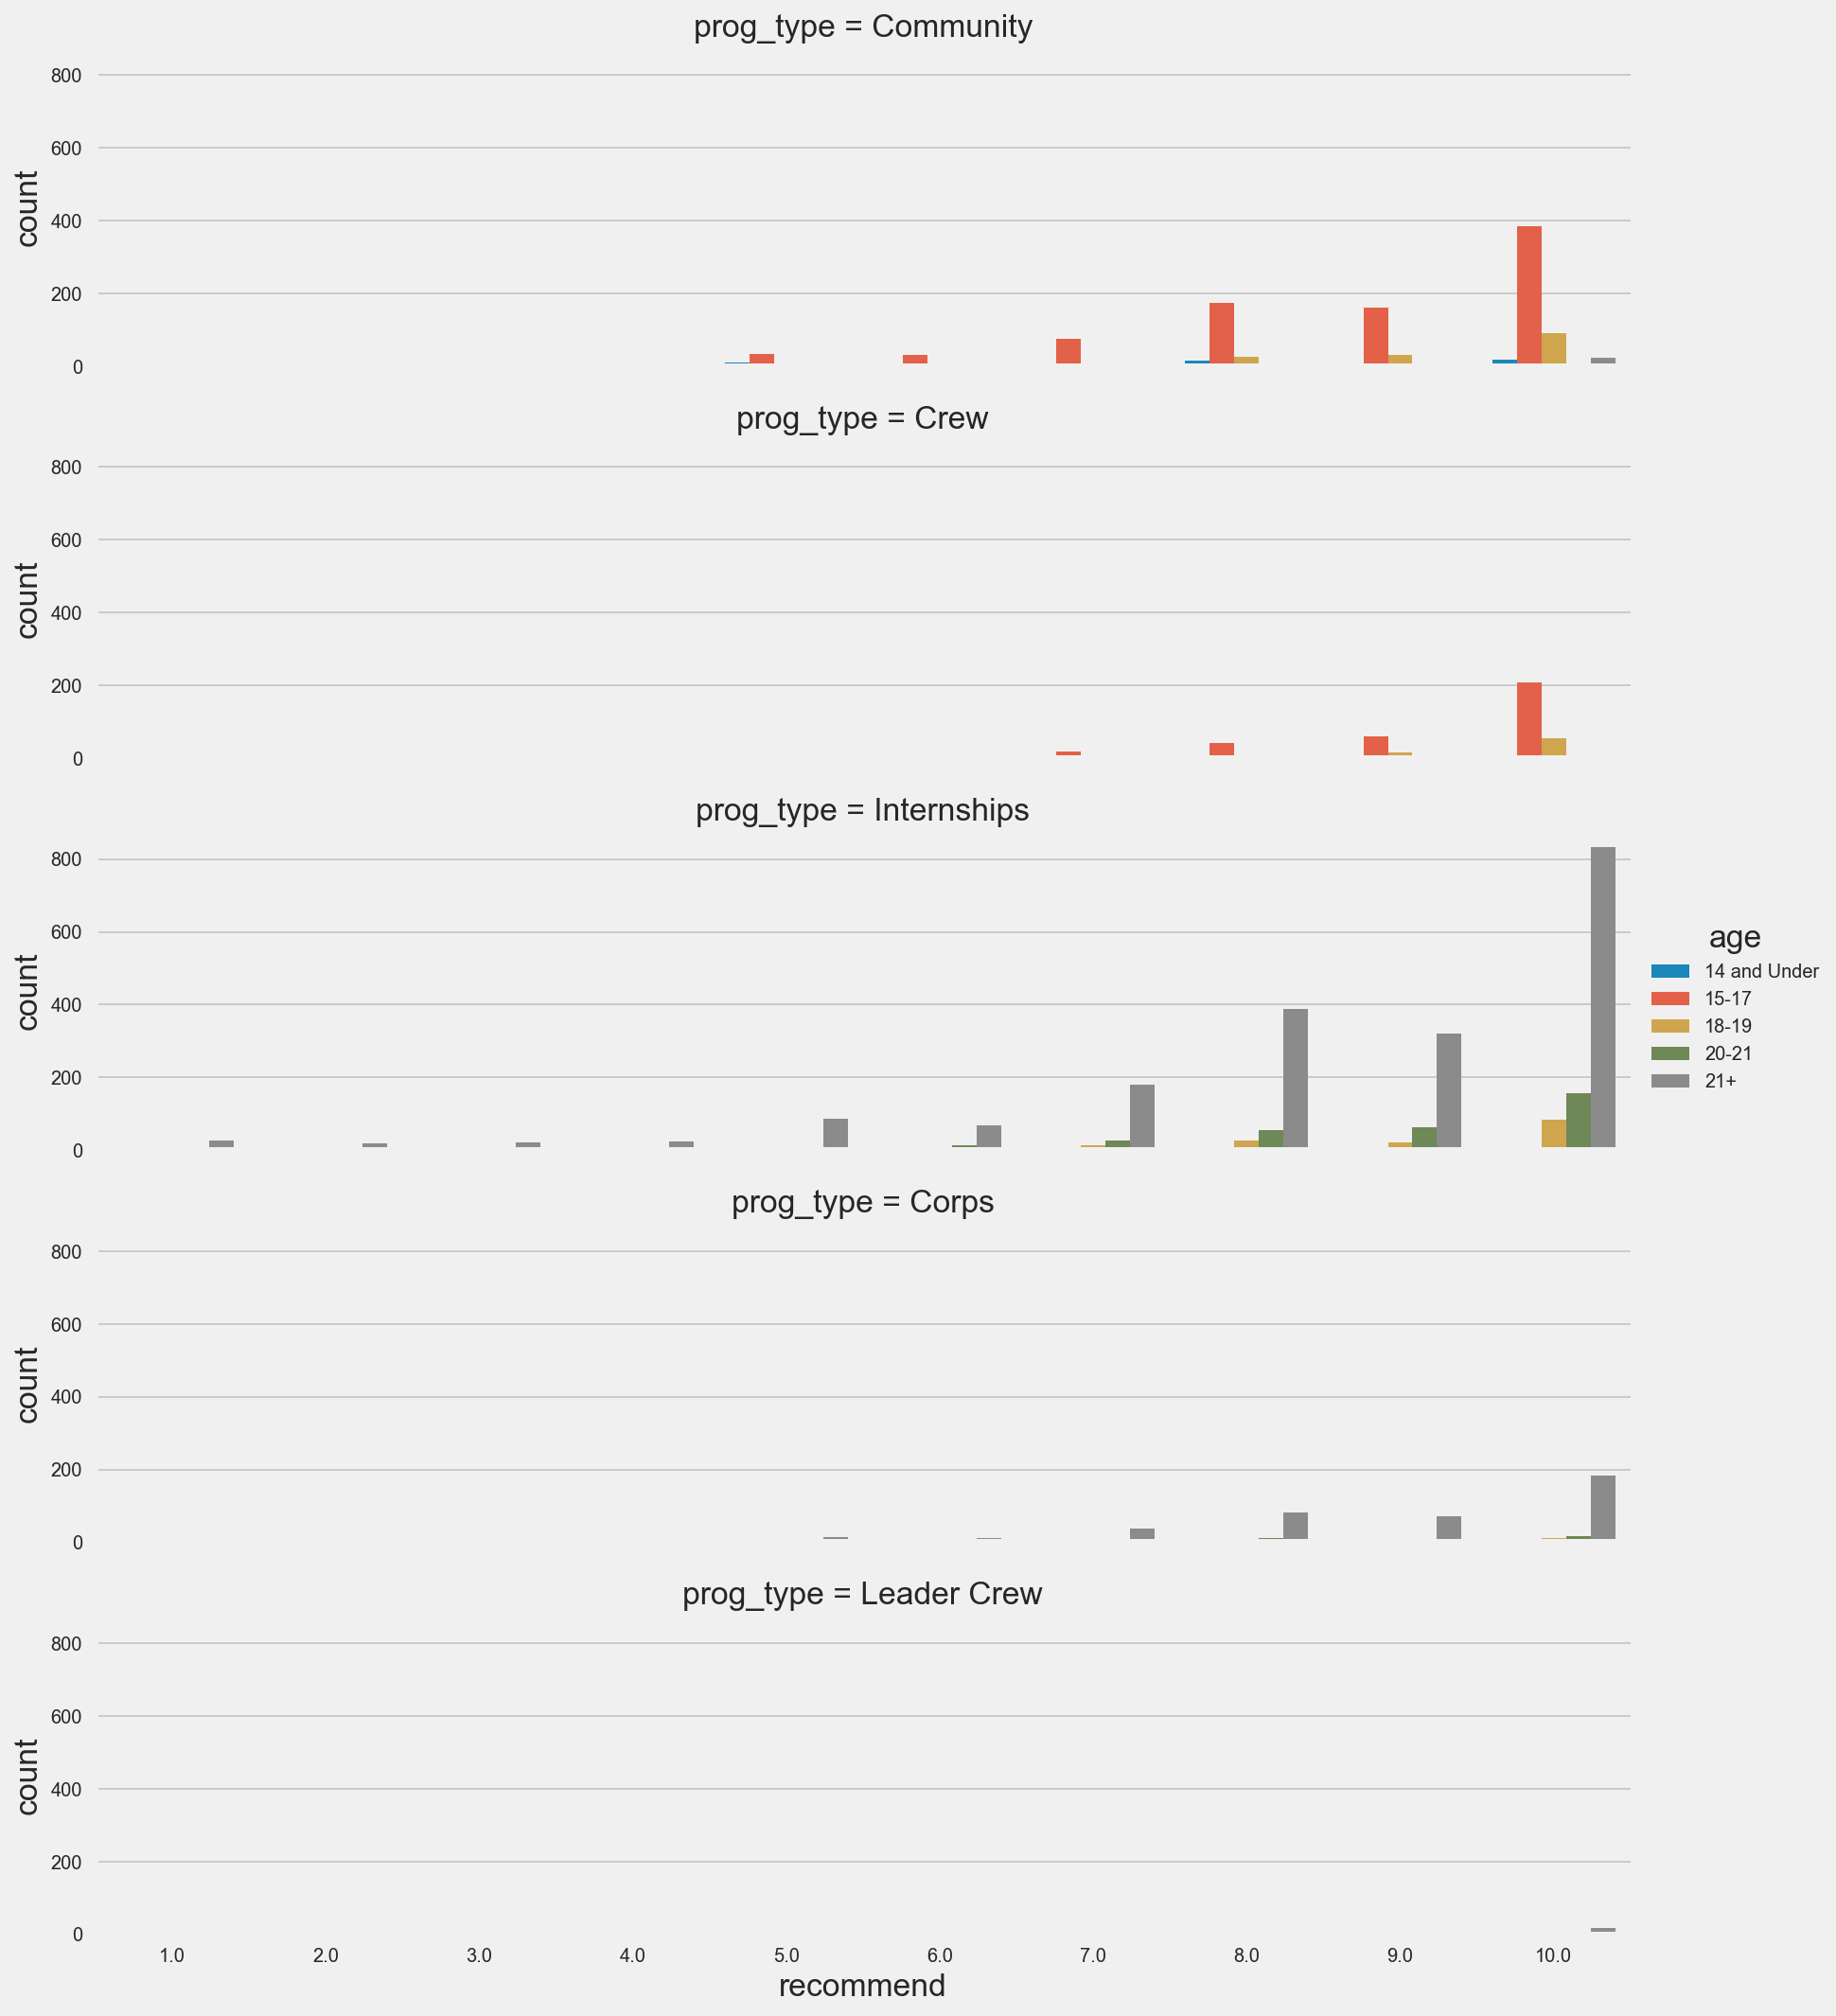

In [198]:
# factor plot of Recommendation by Age and Program Type
#plt.title('Recommendation by Age and Program Type')
ax1 = sns.factorplot(hue="age", x="recommend",row='prog_type',
                     data=sur,kind="count",hue_order=order_age,size=3, 
                     aspect=4.0)
plt.savefig('Recommendation by Age and Program Type.png')

### Additional EDA

In [199]:
# group records by program type and do some EDA
print sur[(sur.prog_type=='Community')].shape 
sur[(sur.prog_type=='Community')].isnull().sum()
# will need to deal with null values

(1161, 98)


time_stamp           0
op_id                0
americorps           0
budget_cd            2
q18               1161
q19               1161
q20               1161
q22               1161
q24               1161
q26a              1161
q26b              1161
q26c              1161
q26d              1161
q35               1161
q36               1161
q48a              1161
q48b              1161
q48c              1161
q48d              1161
q48e              1161
q48f              1161
q49               1161
q50               1161
q76                 10
q85a                10
q85b                12
q85c                13
q85d                13
q85e                 8
q85f                13
q86                 13
q88a                 4
q88b                 2
q88c                 6
q93a                 7
q93b                 7
q93c                 7
q93d                 7
q93e                14
q94a                 5
q94b                 6
q94c                 8
q95a                 6
q95b       

In [200]:
# recommendation score by program type 
sur.groupby('prog_type').recommend.agg('mean')

prog_type
Community      8.667528
Corps          8.449597
Crew           9.267281
Internships    8.524252
Leader Crew    9.521739
Name: recommend, dtype: float64

In [201]:
# weeks by program type 
sur.groupby('prog_type').weeks.value_counts()

prog_type    weeks
Community    6.0      590
             5.0      138
             4.0       57
             2.0       52
             18.0      46
             7.0       44
             16.0      43
             3.0       26
             17.0      19
             12.0      17
             26.0      14
             27.0      12
             31.0      12
             1.0       10
             8.0       10
             21.0      10
             19.0       8
             9.0        7
             10.0       7
             23.0       6
             0.0        5
             11.0       5
             28.0       4
             13.0       3
             20.0       3
             25.0       3
             14.0       2
             34.0       2
             22.0       1
             24.0       1
             30.0       1
             35.0       1
             37.0       1
             38.0       1
Corps        43.0      81
             12.0      44
             23.0      44
             21.0  

In [202]:
# Examine start date and location where less than or equal to 4 weeks
# Tis is what will need to pull weather data for
sur[sur.weeks<=4].groupby(['start_dt','loc_city','loc_st']).end_dt.unique()

start_dt    loc_city                loc_st
2015-06-07  Del Rio                 TX                          [2015-06-27T00:00:00.000000000]
2015-06-08  Napa                    CA                          [2015-06-22T00:00:00.000000000]
            San Antonio             TX                          [2015-07-05T00:00:00.000000000]
            Yosemite National Park  CA                          [2015-07-03T00:00:00.000000000]
2015-06-10  Seward                  AK                          [2015-07-06T00:00:00.000000000]
2015-06-15  Denali Park             AK                          [2015-07-12T00:00:00.000000000]
            International Falls     MN                          [2015-07-12T00:00:00.000000000]
            Kennesaw                GA                          [2015-07-12T00:00:00.000000000]
            Olympia                 WA                          [2015-06-30T00:00:00.000000000]
            Spruce Pine             NC                          [2015-07-12T00:00:00.00000000

### Build Net Promoter Score (NPS) and Compare by Program Type

In [203]:
print 'Recommendation mean: ' + str(sur.recommend.mean())
print 'Recommendation value counts'
print sur.recommend.value_counts(sort=False)

Recommendation mean: 8.62772449869
Recommendation value counts
10.0    2098
9.0      777
8.0      850
6.0      147
4.0       50
7.0      378
2.0       35
5.0      170
3.0       40
1.0       43
Name: recommend, dtype: int64


In [204]:
# function to calculate Net Promoter Score based on a group of recommendations
def nps(vals):
    promoters = vals[vals>=9].count()
    passives = vals[(vals<=8)& (vals>=7)].count()
    detractors = vals[(vals<=6)].count()
    total= (promoters+passives+detractors).astype(float) 
    print '# Promoters ='+str(promoters)+', '+str(round((promoters/total),3)*100)+'%'
    print '# Passives ='+str(passives)+', '+str(round((passives/total),3)*100)+'%'
    print '# Detractors ='+str(detractors)+', '+str(round((detractors/total),3)*100)+'%'
    nps= ((promoters/total)-(detractors/total))
    #print nps
    return nps

nps(sur.recommend)


# Promoters =2875, 62.7%
# Passives =1228, 26.8%
# Detractors =485, 10.6%


0.52092414995640812

In [205]:
# Get net promotor score for each program type
prog_types = sur.prog_type.unique()

for prog in prog_types:
    print prog
    total = sur[sur.prog_type==prog].recommend.count()
    print 'Net Promotor Score: '+str(round(nps(sur[sur.prog_type==prog].
                                                          recommend),3)*100)+' Based on '+ str(total)+' surveys'
    print 'Recommendation mean: ' + str(round(sur[sur.prog_type==prog].recommend.mean(),2))
    print 

Community
# Promoters =730, 62.9%
# Passives =309, 26.6%
# Detractors =122, 10.5%
Net Promotor Score: 52.4 Based on 1161 surveys
Recommendation mean: 8.67

Crew
# Promoters =346, 79.7%
# Passives =74, 17.1%
# Detractors =14, 3.2%
Net Promotor Score: 76.5 Based on 434 surveys
Recommendation mean: 9.27

Internships
# Promoters =1489, 60.2%
# Passives =695, 28.1%
# Detractors =290, 11.7%
Net Promotor Score: 48.5 Based on 2474 surveys
Recommendation mean: 8.52

Corps
# Promoters =291, 58.7%
# Passives =146, 29.4%
# Detractors =59, 11.9%
Net Promotor Score: 46.8 Based on 496 surveys
Recommendation mean: 8.45

Leader Crew
# Promoters =19, 82.6%
# Passives =4, 17.4%
# Detractors =0, 0.0%
Net Promotor Score: 82.6 Based on 23 surveys
Recommendation mean: 9.52



In [206]:
# Leader Crew has high net promotor score but not a lot of samples (23)
# Crew has high net promotor score vs. others programs
# Community, Internship, and Corp have lower net promoter scores

In [207]:
# Weeks for each program
for prog in prog_types:
    total = sur[sur.prog_type==prog].weeks.count().astype(float)
    print str(prog)+' %of surveys less than 4 weeks '+str(
        sur[(sur.prog_type==prog)&(sur.weeks<=4)].weeks.count()/total)

Community %of surveys less than 4 weeks 0.129198966408
Crew %of surveys less than 4 weeks 0.884792626728
Internships %of surveys less than 4 weeks 0.0210185933711
Corps %of surveys less than 4 weeks 0.00604838709677
Leader Crew %of surveys less than 4 weeks 0.521739130435


In [208]:
# Leader crew and crew are the shorter programs that will consider weather for
# Leader crew may not be worth analyzing

In [209]:
# Ages for each program
for prog in prog_types:
    print str(prog)
    print sur[sur.prog_type==prog].age.value_counts()

Community
15-17           880
18-19           174
14 and Under     66
21+              33
20-21             8
Name: age, dtype: int64
Crew
15-17           343
18-19            81
14 and Under      7
21+               2
20-21             1
Name: age, dtype: int64
Internships
21+      1969
20-21     331
18-19     163
15-17      11
Name: age, dtype: int64
Corps
21+      430
20-21     41
18-19     25
Name: age, dtype: int64
Leader Crew
21+      22
20-21     1
Name: age, dtype: int64


In [210]:
# Community and Crew are both HS age.   Crew gets higher ratings
# Corp are longer term crew type programs for older youth.   Internships are done individually

### Pull in demographic data.   Data obtained from ‘Selected Economic Characteristics’ and ‘Household Income’ from the American Community Survey (factfinder.census.gov)

In [211]:
# Read in file with health and poverty information
# Taken from American Community Survey  ‘Selected Economic Characteristics’ and 
# ‘Household Income’ by zip code (csv files downloaded from factfinder.census.gov) 

# removed columns that weren't relevant prior to reading in
health_pov = pd.read_csv('Health and poverty by zip short2.csv')

In [212]:
health_pov.dtypes

zip           object
employed      object
SNAP          object
health_ins    object
poverty       object
dtype: object

In [213]:
health_pov.head(3)

zip employed  SNAP health_ins poverty
0  8600000US00601     43.2  52.8         92    59.6
1  8600000US00602     46.7  45.7         94    49.4
2  8600000US00603     40.1  43.6       94.3    46.9

In [214]:
health_pov['zip']=health_pov.zip.str[-5:]

In [215]:
health_pov.head(3)


zip employed  SNAP health_ins poverty
0  00601     43.2  52.8         92    59.6
1  00602     46.7  45.7         94    49.4
2  00603     40.1  43.6       94.3    46.9

In [216]:
health_pov.shape

(33120, 5)

In [217]:
# merge the health and poverty information into the master dataframe
# matching the information by the participant home zip cod
sur = pd.merge(sur, health_pov, left_on='mem_zip', right_on='zip',
      how='left', sort=False)

In [218]:
# more nulls in health and poverty fields than in the member zip fields
sur[pd.isnull(sur['zip'])].mem_zip

21        NaN
104       NaN
156       NaN
198       NaN
291     37383
327      9516
330     37235
431       NaN
476       NaN
542     00681
582     77710
655      same
742       928
763     80946
790     99708
801       NaN
811     L1N6C
910       NaN
914        MD
941     75033
948     96799
960     98505
966     99623
981     99687
1063    V3H 5
1067    L8K 3
1089    V1K 1
1116    Illin
1165      NaN
1204    84129
1272    99708
1342      NaN
1394    32067
1398      NaN
1431    86304
1498    93006
1506    55015
1533     1121
1616      NaN
1635      NaN
1657    93006
1687    96932
1761    74444
1765     4011
1783      NaN
1784    96928
1796    N7G3A
1885      NaN
1902    74444
1912     1121
1935      NaN
1977      NaN
2091      NaN
2155      NaN
2175    96745
2176    00084
2272    99708
2285     4825
2298    MN|US
2331    NW3 4
2335    24061
2397     1559
2414      NaN
2463      NaN
2464      NaN
2474     1514
2490      NaN
2509      NaN
2590      NaN
2626    02456
2757      NaN
2785  

In [219]:
# read in the median income data
# removed columns that weren't relevant prior to reading in
income = pd.read_csv('Median HH income by zip short.csv')

In [220]:
print income.shape
income.dtypes

(33120, 2)


zip       object
income    object
dtype: object

In [221]:
income.head(3)

zip income
0  8600000US00601  10816
1  8600000US00602  16079
2  8600000US00603  16804

In [222]:
# remove everything but zip code from zip field
income['zip']=income.zip.str[-5:]

In [223]:
# merge income data into survey data frame
sur = pd.merge(sur, income, left_on='mem_zip', right_on='zip',
      how='left', sort=False)

### Pull Weather Data for Experiences of Less than 4 Weeks.  Will Pull Data by Location (City, State) and Data.   Pull Requires an Account with Weather Underground. 

In [224]:
# create dataframe that need to pull weather data for

weather = pd.DataFrame(sur[sur.weeks<=4].
                       groupby(['start_dt','end_dt','weeks','loc_city','loc_st','prog_type']).recommend.agg('count')).reset_index()
# also did a file with recommend.mean() - pasted columns into one
# xls file when did city name edits

In [225]:
### Need to insert code from weather notebook

In [226]:
### Need to replace with code from weather notebook
# function to build the date string
def parse_dt(date):
    return str(date)[0:4]+str(date)[5:7]+str(date)[8:10]

# # loop through weather data frame
# for i in range(len(weather)):
# #for i in range(10):
# ## need to add loop for all days in period, then take average

#     date=parse_dt(weather.loc[i].start_dt)
#     state =str(weather.loc[i].loc_st)
#     city = str(weather.loc[i].loc_city)

# # date=parse_dt(weather.loc[0].start_dt)
# # state =str(weather.loc[0].loc_st)
# # city = str(weather.loc[0].loc_city)

# # build the url to call weather underground
#     url_start='http://api.wunderground.com/api/4f93b3fe126d6f61/history_'
#     url_date = date
#     url_middle='/q/'
#     url_state_city = str(state)+'/'+str(city)
#     url_end = '.json'
#     full_request_url= url_start+url_date+url_middle+url_state_city+url_end

# # do the call to weather underground
#     data = requests.get(full_request_url).json()
# # 6 second pause since weather underground only allows 10 calls per minue
#     time.sleep(6)
# ## may need to upgrade subscription

# # retrieve the data and put into data frame.
# # If data not available, print message
#     try:
#         for summary in data['history']['dailysummary']:
#             precip = summary['precipi']
#             maxtemp = summary['maxtempi']
#             meantemp = summary['meantempi']
#             mintemp = summary['mintempi']
#             weather.set_value(i,'precip',precip)
#             weather.set_value(i,'maxtemp',maxtemp)
#             weather.set_value(i,'meantemp',meantemp)
#             weather.set_value(i,'mintemp',mintemp)
#             #print 'Precipitation= '+precip
#             #print 'Max temp= '+maxtemp
#             #print 'Mean temp= '+meantemp
#             #print 'Min temp= '+mintemp
#     except:
#         print 'Invalid location or date '+url_state_city+' '+url_date
            
# #date=str(weather.loc[0].start_dt)[0:4]+str(weather.loc[0].start_dt)[5:7]+str(weather.loc[0].start_dt)[8:10]
# #full_request_url = 'http://api.wunderground.com/api/4f93b3fe126d6f61/history_20170811/q/NC/Raleigh.json'
# # print ','.join((summary['precipi'], summary['maxtempi'], summary['meantempi'],summary['mintempi']))
# # i are imperial temperatures
# # check the status: 200 means success, 4xx means error
# # print data.status_code
# # view the raw response text
# # data

In [227]:
#len(weather)

In [228]:
# # write to file so can edit names that weather underground doesn't recognize
# weather.to_csv('weather_to_pull_count.csv')
# # reload file after correcting 5 location names

In [229]:
#weather.head(199)

In [230]:
# read in weather data

In [231]:
weather = pd.read_csv('weather_to_pull_final2.csv',usecols=[1,2,4,6,7,8,9,10,11,12,13,14])

In [232]:
print weather.shape
weather.dtypes

(199, 12)


start_dt          object
end_dt            object
loc_city_orig     object
loc_st            object
prog_type         object
recommend        float64
count              int64
precip           float64
maxtemp          float64
meantemp         float64
mintemp          float64
days               int64
dtype: object

In [233]:
# change dates to datetime
weather.start_dt=pd.to_datetime(weather.start_dt)
weather.end_dt=pd.to_datetime(weather.end_dt)

# rename recommend to recommend average
weather.rename(columns={'recommend':'recommend_av'},inplace=True)

In [234]:
weather.dtypes

start_dt         datetime64[ns]
end_dt           datetime64[ns]
loc_city_orig            object
loc_st                   object
prog_type                object
recommend_av            float64
count                     int64
precip                  float64
maxtemp                 float64
meantemp                float64
mintemp                 float64
days                      int64
dtype: object

In [235]:
weather.head(4)

start_dt     end_dt           loc_city_orig loc_st prog_type  \
0 2015-06-07 2015-06-27                 Del Rio     TX      Crew   
1 2015-06-08 2015-06-22                    Napa     CA      Crew   
2 2015-06-08 2015-07-03  Yosemite National Park     CA      Crew   
3 2015-06-08 2015-07-05             San Antonio     TX      Crew   

   recommend_av  count  precip  maxtemp  meantemp  mintemp  days  
0      9.600000      5    0.17    90.86     81.90    72.52    20  
1      8.857143      7    0.01    77.13     64.40    51.20    14  
2      8.500000      4    0.00    84.23     74.81    65.15    25  
3      8.200000      5    0.20    89.75     82.54    74.79    27

In [236]:
# merge weather data into survey data
sur = pd.merge(sur, weather, left_on=['start_dt','end_dt','loc_city','loc_st','prog_type'], 
               right_on=['start_dt','end_dt','loc_city_orig','loc_st','prog_type'],
               how='left', sort=False)

In [237]:
sur.head(13)

time_stamp            op_id americorps budget_cd  q18  q19  q20  \
0  2015-06-09 01:11:00  a0r40000007cPLS         No       252  NaN  NaN  NaN   
1  2015-06-10 18:03:00  a0r40000004pvX5         No       252  NaN  NaN  NaN   
2  2015-06-10 18:05:00  a0r40000004qEVo         No       252  NaN  NaN  NaN   
3  2015-06-11 16:47:00  a0r40000004pvWv         No       252  NaN  NaN  NaN   
4  2015-06-12 16:46:00  a0r40000007cPCB         No       309  NaN  NaN  NaN   
5  2015-06-14 02:56:00  a0r40000004qFQB         No       252  NaN  NaN  NaN   
6  2015-06-17 04:18:00  a0r40000004qG9V         No       252  NaN  NaN  NaN   
7  2015-06-19 00:07:00  a0r40000004qFJU         No       252  NaN  NaN  NaN   
8  2015-06-22 04:32:00  a0r40000006bTRr         No       309  NaN  NaN  NaN   
9  2015-06-23 00:14:00  a0r40000007cZo3         No       210  NaN  NaN  NaN   
10 2015-06-23 06:59:00  a0r40000007coqG         No       210  NaN  NaN  NaN   
11 2015-06-23 17:04:00  a0r40000007cZXc         No       210  NaN  NaN  NaN   
12 2015-06-23 19:18:00  a0r40000007cZoH         No       210  NaN  NaN  NaN   

    q22  q24  q26a  q26b  q26c  q26d  q35  q36  q48a  q48b  q48c  q48d  q48e  \
0   NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
4   NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
5   NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
6   NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
7   NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
8   NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
9   NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
10  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
11  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
12  NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   

    q48f  q49  q50  q76  q85a  q85b  q85c  q85d  q85e  q85f  q86  q88a  q88b  \
0    NaN  NaN  NaN  4.0   3.0   5.0   5.0   5.0   4.0   5.0  3.0   5.0   5.0   
1    NaN  NaN  NaN  5.0   5.0   5.0   5.0   5.0   5.0   5.0  5.0   5.0   5.0   
2    NaN  NaN  NaN  4.0   4.0   4.0   3.0   4.0   4.0   4.0  4.0   4.0   5.0   
3    NaN  NaN  NaN  4.0   5.0   5.0   5.0   5.0   5.0   5.0  5.0   5.0   5.0   
4    NaN  NaN  NaN  3.0   4.0   4.0   4.0   3.0   4.0   4.0  4.0   3.0   4.0   
5    NaN  NaN  NaN  4.0   4.0   4.0   3.0   5.0   5.0   5.0  5.0   4.0   4.0   
6    NaN  NaN  NaN  5.0   4.0   4.0   5.0   4.0   4.0   4.0  3.0   3.0   4.0   
7    NaN  NaN  NaN  3.0   3.0   3.0   2.0   2.0   2.0   3.0  3.0   3.0   3.0   
8    NaN  NaN  NaN  4.0   5.0   5.0   5.0   5.0   5.0   5.0  5.0   5.0   5.0   
9    NaN  NaN  NaN  4.0   4.0   4.0   5.0   5.0   5.0   5.0  4.0   4.0   4.0   
10   NaN  NaN  NaN  4.0   4.0   5.0   5.0   4.0   3.0   2.0  1.0   5.0   3.0   
11   NaN  NaN  NaN  4.0   5.0   4.0   4.0   4.0   4.0   5.0  4.0   4.0   5.0   
12   NaN  NaN  NaN  4.0   5.0   5.0   5.0   5.0   5.0   5.0  4.0   5.0   5.0   

    q88c  q93a  q93b  q93c  q93d  q93e  q94a  q94b  q94c  q95a  q95b  q95c  \
0    5.0   5.0   3.0   4.0   5.0   NaN   5.0   2.0   2.0   4.0   5.0   5.0   
1    5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
2    4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   3.0   
3    4.0   5.0   5.0   4.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
4    3.0   4.0   4.0   4.0   3.0   3.0   4.0   4.0   4.0   3.0   3.0   3.0   
5    5.0   4.0   4.0   5.0   4.0   3.0   5.0   5.0   4.0   5.0   5.0   5.0   
6    3.0   5.0   5.0   4.0   4.0   4.0   5.0   5.0   4.0   4.0   5.0   5.0   
7    3.0   3.0   3.0   3.0   3.0   3.0 

### Change some features to numeric.  Output file for building Tableau visualizations.

In [238]:
# Convert demographic columns to float, ignore nulls
sur['employed'] = sur['employed'].apply(pd.to_numeric, errors='coerce')
sur['SNAP'] = sur['SNAP'].apply(pd.to_numeric, errors='coerce')
sur['health_ins'] = sur['health_ins'].apply(pd.to_numeric, errors='coerce')
sur['poverty'] = sur['poverty'].apply(pd.to_numeric, errors='coerce')
sur['income'] = sur['income'].apply(pd.to_numeric, errors='coerce')


In [239]:
# Output csv for use in Tableau before map age and education
sur.to_csv('SCA composite data2.csv')

In [240]:
# map age to numeric
age_dict = {'14 and Under': 0,'15-17': 1,'18-19': 2,'20-21': 3,'21+':4}
sur['age'] = sur['age'].map(age_dict)

In [241]:
# map education level to numeric
educ_dict = {'In High School': 0,'Some HS': 0,'Current High School Student': 0,
             'High School Graduate/GED': 1,'In College':2,'Current College Student':2,
            'Some College':2,'Undergraduate Degree':3,'In Masters Program':4,
            'Masters Degree':5,'In Doctoral Program':6,'Doctoral Degree':7,'Not in School':2}
sur['educ_lev'] = sur['educ_lev'].map(educ_dict)

In [242]:
sur.employed.isnull().sum()

111

### Begin Analysis by Program Type

In [243]:
print prog_types

['Community' 'Crew' 'Internships' 'Corps' 'Leader Crew']


In [244]:
# Recommendation by program type
sur.groupby('prog_type').recommend.describe()

count      mean       std  min  25%   50%   75%   max
prog_type                                                          
Community    1161.0  8.667528  1.687598  1.0  8.0   9.0  10.0  10.0
Corps         496.0  8.449597  1.999363  1.0  8.0   9.0  10.0  10.0
Crew          434.0  9.267281  1.214800  2.0  9.0  10.0  10.0  10.0
Internships  2474.0  8.524252  1.891202  1.0  8.0   9.0  10.0  10.0
Leader Crew    23.0  9.521739  0.897956  7.0  9.5  10.0  10.0  10.0

In [245]:
# Run Kolmogorov-Smirnov test to see if distributions are different.
# Null hypothesis is that they are the same.

# Check if the recommendations for program type 'Community' are the same as 'Crew'
data1=sur[sur.prog_type=='Community'].recommend
data2=sur[sur.prog_type=='Crew'].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.17020326510198974, pvalue=1.7329242979932589e-08)

In [246]:
# Can conclude that Community vs. Crew recommendations are different since p-value is small

In [247]:
# Check if the recommendations for program type 'Community' are the same as 'Corps'
data1=sur[sur.prog_type=='Community'].recommend
data2=sur[sur.prog_type=='Corps'].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.042074754799811098, pvalue=0.56105291483565833)

In [248]:
# Can't conclude that Community vs. Corps recommendations are different since p-value is large

In [249]:
# Check if the recommendations for program type 'Crew' are the same as 'Corps'
data1=sur[sur.prog_type=='Crew'].recommend
data2=sur[sur.prog_type=='Corps'].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.21054147465437789, pvalue=1.7349602481593253e-09)

In [250]:
# Can conclude that Crew vs. Corps recommendations are different since p-value is small

In [251]:
# Check if the recommendations for program type 'Crew' are the same as 'Internships'
data1=sur[sur.prog_type=='Crew'].recommend
data2=sur[sur.prog_type=='Internships'].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.19537568593557325, pvalue=7.91345537914564e-13)

In [252]:
# Can conclude that Crew vs.Internships recommendations are different since p-value is small

In [253]:
# Check if the recommendations for program type 'Corps' are the same as 'Internships'
data1=sur[sur.prog_type=='Corps'].recommend
data2=sur[sur.prog_type=='Internships'].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.016026351474691627, pvalue=0.99992123802415012)

In [254]:
# Can't conclude that Corps vs. Internships recommendations are different since p-value is large

In [255]:
# Check if the recommendations for program type 'Community' are the same as 'Internships'
data1=sur[sur.prog_type=='Community'].recommend
data2=sur[sur.prog_type=='Internships'].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.026908966081006458, pvalue=0.61077885702035073)

In [256]:
# Can't conclude that Community vs. Internships recommendations are different since p-value is large

In [257]:
# Check if the recommendations for program type 'Leader Crew' are the same as 'Crew'
data1=sur[sur.prog_type=='Leader Crew'].recommend
data2=sur[sur.prog_type=='Crew'].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.11931476657984375, pvalue=0.89584320709007348)

In [258]:
# Can't conclude that Leader Crew vs. Crew recommendations are different since p-value is large

In [259]:
# Check if the recommendations for program type 'Leader Crew' are the same as 'Internships'
data1=sur[sur.prog_type=='Leader Crew'].recommend
data2=sur[sur.prog_type=='Internships'].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.30299462233313418, pvalue=0.023623050828730903)

In [260]:
# Can conclude that Leader Crew vs.Internships recommendations are different since p-value is small

In [261]:
# Check if the recommendations for program type 'Leader Crew' are the same as 'Corps'
data1=sur[sur.prog_type=='Leader Crew'].recommend
data2=sur[sur.prog_type=='Corps'].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.31372720897615708, pvalue=0.020189244846968844)

In [262]:
# Can conclude that Leader Crew vs.Corps recommendations are different since p-value is small

In [263]:
# Check if the recommendations for program type 'Leader Crew' are the same as 'Community'
data1=sur[sur.prog_type=='Leader Crew'].recommend
data2=sur[sur.prog_type=='Community'].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.28951803168183349, pvalue=0.036185428844049052)

In [264]:
# Can conclude that Leader Crew vs.Community recommendations are different since p-value is small

In [265]:
# Summary - Statistically, Crew and Leader Crew are likely from the one distribution, and
# Internships, Community, are Corps are likely from another distribution 

In [266]:
# Shift analysis to Median Income and % receiving SNAP in home zip code.  Tableau graphics
# indicate noticable difference. Want to see if it is significant.

In [267]:
# Check if the median for program type 'Crew' are the same as 'Community'
# These are the most obviously different in the graphic
data1=sur[sur.prog_type=='Crew'].income
data2=sur[sur.prog_type=='Community'].income
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.31038513596653133, pvalue=3.0864144636956448e-27)

In [268]:
# Can conclude that Crew vs.Community median income are different since p-value is very small

In [269]:
# Will repeat for certain other combinations

In [270]:
# Check if the median for program type 'Internships' are the same as 'Community'
# These are the most obviously different in the graphic
data1=sur[sur.prog_type=='Internships'].income
data2=sur[sur.prog_type=='Community'].income
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.21353375710315795, pvalue=5.3644136570510304e-32)

In [271]:
# Can conclude that Internships vs.Community median income are different since p-value is very small

In [272]:
# Check if the median for program type 'Internships' are the same as 'Corps'
# These are the most obviously different in the graphic
data1=sur[sur.prog_type=='Internships'].income
data2=sur[sur.prog_type=='Corps'].income
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.057258390486869926, pvalue=0.12876012813135371)

In [273]:
# Can't conclude that Internships vs.Corps median income are different at 95% confidence

In [274]:
# Check if the median income for program type 'Crew' is the same as 'Corps'
# These are the most obviously different in the graphic
data1=sur[sur.prog_type=='Crew'].income
data2=sur[sur.prog_type=='Corps'].income
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.20938940092165897, pvalue=2.1786581620070107e-09)

In [275]:
# Can conclude that Crew vs. Corps median income are different since p-value is very small

In [276]:
# Do some similar tests for % receiving SNAP on home zip code

In [277]:
# Check if the % households receiving SNAP in participants home zip code is the soame
# for program type 'Community' as 'Internships'
# These are the most obviously different in the graphic
data1=sur[sur.prog_type=='Community'].SNAP
data2=sur[sur.prog_type=='Internships'].SNAP
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.33427369013276398, pvalue=8.5524945659439455e-78)

In [278]:
# Can conclude that Community vs. Interns %SNAP are different since p-value is very small

In [279]:
# Do same check for Crew vs. Corps
data1=sur[sur.prog_type=='Crew'].SNAP
data2=sur[sur.prog_type=='Corps'].SNAP
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.14890552995391704, pvalue=5.8656994913661394e-05)

In [280]:
# Can conclude that Crew vs. Corps %SNAP are different since p-value is very small

In [281]:
# Do same check for Internships vs. Corps
data1=sur[sur.prog_type=='Internships'].SNAP
data2=sur[sur.prog_type=='Corps'].SNAP
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.041533561947479591, pvalue=0.46616966474266469)

In [282]:
# Can't conclude that Internships vs. Corps %SNAP are different since p-value is large

In [283]:
# Make dataframes for each program type.   Then will reduce each to relevant columns
community= sur[sur.prog_type=='Community']
crew= sur[sur.prog_type=='Crew']
interns= sur[sur.prog_type=='Internships']
corps= sur[sur.prog_type=='Corps']
lcrew= sur[sur.prog_type=='Leader Crew']


## Analyze Community Program 

In [284]:
# Work on community first
print community.shape
print community.isnull().sum()

(1161, 113)
time_stamp           0
op_id                0
americorps           0
budget_cd            2
q18               1161
q19               1161
q20               1161
q22               1161
q24               1161
q26a              1161
q26b              1161
q26c              1161
q26d              1161
q35               1161
q36               1161
q48a              1161
q48b              1161
q48c              1161
q48d              1161
q48e              1161
q48f              1161
q49               1161
q50               1161
q76                 10
q85a                10
q85b                12
q85c                13
q85d                13
q85e                 8
q85f                13
q86                 13
q88a                 4
q88b                 2
q88c                 6
q93a                 7
q93b                 7
q93c                 7
q93d                 7
q93e                14
q94a                 5
q94b                 6
q94c                 8
q95a                 6

In [285]:
# drop columns not useful for analyzing Community data
drop_cols= ['q18', 'q19','q20','q22','q24','q26a','q26b','q26c','q26d','q35','q36',
            'q48a','q48b','q48c','q48d','q48e','q48f','q49','q50','q96a','q96b',
            'q96c','q96d','q96e','q96f','q96g','loc_city_orig','recommend_av','count',
           'precip','maxtemp','meantemp','mintemp','days','zip_x','zip_y','mem_school','org',
           'org_par','vet','time_stamp','americorps','loc_str','mem_id','pos_id','prog_type']

community.drop(drop_cols, axis=1,inplace=True)

/Users/matthewterribile/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [286]:
print community.shape
pd.isnull(community).sum()

(1161, 67)


op_id               0
budget_cd           2
q76                10
q85a               10
q85b               12
q85c               13
q85d               13
q85e                8
q85f               13
q86                13
q88a                4
q88b                2
q88c                6
q93a                7
q93b                7
q93c                7
q93d                7
q93e               14
q94a                5
q94b                6
q94c                8
q95a                6
q95b                5
q95c                9
q95d                9
q97a                3
q97b                3
q97c                4
q97d                7
q97e               10
q97f                9
q98a                5
q98b                5
q98c                7
q98d                4
q98e                6
q98f                7
q98g                7
q98h               12
q99a                4
q99b                4
q99c                6
q100               21
recommend           0
pos_tit             0
org_mng   

In [287]:
# want number of rows with no nulls

ans_cols=['q76','q85a','q85b','q85c','q85d','q85e','q85f','q86','q88a','q88b','q88c',
           'q93a','q93b','q93c','q93d','q93e','q94a','q94b','q94c','q95a','q95b','q95c','q95d',
           'q97a','q97b','q97c','q97d','q97e','q97f',
           'q98a','q98b','q98c','q98d','q98e','q98f','q98g','q98h',
           'q99a','q99b','q99c','q100']
num_row_nulls=community[ans_cols].isnull().sum(axis=1)
num_row_nulls[num_row_nulls==0].count()

991

In [288]:
# 991 out of 1161 surveys (85%) have all the answers filled in 


In [289]:
ans_cols=['q76','q85a','q85b','q85c','q85d','q85e','q85f','q86','q88a','q88b','q88c',
           'q93a','q93b','q93c','q93d','q93e','q94a','q94b','q94c','q95a','q95b','q95c','q95d',
           'q97a','q97b','q97c','q97d','q97e','q97f',
           'q98a','q98b','q98c','q98d','q98e','q98f','q98g','q98h',
           'q99a','q99b','q99c','q100',
         'org_mng','loc_city','loc_zip','op_stat','job_title','weeks',
          'mem_city','mem_st','mem_zip','ethnicity','ethnicity_code','educ_lev',
          'age','gender','loc_st','start_dt','end_dt',
          'employed','SNAP','health_ins','poverty','income']
num_row_nulls=community[ans_cols].isnull().sum(axis=1)
num_row_nulls[num_row_nulls==0].count()

704

In [290]:
#703 of 1161 have everything filled in
# assume don't need loc_zip
ans_cols=['q76','q85a','q85b','q85c','q85d','q85e','q85f','q86','q88a','q88b','q88c',
           'q93a','q93b','q93c','q93d','q93e','q94a','q94b','q94c','q95a','q95b','q95c','q95d',
           'q97a','q97b','q97c','q97d','q97e','q97f',
           'q98a','q98b','q98c','q98d','q98e','q98f','q98g','q98h',
           'q99a','q99b','q99c','q100',
         'org_mng','loc_city','op_stat','job_title','weeks',
          'mem_city','mem_st','mem_zip','ethnicity','ethnicity_code','educ_lev',
          'age','gender','loc_st','start_dt','end_dt',
          'employed','SNAP','health_ins','poverty','income']
num_row_nulls=community[ans_cols].isnull().sum(axis=1)
num_row_nulls[num_row_nulls==0].count()

825

In [291]:
#824 of 1161 have everything filled in except loc_zip
# assume don't need job_title and org_mng
ans_cols=['q76','q85a','q85b','q85c','q85d','q85e','q85f','q86','q88a','q88b','q88c',
           'q93a','q93b','q93c','q93d','q93e','q94a','q94b','q94c','q95a','q95b','q95c','q95d',
           'q97a','q97b','q97c','q97d','q97e','q97f',
           'q98a','q98b','q98c','q98d','q98e','q98f','q98g','q98h',
           'q99a','q99b','q99c','q100',
         'loc_city','op_stat','weeks',
          'mem_city','mem_st','mem_zip','ethnicity','ethnicity_code','educ_lev',
          'age','gender','loc_st','start_dt','end_dt',
          'employed','SNAP','health_ins','poverty','income']
num_row_nulls=community[ans_cols].isnull().sum(axis=1)
num_row_nulls[num_row_nulls==0].count()

927

In [292]:
# 926 out of 1161 have everything filled in except loc_zip, job_title, and org_mng (about 80%)

In [293]:
# do some correlations on columns across surveys where they are complete
ans_cols=['q76','q85a','q85b','q85c','q85d','q85e','q85f','q86','q88a','q88b','q88c',
           'q93a','q93b','q93c','q93d','q93e','q94a','q94b','q94c','q95a','q95b','q95c','q95d',
           'q97a','q97b','q97c','q97d','q97e','q97f',
           'q98a','q98b','q98c','q98d','q98e','q98f','q98g','q98h',
           'q99a','q99b','q99c','q100','recommend']
community_nonull=community[(community[ans_cols].isnull().sum(axis=1)==0)]
print community_nonull.shape
community_nonull[ans_cols].corr()

(991, 67)


q76      q85a      q85b      q85c      q85d      q85e  \
q76        1.000000  0.423588  0.397683  0.369747  0.421577  0.432351   
q85a       0.423588  1.000000  0.513610  0.581415  0.544626  0.709853   
q85b       0.397683  0.513610  1.000000  0.427878  0.697713  0.503464   
q85c       0.369747  0.581415  0.427878  1.000000  0.527416  0.634208   
q85d       0.421577  0.544626  0.697713  0.527416  1.000000  0.590576   
q85e       0.432351  0.709853  0.503464  0.634208  0.590576  1.000000   
q85f       0.456749  0.487192  0.558495  0.431526  0.604572  0.523100   
q86        0.474471  0.415542  0.377213  0.368562  0.407657  0.428715   
q88a       0.419295  0.451357  0.374880  0.494101  0.434563  0.497649   
q88b       0.501083  0.523806  0.456323  0.446277  0.492764  0.553913   
q88c       0.428434  0.480318  0.534162  0.421223  0.562468  0.514633   
q93a       0.455878  0.563036  0.452332  0.544370  0.496402  0.595230   
q93b       0.427703  0.557316  0.406068  0.531481  0.476543  0.600105   
q93c       0.339745  0.463999  0.391733  0.396173  0.415832  0.469494   
q93d       0.361521  0.506199  0.433014  0.410466  0.511720  0.495703   
q93e       0.399901  0.478872  0.440885  0.430469  0.517529  0.508296   
q94a       0.391129  0.476493  0.409181  0.466048  0.477529  0.513442   
q94b       0.420977  0.517572  0.388576  0.515393  0.447376  0.563249   
q94c       0.395961  0.512741  0.406606  0.505338  0.416673  0.585518   
q95a       0.332878  0.430019  0.374914  0.415301  0.408383  0.402423   
q95b       0.363424  0.527843  0.415412  0.567280  0.464237  0.546029   
q95c       0.396093  0.461585  0.453829  0.428356  0.494092  0.521210   
q95d       0.421994  0.482548  0.473275  0.433215  0.540788  0.505456   
q97a       0.408669  0.343651  0.285569  0.283381  0.311155  0.364232   
q97b       0.457398  0.404775  0.380591  0.377326  0.383347  0.453127   
q97c       0.444103  0.435482  0.422919  0.426084  0.477830  0.462392   
q97d       0.454361  0.450389  0.431407  0.441211  0.481864  0.490927   
q97e       0.419014  0.417112  0.435285  0.372321  0.443167  0.471838   
q97f       0.473908  0.418823  0.348652  0.415348  0.391457  0.466465   
q98a       0.434398  0.489403  0.487156  0.419687  0.530452  0.530519   
q98b       0.435981  0.456262  0.511941  0.440813  0.558771  0.521683   
q98c       0.387763  0.456263  0.475651  0.411290  0.493009  0.507822   
q98d       0.422008  0.496893  0.474227  0.514056  0.510479  0.516307   
q98e       0.387234  0.468580  0.443643  0.483966  0.495872  0.506673   
q98f       0.403887  0.494000  0.446540  0.478538  0.474361  0.524398   
q98g       0.431375  0.377763  0.440395  0.368034  0.490595  0.412292   
q98h       0.412738  0.473307  0.478975  0.439505  0.513451  0.513264   
q99a       0.340199  0.431948  0.459626  0.378670  0.499920  0.421926   
q99b       0.379028  0.430257  0.439875  0.389255  0.451168  0.456192   
q99c       0.436057  0.496652  0.498499  0.475381  0.560190  0.530238   
q100      -0.246577 -0.297662 -0.250790 -0.344535 -0.291429 -0.296168   
recommend  0.312721  0.412901  0.366479  0.422827  0.395796  0.425860   

               q85f       q86      q88a      q88b      q88c      q93a  \
q76        0.456749  0.474471  0.419295  0.501083  0.428434  0.455878   
q85a       0.487192  0.415542  0.451357  0.523806  0.480318  0.563036   
q85b       0.558495  0.377213  0.374880  0.456323  0.534162  0.452332   
q85c       0.431526  0.368562  0.494101  0.446277  0.421223  0.544370   
q85d       0.604572  0.407657  0.434563  0.492764  0.562468  0.496402   
q85e       0.523100  0.428715  0.497649  0.553913  0.514633  0.595230   
q85f       1.000000  0.551621  0.420400  0.460480  0.505360  0.470834   
q86        0.551621  1.000000  0.430776  0.466736  0.484956  0.384913   
q88a       0.420400  0.430776  1.000000  0.581289  0.494470  0.512063   
q88b       0.460480  0.466736  0.581289  1.000000  0.643710  0.551748   
q88c       0.505360  0.484956  0.494470  0.643710  1.000000  0.507536   


In [294]:
# correlations not as strong as I thought the might be.   Look at the questions more

In [295]:
# do some basic regressions on data I have for most items
ans_cols=['q76','q85a','q85b','q85c','q85d','q85e','q85f','q86','q88a','q88b','q88c',
           'q93a','q93b','q93c','q93d','q93e','q94a','q94b','q94c','q95a','q95b','q95c','q95d',
           'q97a','q97b','q97c','q97d','q97e','q97f',
           'q98a','q98b','q98c','q98d','q98e','q98f','q98g','q98h',
           'q99a','q99b','q99c','q100']
X=community_nonull[ans_cols]
y=community_nonull['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     11.90
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           1.02e-60
Time:                        16:51:46   Log-Likelihood:                -1696.1
No. Observations:                 991   AIC:                             3476.
Df Residuals:                     949   BIC:                             3682.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1756      0.388     10.757      0.000       3.414       4.937
q76            0.0341      0.065      0.525      0.600      -0.093       0.162
q85a           0.0883      0.079      1.120      0.263      -0.066       0.243
q85b           0.0837      0.081      1.028      0.304      -0.076       0.244
q85c           0.1413      0.067      2.122      0.034       0.011       0.272
q85d           0.0212      0.091      0.234      0.815      -0.157       0.199
q85e           0.0797      0.087      0.911      0.363      -0.092       0.251
q85f           0.0328      0.079      0.414      0.679      -0.123       0.188
q86           -0.0458      0.065     -0.699      0.485      -0.174       0.083
q88a           0.0144      0.066      0.220      0.826      -0.115       0.144
q88b           0.0189      0.084      0.225      0.822      -0.146       0.183
q88c          -0.0531      0.082     -0.648      0.517      -0.214       0.108
q93a           0.0917      0.087      1.056      0.291      -0.079       0.262
q93b          -0.0401      0.085     -0.473      0.636      -0.207       0.126
q93c          -0.0989      0.078     -1.261      0.208      -0.253       0.055
q93d           0.0141      0.092      0.153      0.878      -0.167       0.195
q93e           0.0236      0.082      0.288      0.774      -0.138       0.185
q94a          -0.0561      0.076     -0.733      0.464      -0.206       0.094
q94b           0.0661      0.080      0.829      0.407      -0.090       0.222
q94c           0.0359      0.073      0.491      0.623      -0.108       0.179
q95a           0.0131      0.070      0.187      0.851      -0.124       0.150
q95b           0.1212      0.075      1.623      0.105      -0.025       0.268
q95c          -0.0247      0.083     -0.296      0.767      -0.188       0.139
q95d          -0.0222      0.085     -0.260      0.795      -0.189       0.145
q97a           0.0745      0.064      1.161      0.246      -0.051       0.200
q97b          -0.0912      0.078     -1.170      0.242      -0.244       0.062
q97c           0.1959      0.093      2.109      0.035       0.014       0.378
q97d          -0.1078      0.096     -1.118      0.264      -0.297       0.081
q97e           0.1122      0.075      1.489      0.137      -0.036       0.260
q97f          -0.0541      0.063     -0.866      0.387      -0.177       0.069
q98a           0.0896      0.093      0.965      0.335      -0.093       0.272
q98b          -0.0360      0.091     -0.395      0.693      -0.215       0.143
q98c           0.0496      0.092      0.540      0.589      -0.131       0.230
q98d           0.0907      0.082      1.102      0.271      -0.071       0.252
q98e           0.0239      0.088      0.271      0.786      -0.149       0.197
q98f           0.0964      0.082      1.169      0.243      -0.065       0.258
q9

In [296]:
# only q85c and q97c are correlated with 'recommend' with greater than 95% significance
# together they predict about 1/3 of recommend

In [297]:
community.dtypes

op_id                     object
budget_cd                 object
q76                      float64
q85a                     float64
q85b                     float64
q85c                     float64
q85d                     float64
q85e                     float64
q85f                     float64
q86                      float64
q88a                     float64
q88b                     float64
q88c                     float64
q93a                     float64
q93b                     float64
q93c                     float64
q93d                     float64
q93e                     float64
q94a                     float64
q94b                     float64
q94c                     float64
q95a                     float64
q95b                     float64
q95c                     float64
q95d                     float64
q97a                     float64
q97b                     float64
q97c                     float64
q97d                     float64
q97e                     float64
q97f      

In [298]:
# regression on a variety of fields together
regr_cols = ['ethnicity_code','age','gender','org_mng','job_title','op_stat','weeks']
community_1 = community[regr_cols]

# get dummy variables for selected non quantitative answers
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
print community_1.shape

# set X and y variables and do StatsModel linear regression
X=community_1
y=community['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(1161, 70)


/Users/matthewterribile/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/Users/matthewterribile/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/matthewterribile/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/matthewterribile/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     2.745
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           1.03e-11
Time:                        16:51:46   Log-Likelihood:                -2162.8
No. Observations:                1161   AIC:                             4464.
Df Residuals:                    1092   BIC:                             4813.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                            9.8662      1.577      6.256      0.000       6.772      12.961
age                                                                              0.1851      0.085      2.183      0.029       0.019       0.351
weeks                                                                            0.0168      0.009      1.789      0.074      -0.002       0.035
ethnicity_code_B                                                                -0.2822      0.166     -1.697      0.090      -0.608       0.044
ethnicity_code_H                                                                -0.0657      0.188     -0.349      0.728      -0.435       0.304
ethnicity_code_I                                                                -0.1597      0.852     -0.188      0.851      -1.831       1.511
ethnicity_code_U                                                                -0.4243      0.226     -1.875      0.061      -0.868       0.020
ethnicity_code_W                                                                -0.1714      0.182     -0.943      0.346      -0.528       0.185
ethnicity_code_nan                                                           -2.557e-14   2.47e-14     -1.033      0.302   -7.41e-14     2.3e-14
gender_Female                                                                    0.7637      0.753      1.014      0.311      -0.714       2.241
gender_Male                                                                      0.8894      0.753      1.180      0.238      -0.589       2.368
gender_nan                                                                       0.2444      0.920      0.266      0.790      -1.560       2.049
org_mng_Brashear Association                                                    -1.9962      1.041     -1.918      0.055      -4.039       0.046
org_mng_Camden Children's Garden                                                -0.4427      0.934     -0.474      0.636      -2.275       1.389
org_mng_Chequamegon-Nicolet National Forest                                     -0.2626      0.870     -0.302      0.763      -1.969       1.444
org_mng_Chicago Park District                                                   -0.0954      0.984     -0.097      0.923      -2.027       1.836
org_mng_Childrens Garden (Camden)                                               -0.9793      0.898     -1.090      0.276      -2.742       0.783
org_mng_City of Edmonds                                                         -0.8335      0.776     -1.074      0.283      -2.357       0.689
org_mng_City of Hyattsville Public Wor

In [299]:
# Hard to interpret much from the above.   Will separate into smaller groups

In [300]:
# Function will use when regressing single variable against 'recommend'
def regr2(df,x_col):
    regr_cols = [x_col,'recommend']    #assuming recommend always what predicting
    df_1=df[regr_cols]                 #create dataframe with just those columns
    df_1=df_1[(df[regr_cols].isnull().sum(axis=1)==0)]  # look at only rows without nulls

# get dummy variables for non quantitative answers
    df_1 = pd.get_dummies(df_1, dummy_na=True, drop_first=True)

# set X and y variables 
    X=df_1.drop('recommend', axis=1)
    y=df_1['recommend']
    print 'X shape: '+ str(X.shape)
    print 'y shape: '+ str(y.shape)
# do StatsModel linear regression
    X=sm.add_constant(X)
    model=sm.OLS(y,X).fit()
    return model

In [301]:
# regression on ethnicity code
regr2(community,'ethnicity_code').summary()

X shape: (1161, 6)
y shape: (1161,)


/Users/matthewterribile/anaconda/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1471: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.334
Date:                Tue, 05 Sep 2017   Prob (F-statistic):            0.00539
Time:                        16:51:46   Log-Likelihood:                -2246.1
No. Observations:                1161   AIC:                             4504.
Df Residuals:                    1155   BIC:                             4535.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.8345      0.139     63.353      0.000       8.561       9.108
ethnicity_code_B      -0.3549      0.161     -2.207      0.027      -0.670      -0.039
ethnicity_code_H       0.0361      0.179      0.201      0.840      -0.315       0.387
ethnicity_code_I       0.1655      0.851      0.194      0.846      -1.504       1.835
ethnicity_code_U      -0.4976      0.222     -2.245      0.025      -0.933      -0.063
ethnicity_code_W       0.0035      0.175      0.020      0.984      -0.340       0.347
ethnicity_code_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      336.411   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              824.045
Skew:                          -1.553   Prob(JB):                    1.15e-179
Kurtosis:                       5.718   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [302]:
# ethnic codes B and U may have slightly lower recommendation scores 
# than A (baseline, not dummied), or W, H, and I 

In [303]:
# regression on age and gender
# regr_cols = ['ethnicity_code','age','gender','org_mng','job_title','op_stat','weeks']
regr_cols = ['age','gender']
community_1 = community[regr_cols]

# get dummy variables for selected non quantitative answers
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
print community_1.shape

# set X and y variables and do StatsModel linear regression
X=community_1
y=community['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(1161, 4)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     6.066
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           7.87e-05
Time:                        16:51:46   Log-Likelihood:                -2242.4
No. Observations:                1161   AIC:                             4495.
Df Residuals:                    1156   BIC:                             4520.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.5327      0.765      9.841      0.000       6.031       9.034
age               0.3033      0.073      4.136      0.000       0.159       0.447
gender_Female     0.7861      0.755      1.041      0.298      -0.695       2.268
gender_Male       0.7899      0.755      1.046      0.296      -0.692       2.271
gender_nan       -0.5360      0.921     -0.582      0.561      -2.342       1.270
==============================================================================
Omnibus:                      349.092   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              894.849
Skew:                          -1.589   Prob(JB):                    4.85e-195
Kurtosis:                       5.899   Cond. No.                         55.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [304]:
# Age does appear to be a factor. Older age groups give slightly better recommendation scores.
# This is encoding on age: {'14 and Under': 0,'15-17': 1,'18-19': 2,'20-21': 3,'21+':4}

# Gender does not appear to a factor ('Chose not to identify' is the baseline for gender).

In [305]:
# value counts for age
community.age.value_counts(sort=False)

0     66
1    880
2    174
3      8
4     33
Name: age, dtype: int64

In [306]:
# rerun the above with just the 19 and younger age groups

community_1 = community[(community.age<=2)]
regr2(community_1,'age').summary()

X shape: (1120, 1)
y shape: (1120,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     20.51
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           6.58e-06
Time:                        16:51:46   Log-Likelihood:                -2159.0
No. Observations:                1120   AIC:                             4322.
Df Residuals:                    1118   BIC:                             4332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1099      0.130     62.228      0.000       7.854       8.366
age            0.4975      0.110      4.528      0.000       0.282       0.713
==============================================================================
Omnibus:                      335.359   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              864.928
Skew:                          -1.575   Prob(JB):                    1.52e-188
Kurtosis:                       5.934   Cond. No.                         5.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [307]:
# Age still appears to be significant, although it only explains a small amount 
# of the variation

In [319]:
# Do Kolmogorov-Smirnov test on 3 age groups of interest: '14 and Under': 0,'15-17': 1,'18-19': 2,
# Compare the recommendations for 0, 1

data1=community_1[community_1.age==0].recommend
data2=community_1[community_1.age==1].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.23677999088989193, pvalue=0.0025364168705485379)

In [320]:
# Compare the recommendations for 1,2

data1=community_1[community_1.age==1].recommend
data2=community_1[community_1.age==2].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.067904056834367899, pvalue=0.60737767163963519)

In [ ]:
# 14 and under give significantly lower scores than older ages.   No significant difference
# 15 to 17 vs 18 - 19

In [308]:
# regression on weeks
regr2(community,'weeks').summary()

X shape: (1161, 1)
y shape: (1161,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.215
Date:                Tue, 05 Sep 2017   Prob (F-statistic):             0.0732
Time:                        16:51:46   Log-Likelihood:                -2252.8
No. Observations:                1161   AIC:                             4510.
Df Residuals:                    1159   BIC:                             4520.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5511      0.082    104.733      0.000       8.391       8.711
weeks          0.0144      0.008      1.793      0.073      -0.001       0.030
==============================================================================
Omnibus:                      350.197   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              889.126
Skew:                          -1.600   Prob(JB):                    8.49e-194
Kurtosis:                       5.853   Cond. No.                         16.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [309]:
# can't say with a high degree of certainty that the # of weeks impacts the program

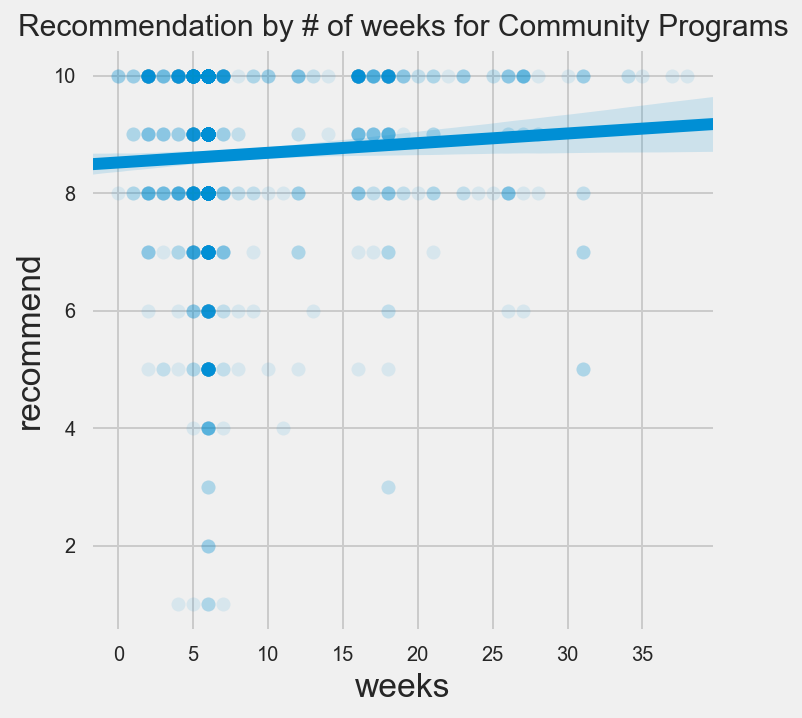

In [310]:
# plot of # of weeks vs. recommendation for all # of weeks
fig=plt.figure(figsize=(5,5))
plt.title('Recommendation by # of weeks for Community Programs',fontsize=15)
ax2= sns.regplot(data= community_1,x='weeks',y='recommend',scatter_kws={'alpha':0.1})

In [311]:
# just look for programs >4 weeks
# regression on weeks
community_1 = community[(community.weeks>4)]
regr2(community_1,'weeks').summary()

X shape: (1011, 1)
y shape: (1011,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     7.344
Date:                Tue, 05 Sep 2017   Prob (F-statistic):            0.00684
Time:                        16:51:47   Log-Likelihood:                -1973.3
No. Observations:                1011   AIC:                             3951.
Df Residuals:                    1009   BIC:                             3961.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4186      0.093     90.060      0.000       8.235       8.602
weeks          0.0234      0.009      2.710      0.007       0.006       0.040
==============================================================================
Omnibus:                      289.855   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              685.601
Skew:                          -1.547   Prob(JB):                    1.33e-149
Kurtosis:                       5.588   Cond. No.                         19.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

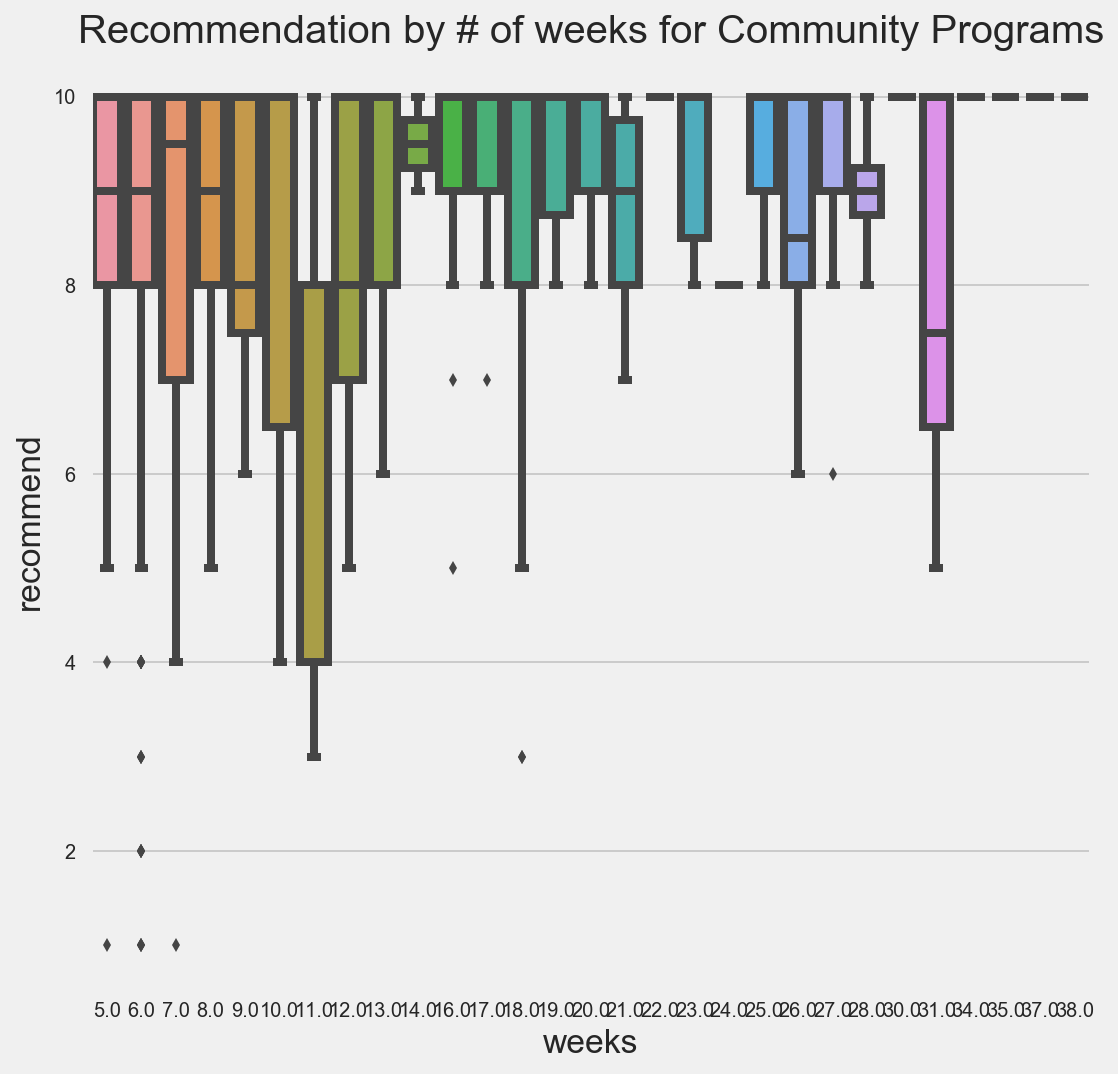

In [312]:
# for greater than 4 week community programs it appears that more weeks are slightly better
fig=plt.figure(figsize=(8,8))
plt.title('Recommendation by # of weeks for Community Programs',fontsize=20)
ax1= sns.boxplot(data= community_1,x='weeks',y='recommend')

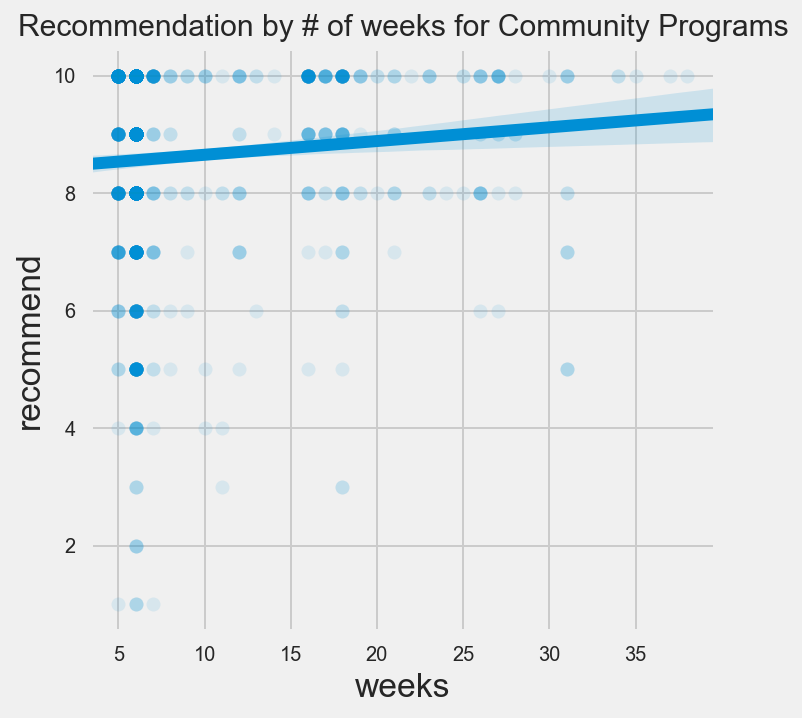

In [313]:
fig=plt.figure(figsize=(5,5))
plt.title('Recommendation by # of weeks for Community Programs',fontsize=15)
#ax2= sns.pairplot(data= community_1,x_vars='weeks',y_vars='recommend',size=6)
ax2= sns.regplot(data= community_1,x='weeks',y='recommend',scatter_kws={'alpha':0.1})


In [314]:
# Data at 6 weeks and 11 weeks show some low ratings, among others.   How many data
# points where there?
community_1.weeks.value_counts()
# most programs are 6 week

6.0     590
5.0     138
18.0     46
7.0      44
16.0     43
17.0     19
12.0     17
26.0     14
27.0     12
31.0     12
8.0      10
21.0     10
19.0      8
9.0       7
10.0      7
23.0      6
11.0      5
28.0      4
13.0      3
20.0      3
25.0      3
34.0      2
14.0      2
38.0      1
37.0      1
35.0      1
30.0      1
22.0      1
24.0      1
Name: weeks, dtype: int64

In [315]:
# Most summer programs are 8 or less weeks, while most weekend programs are 8 weeks or more
# Compare the recommendations for less than 8 weeks with for more than 8 weeks (leave out 8)
# Do same check for Crew vs. Corps
data1=community_1[community_1.weeks<8].recommend
data2=community_1[community_1.weeks>8].recommend
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.11210036880331242, pvalue=0.021672098162620518)

In [317]:
# 98% confidence that weekend programs (longer than 8 weeks), have higher recommendation 
# scores than summer programs (less then 8 weeks)

# Find average for more or less than 8 weeks
print data1.agg('mean')
print data2.agg('mean')

8.54663212435
8.89956331878


In [149]:
# look at organization that managed the project
regr2(community,'org_mng').summary()

X shape: (1062, 52)
y shape: (1062,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.486
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           8.63e-08
Time:                        14:00:25   Log-Likelihood:                -1920.8
No. Observations:                1062   AIC:                             3946.
Df Residuals:                    1010   BIC:                             4204.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                            9.3333      0.618     15.099      0.000       8.120      10.546
org_mng_Brashear Association                                                    -1.8333      0.977     -1.876      0.061      -3.751       0.085
org_mng_Camden Children's Garden                                                -0.3333      0.874     -0.381      0.703      -2.049       1.382
org_mng_Chequamegon-Nicolet National Forest                                     -0.0833      0.818     -0.102      0.919      -1.688       1.521
org_mng_Chicago Park District                                                    0.2667      0.917      0.291      0.771      -1.532       2.066
org_mng_Childrens Garden (Camden)                                               -0.9048      0.842     -1.074      0.283      -2.558       0.748
org_mng_City of Edmonds                                                         -0.7083      0.725     -0.977      0.329      -2.131       0.714
org_mng_City of Hyattsville Public Works                                         0.6667      1.635      0.408      0.684      -2.543       3.876
org_mng_City of Pittsburgh                                                      -1.7193      0.650     -2.646      0.008      -2.995      -0.444
org_mng_East Bay Regional Parks Department                                      -1.6667      0.701     -2.378      0.018      -3.042      -0.291
org_mng_Edwin B. Forsythe National Wildlife Refuge                              -0.3333      1.071     -0.311      0.756      -2.434       1.768
org_mng_Frederick Law Olmsted National Historic Site                            -0.8333      1.236     -0.674      0.500      -3.259       1.593
org_mng_Friends of Kenilworth Aquatic Gardens                                   -0.4242      0.768     -0.552      0.581      -1.932       1.084
org_mng_Friends of the Forest Preserves                                         -0.5215      0.636     -0.820      0.413      -1.770       0.727
org_mng_Friends of the Wissahickon                                              -1.4444      0.798     -1.810      0.071      -3.010       0.121
org_mng_George Washington Memorial Parkway                                      -0.2366      0.675     -0.350      0.726      -1.562       1.089
org_mng_Golden Gate National Recreation Area                                    -1.3333      0.818     -1.631      0.103      -2.938       0.271
org_mng_Great Swamp National Wildlife Refuge                                     0.3333      1.071      0.311      0.756      -1.768       2.434
org_mng_Greenbelt Park                

In [150]:
# when some organizations managed, recommendations were lower:
# NaN(blanks), City of Pittsburgh, NYC Department of Youth and Community Development
# East Bay Regional Parks Department (last one borderline if significant)

# look at # of data points
print 'City of Pittsburgh recommendation scores'
print community[community.org_mng=='City of Pittsburgh'].recommend.value_counts()
print 'NYC Department of Youth and Community Development recommendation scores'
print community[community.org_mng=='NYC Department of Youth and Community Development'].recommend.value_counts()
print 'East Bay Regional Parks Department recommendation scores'
print community[community.org_mng=='East Bay Regional Parks Department'].recommend.value_counts()
print 'Blank organization managed recommendation scores'
print community[community.org_mng.isnull()].recommend.value_counts()


City of Pittsburgh recommendation scores
9.0     13
8.0     12
5.0     10
10.0    10
7.0      8
2.0      1
3.0      1
4.0      1
6.0      1
Name: recommend, dtype: int64
NYC Department of Youth and Community Development recommendation scores
10.0    4
8.0     2
4.0     2
7.0     2
6.0     1
3.0     1
9.0     1
Name: recommend, dtype: int64
East Bay Regional Parks Department recommendation scores
10.0    7
8.0     4
7.0     3
9.0     2
4.0     2
1.0     1
5.0     1
6.0     1
Name: recommend, dtype: int64
Blank organization managed recommendation scores
10.0    30
8.0     17
9.0     14
5.0     12
7.0      9
6.0      7
4.0      5
1.0      4
2.0      1
Name: recommend, dtype: int64


In [151]:
# look at city.  Likely to get similar results to organization managed
regr2(community,'loc_city').summary()

X shape: (1141, 57)
y shape: (1141,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     3.218
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           1.54e-13
Time:                        14:00:25   Log-Likelihood:                -2131.3
No. Observations:                1141   AIC:                             4377.
Df Residuals:                    1084   BIC:                             4664.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           10.0000      1.137      8.799      0.000       7.770      12.230
loc_city_Ashford                -0.1538      1.221     -0.126      0.900      -2.549       2.242
loc_city_Baltimore              -2.5000      1.192     -2.097      0.036      -4.839      -0.161
loc_city_Barrington             -1.2000      1.245     -0.964      0.335      -3.643       1.243
loc_city_Basking Ridge          -0.3333      1.467     -0.227      0.820      -3.212       2.546
loc_city_Bethlehem              -1.6250      1.271     -1.279      0.201      -4.118       0.868
loc_city_Bladensburg            -0.6667      1.312     -0.508      0.612      -3.242       1.908
loc_city_Broad Run              -0.1429      1.289     -0.111      0.912      -2.672       2.386
loc_city_Brookline              -1.5000      1.607     -0.933      0.351      -4.654       1.654
loc_city_Brooklyn               -1.1525      1.156     -0.997      0.319      -3.420       1.115
loc_city_Camden                 -1.3077      1.221     -1.071      0.284      -3.703       1.088
loc_city_Chicago                -0.8649      1.167     -0.741      0.459      -3.154       1.425
loc_city_Clinton                -0.2500      1.392     -0.180      0.858      -2.981       2.481
loc_city_Columbia               -0.1667      1.312     -0.127      0.899      -2.742       2.408
loc_city_Concord                -1.5000      1.271     -1.180      0.238      -3.993       0.993
loc_city_Detroit                -0.3750      1.172     -0.320      0.749      -2.674       1.924
loc_city_Edmonds                -1.3750      1.205     -1.141      0.254      -3.740       0.990
loc_city_Gallitzin           -1.332e-14      1.607  -8.29e-15      1.000      -3.154       3.154
loc_city_Galloway               -1.0000      1.467     -0.682      0.496      -3.879       1.879
loc_city_Glencoe                -0.8333      1.312     -0.635      0.526      -3.408       1.742
loc_city_Greenbelt              -0.2667      1.210     -0.220      0.826      -2.641       2.107
loc_city_Harrisburg             -1.6000      1.345     -1.190      0.234      -4.239       1.039
loc_city_Hodgkins               -0.5556      1.257     -0.442      0.658      -3.021       1.910
loc_city_Houston                -0.9667      1.155     -0.837      0.403      -3.234       1.300
loc_city_Humble                 -1.0000      1.312     -0.762      0.446      -3.575       1.575
loc_city_Hyattsville          1.954e-14      1.969   9.93e-15      1.000      -3.863       3.863
loc_city_Jersey City            -1.0000      1.607     -0.622      0.534      -4.154       2.154
loc_city_Johnstown           -1.155e-14      1.607  -7.18e-15      1.000      -3.154       3.154
loc_city_King of Prussia        -1.7619      1.189     -1.481      0.139    

In [152]:
# cities with lower recommendation scores:
# Pittsburgh - 320 data points.   Several different organizations managed:
#       City of Pittsburgh, Student Conservation Association, blank (no response), and 3 others
# Lebanon - only 6 data points.   Org managed was NJ State Parks
# Baltimore - 20 data points.   Org managed was Student Conservation Association.   
#             2 start dates - one in 2015 and one in 2016.
# Not New York

In [153]:
# look at position title.   This breaks down city and organization managed more
regr2(community,'pos_tit').summary()

X shape: (1161, 230)
y shape: (1161,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     1.999
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           6.25e-13
Time:                        14:00:25   Log-Likelihood:                -2022.3
No. Observations:                1161   AIC:                             4505.
Df Residuals:                     931   BIC:                             5668.
Df Model:                         229                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                             10.0000      1.091      9.169      0.000       7.860      12.140
pos_tit_"GIS" SMC SY Community Crew2 2015-2016                                                    -0.3333      1.408     -0.237      0.813      -3.097       2.430
pos_tit_"Traditional" SMC SY Community Crew1 2015-2016                                         -6.217e-15      1.259  -4.94e-15      1.000      -2.471       2.471
pos_tit_(Crew 1) Theodore Stone Forest Preserve                                                   -0.5556      1.206     -0.461      0.645      -2.922       1.811
pos_tit_(Crew 2) Crabtree Nature Center                                                           -1.3750      1.219     -1.128      0.260      -3.768       1.018
pos_tit_(Crew 3) River Trail Nature Center                                                        -2.0000      1.219     -1.640      0.101      -4.393       0.393
pos_tit_(Crew 4) Sand Ridge Nature Center                                                         -2.2000      1.195     -1.841      0.066      -4.545       0.145
pos_tit_(Crew 5) Dan Ryan Woods                                                                   -1.0000      1.237     -0.809      0.419      -3.427       1.427
pos_tit_(Crew 6) Trailside Museum/Thatcher Woods                                                  -1.4286      1.237     -1.155      0.248      -3.856       0.998
pos_tit_(Crew 7) Chicago Botanic Garden                                                           -1.5000      1.542     -0.973      0.331      -4.527       1.527
pos_tit_16 Newark Commuting Crew                                                                  -1.3333      1.259     -1.059      0.290      -3.805       1.138
pos_tit_2015 -Eastwick - John Heinz Community Crew 3                                              -2.0000      1.290     -1.550      0.122      -4.533       0.533
pos_tit_2015 Baltimore Community Crew - Farm Team                                                 -1.0000      1.336     -0.749      0.454      -3.621       1.621
pos_tit_2015 Baltimore Community Crew - Gwynns Falls                                              -2.0000      1.542     -1.297      0.195      -5.027       1.027
pos_tit_2015 Baltimore Community Crew - Herring Run                                               -1.5000      1.336     -1.123      0.262      -4.121       1.121
pos_tit_2015 Baltimore Community Crew - Storm Water Management                                    -5.5000      1.542     -3.566      0.000      -8.52

In [154]:
# Crews with significantly worse ratings - # of Pittsburgh crews stands out
# Baltimore Community Crew - Storm Water Management
# 2015 NYC High School Community Fall Intern Team
# 2016 Baltimore Community Crew - Farm Team
# 2017 SMC Summer Crew South
# FY16 EBRPD Summer Crew 1 Richmond
# FY16 EBRPD Summer Crew 2 Oakland
# Fall-Winter 2015-16 YAIP Crew
# Friends of the Wissahickon (FOW) 2015
# John Heinz (Kingsessing/Eastwick) School Year Community Crew 1-Eastwick
# NAC Summer Crew 2016
# NJ Community Roving Crew
# NYC SYEP Crew 2015
# Northwest CP- Seattle Crew 3 - FY17
# Peninsula Summer Crew GGNRA
# Pittsburgh Summer: Emerald View/McKinley
# Pittsburgh Summer: Frick
# Pittsburgh Summer: Highland
# Pittsburgh Summer: Point Park & Emerald View Park
# Pittsburgh Summer: Riverview
# Pittsburgh Summer: Roving Crew
# Pittsburgh Summer: Schenley
# Pittsburgh Summer: Southside
# SMC School Year Crew 3 2016_Team Green
# South Side Park Spring Crew
# Spring 2017 YAIP Crew

In [155]:
# look at all crews in Pittsburgh.   See if difference in organization managed
regr2(community[(community.loc_city=='Pittsburgh')],'org_mng').summary()

X shape: (80, 4)
y shape: (80,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.224
Date:                Tue, 05 Sep 2017   Prob (F-statistic):             0.0922
Time:                        14:00:25   Log-Likelihood:                -161.04
No. Observations:                  80   AIC:                             330.1
Df Residuals:                      76   BIC:                             339.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                            7.5000      0.929      8.072      0.000       5.649       9.351
org_mng_City of Pittsburgh                                                       0.1140      0.961      0.119      0.906      -1.800       2.028
org_mng_Pennsylvania Department of Conservation and Natural Resources (DCNR)     2.5000      1.419      1.761      0.082      -0.327       5.327
org_mng_SCA Three Rivers Regional Office                                         0.9375      1.039      0.902      0.370      -1.131       3.006
org_mng_nan                                                                           0          0        nan        nan           0           0
==============================================================================
Omnibus:                        8.171   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.163
Skew:                          -0.779   Prob(JB):                       0.0169
Kurtosis:                       3.147   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [156]:
# For projects in Pittsburgh, no statistical difference between organization managers


In [157]:
# look at job title.   Most are 'crew member' but there are a few others
regr2(community,'job_title').summary()

X shape: (1116, 4)
y shape: (1116,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.483
Date:                Tue, 05 Sep 2017   Prob (F-statistic):             0.0595
Time:                        14:00:25   Log-Likelihood:                -2161.9
No. Observations:                1116   AIC:                             4332.
Df Residuals:                    1112   BIC:                             4352.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               10.0000      0.841     11.890      0.000       8.350      11.650
job_title_Crew Leader Apprentice    -0.8095      0.880     -0.920      0.358      -2.537       0.917
job_title_Crew Member               -1.3583      0.843     -1.612      0.107      -3.012       0.295
job_title_Program Assistant      -2.487e-14      1.881  -1.32e-14      1.000      -3.690       3.690
job_title_nan                             0          0        nan        nan           0           0
==============================================================================
Omnibus:                      337.825   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              865.654
Skew:                          -1.598   Prob(JB):                    1.06e-188
Kurtosis:                       5.899   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [158]:
# job title doesn't matter

In [159]:
# look at opening status (op_stat).   Most are 'Out of the field', but a few others
regr2(community,'op_stat').summary()

X shape: (1161, 3)
y shape: (1161,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.145
Date:                Tue, 05 Sep 2017   Prob (F-statistic):             0.0161
Time:                        14:00:25   Log-Likelihood:                -2250.3
No. Observations:                1161   AIC:                             4507.
Df Residuals:                    1158   BIC:                             4522.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         8.7500      0.842     10.398      0.000       7.099      10.401
op_stat_Field Preparation    -2.5000      1.190     -2.101      0.036      -4.835      -0.165
op_stat_Out of the Field     -0.0744      0.843     -0.088      0.930      -1.728       1.580
op_stat_nan                        0          0        nan        nan           0           0
==============================================================================
Omnibus:                      346.694   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              879.778
Skew:                          -1.583   Prob(JB):                    9.09e-192
Kurtosis:                       5.858   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [160]:
# nothing of interest in opening status - only 7 point in 'field preparation'

In [161]:
# look at Median Income of the zip codes that the participants are from
# divide income by 1000 so easier to work with
community_1 = community
community_1['income']=community_1.income/1000
regr2(community_1,'income').summary()

X shape: (1134, 1)
y shape: (1134,)


/Users/matthewterribile/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     13.58
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           0.000240
Time:                        14:00:25   Log-Likelihood:                -2200.3
No. Observations:                1134   AIC:                             4405.
Df Residuals:                    1132   BIC:                             4415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3174      0.106     78.370      0.000       8.109       8.526
income         0.0058      0.002      3.685      0.000       0.003       0.009
==============================================================================
Omnibus:                      340.284   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              865.107
Skew:                          -1.588   Prob(JB):                    1.39e-188
Kurtosis:                       5.866   Cond. No.                         142.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

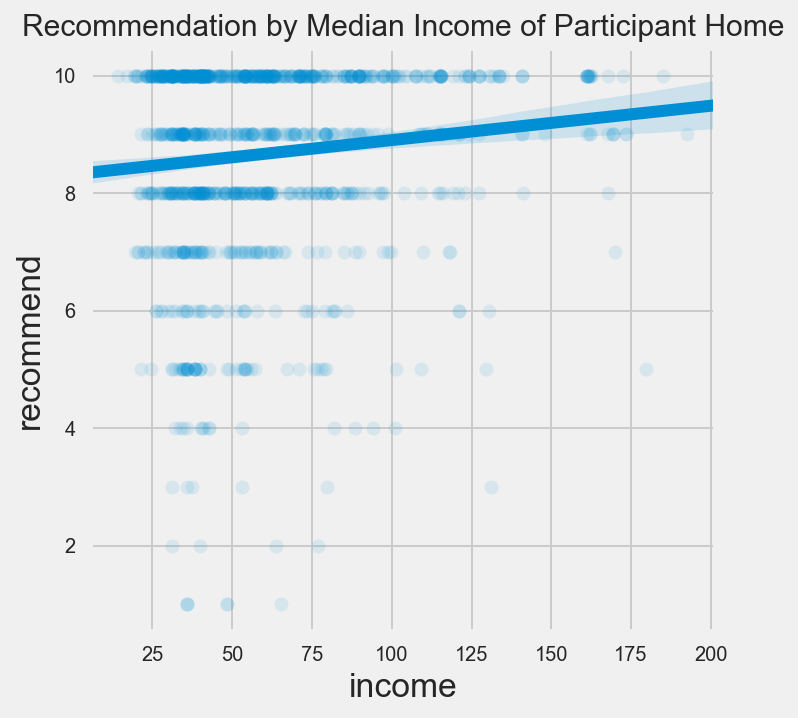

In [162]:
# Strong evidence that participants from higher income neighborhoods give 
# higher recommendation scores.   But, by itself only predicts small amount of 
# recommendation score
fig=plt.figure(figsize=(5,5))
plt.title('Recommendation by Median Income of Participant Home',fontsize=15)
ax2= sns.regplot(data= community_1,x='income',y='recommend',scatter_kws={'alpha':0.1})

In [163]:
# Look at other income / poverty related factors to see if similar pattern

# Look at % of people on SNAP in home zip code
#regr2(community,'SNAP').summary()

regr_cols = ['SNAP','recommend']
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]

# set X and y variables and do StatsModel linear regression
X=community_1['SNAP']
y=community_1['recommend']
print X.shape
print y.shape

X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(1134,)
(1134,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.678
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.195
Time:                        14:00:26   Log-Likelihood:                -2206.2
No. Observations:                1134   AIC:                             4416.
Df Residuals:                    1132   BIC:                             4427.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7571      0.089     98.547      0.000       8.583       8.931
SNAP          -0.0050      0.004     -1.295      0.195      -0.012       0.003
==============================================================================
Omnibus:                      344.046   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              879.024
Skew:                          -1.605   Prob(JB):                    1.33e-191
Kurtosis:                       5.881   Cond. No.                         41.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

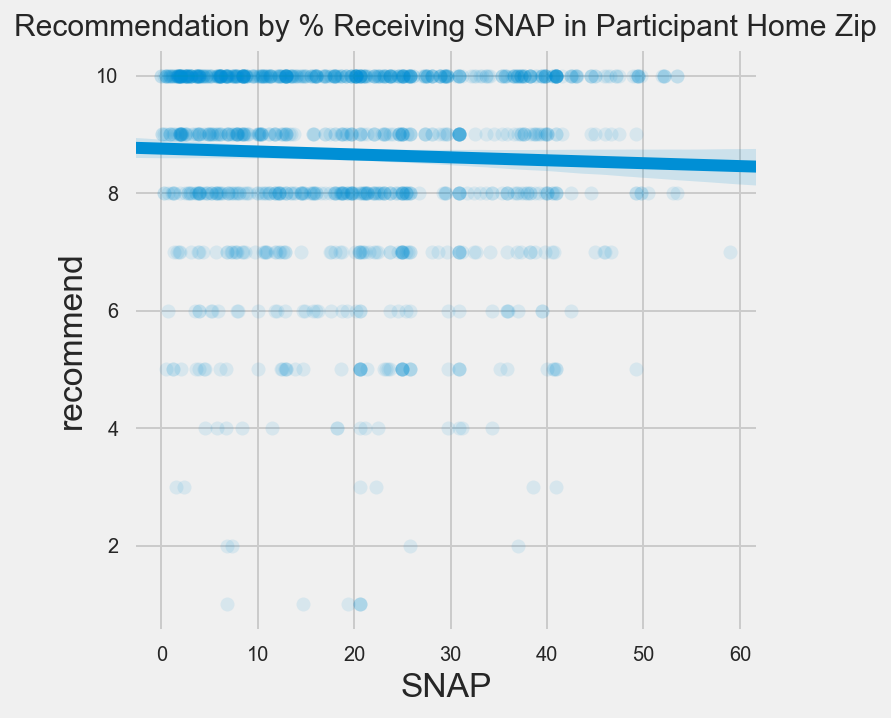

In [164]:
# % on SNAP not statistically significant 
fig=plt.figure(figsize=(5,5))
plt.title('Recommendation by % Receiving SNAP in Participant Home Zip',fontsize=15)
ax2= sns.regplot(data= community_1,x='SNAP',y='recommend',scatter_kws={'alpha':0.1})

In [165]:
# Look at % of people employed in home zip code
regr2(community,'employed').summary()

X shape: (1135, 1)
y shape: (1135,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.09814
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.754
Time:                        14:00:26   Log-Likelihood:                -2208.8
No. Observations:                1135   AIC:                             4422.
Df Residuals:                    1133   BIC:                             4432.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5182      0.466     18.270      0.000       7.603       9.433
employed       0.0022      0.007      0.313      0.754      -0.012       0.016
==============================================================================
Omnibus:                      344.430   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              877.802
Skew:                          -1.607   Prob(JB):                    2.44e-191
Kurtosis:                       5.869   Cond. No.                         609.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [166]:
# % employed is not statistically significant

# look at % with health insurance
regr2(community,'health_ins').summary()

X shape: (1135, 1)
y shape: (1135,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6144
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.433
Time:                        14:00:26   Log-Likelihood:                -2208.5
No. Observations:                1135   AIC:                             4421.
Df Residuals:                    1133   BIC:                             4431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1598      0.635     14.418      0.000       7.913      10.406
health_ins    -0.0057      0.007     -0.784      0.433      -0.020       0.009
==============================================================================
Omnibus:                      341.845   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              863.440
Skew:                          -1.599   Prob(JB):                    3.21e-188
Kurtosis:                       5.834   Cond. No.                     1.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [167]:
# % with health insurance in home zip code is not statistically significant

# look at % below poverty line
regr2(community,'poverty').summary()

X shape: (1134, 1)
y shape: (1134,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.070
Date:                Tue, 05 Sep 2017   Prob (F-statistic):             0.0800
Time:                        14:00:26   Log-Likelihood:                -2205.5
No. Observations:                1134   AIC:                             4415.
Df Residuals:                    1132   BIC:                             4425.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7939      0.090     97.249      0.000       8.617       8.971
poverty       -0.0085      0.005     -1.752      0.080      -0.018       0.001
==============================================================================
Omnibus:                      344.669   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              883.299
Skew:                          -1.606   Prob(JB):                    1.56e-192
Kurtosis:                       5.894   Cond. No.                         33.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

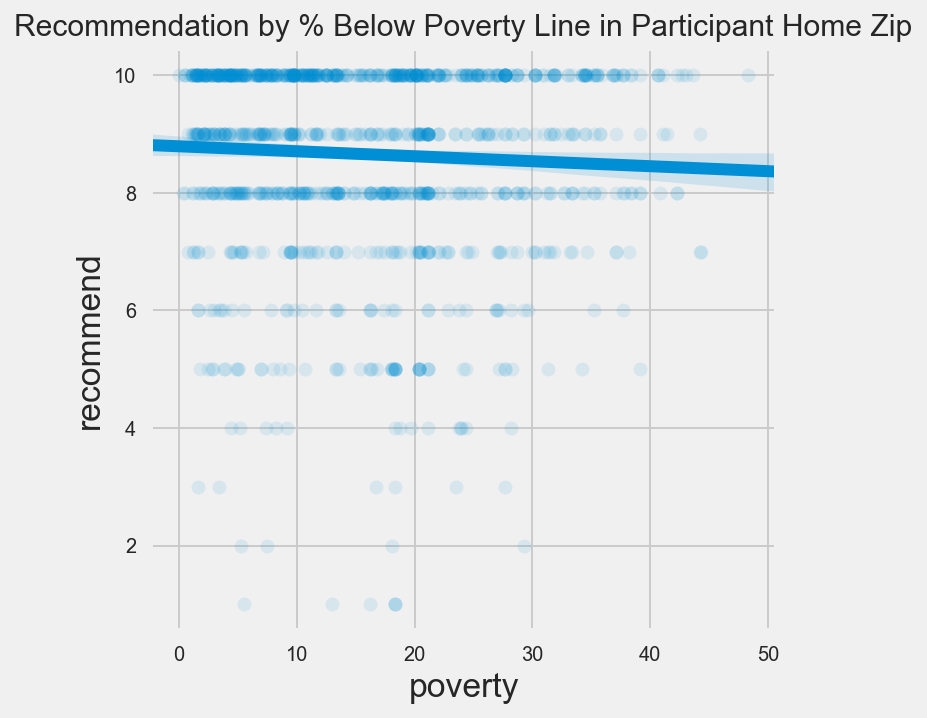

In [168]:
# % below the poverty line is significant at only about 92% level
fig=plt.figure(figsize=(5,5))
plt.title('Recommendation by % Below Poverty Line in Participant Home Zip',fontsize=15)
ax2= sns.regplot(data= community_1,x='poverty',y='recommend',scatter_kws={'alpha':0.1})

In [169]:
# However, combined with the median income, it seems that kids from poorer areas give
# lower recommendation scores.

In [170]:
community.budget_cd.value_counts()

255    197
254    166
267    122
309    121
253    107
252    103
268     98
260     66
258     64
265     43
263     32
310     17
262     12
312      8
210      2
110      1
Name: budget_cd, dtype: int64

In [171]:
# look if budget code has any correlation
regr2(community,'budget_cd').summary()

X shape: (1159, 16)
y shape: (1159,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     7.507
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           3.90e-16
Time:                        14:00:27   Log-Likelihood:                -2196.6
No. Observations:                1159   AIC:                             4425.
Df Residuals:                    1143   BIC:                             4506.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.0000      1.621      5.551      0.000       5.819      12.181
budget_cd_210    -0.5000      1.986     -0.252      0.801      -4.396       3.396
budget_cd_252    -0.2621      1.629     -0.161      0.872      -3.459       2.934
budget_cd_253    -0.3364      1.629     -0.207      0.836      -3.532       2.860
budget_cd_254    -1.3614      1.626     -0.837      0.403      -4.552       1.829
budget_cd_255     0.1371      1.625      0.084      0.933      -3.052       3.326
budget_cd_258     0.0625      1.634      0.038      0.969      -3.143       3.268
budget_cd_260     0.0152      1.634      0.009      0.993      -3.190       3.220
budget_cd_262    -1.0833      1.688     -0.642      0.521      -4.394       2.228
budget_cd_263     0.6250      1.647      0.380      0.704      -2.606       3.856
budget_cd_265    -0.3023      1.640     -0.184      0.854      -3.520       2.916
budget_cd_267    -0.1230      1.628     -0.076      0.940      -3.317       3.071
budget_cd_268    -0.5816      1.630     -0.357      0.721      -3.779       2.616
budget_cd_309    -0.4215      1.628     -0.259      0.796      -3.616       2.773
budget_cd_310     0.4118      1.668      0.247      0.805      -2.862       3.685
budget_cd_312    -0.5000      1.720     -0.291      0.771      -3.874       2.874
budget_cd_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      300.478   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              686.519
Skew:                          -1.418   Prob(JB):                    8.40e-150
Kurtosis:                       5.485   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [172]:
# budget code isn't significant indicator of recommendation score

In [173]:
# look if state member lives in has any correlation
regr2(community,'mem_st').summary()

X shape: (1161, 25)
y shape: (1161,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     3.700
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           5.83e-09
Time:                        14:00:27   Log-Likelihood:                -2210.8
No. Observations:                1161   AIC:                             4472.
Df Residuals:                    1136   BIC:                             4598.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6408      0.162     53.395      0.000       8.323       8.958
mem_st_CO      0.3592      1.650      0.218      0.828      -2.879       3.597
mem_st_CT      1.3592      1.173      1.159      0.247      -0.941       3.660
mem_st_DC      0.4746      0.279      1.699      0.090      -0.074       1.023
mem_st_IL      0.2442      0.224      1.091      0.275      -0.195       0.683
mem_st_IN     -0.6408      1.650     -0.388      0.698      -3.879       2.597
mem_st_MA     -0.3074      0.962     -0.320      0.749      -2.195       1.580
mem_st_MD      0.4426      0.226      1.957      0.051      -0.001       0.886
mem_st_MI      1.0063      0.325      3.098      0.002       0.369       1.644
mem_st_MO      1.3592      1.650      0.824      0.410      -1.879       4.597
mem_st_MT      1.3592      1.650      0.824      0.410      -1.879       4.597
mem_st_NAN     0.2481      0.420      0.591      0.554      -0.575       1.071
mem_st_NC      1.3592      1.650      0.824      0.410      -1.879       4.597
mem_st_NH     -0.1408      0.603     -0.234      0.815      -1.323       1.042
mem_st_NJ      0.0951      0.278      0.342      0.732      -0.450       0.640
mem_st_NM      1.3592      1.173      1.159      0.247      -0.941       3.660
mem_st_NY     -0.1538      0.223     -0.690      0.490      -0.591       0.283
mem_st_OR     -3.6408      1.650     -2.206      0.028      -6.879      -0.403
mem_st_PA     -0.6259      0.190     -3.289      0.001      -0.999      -0.253
mem_st_TX      0.3895      0.259      1.504      0.133      -0.119       0.898
mem_st_USA    -1.6408      1.650     -0.994      0.320      -4.879       1.597
mem_st_UT      1.3592      1.650      0.824      0.410      -1.879       4.597
mem_st_VA      0.3592      0.298      1.205      0.229      -0.226       0.944
mem_st_WA      0.0461      0.231      0.199      0.842      -0.407       0.500
mem_st_WI      0.3746      0.260      1.440      0.150      -0.136       0.885
mem_st_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      323.719   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              803.942
Skew:                          -1.482   Prob(JB):                    2.67e-175
Kurtosis:                       5.799   Cond. No.                     1.05e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.16e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [174]:
# People from these states give higher recommendations: MD, MI
# People from these states give lower recommendations: OR, PA

In [175]:
community.columns

Index([u'op_id', u'budget_cd', u'q76', u'q85a', u'q85b', u'q85c', u'q85d',
       u'q85e', u'q85f', u'q86', u'q88a', u'q88b', u'q88c', u'q93a', u'q93b',
       u'q93c', u'q93d', u'q93e', u'q94a', u'q94b', u'q94c', u'q95a', u'q95b',
       u'q95c', u'q95d', u'q97a', u'q97b', u'q97c', u'q97d', u'q97e', u'q97f',
       u'q98a', u'q98b', u'q98c', u'q98d', u'q98e', u'q98f', u'q98g', u'q98h',
       u'q99a', u'q99b', u'q99c', u'q100', u'recommend', u'pos_tit',
       u'org_mng', u'loc_city', u'loc_zip', u'op_stat', u'job_title', u'weeks',
       u'mem_city', u'mem_st', u'mem_zip', u'ethnicity', u'ethnicity_code',
       u'educ_lev', u'age', u'gender', u'loc_st', u'start_dt', u'end_dt',
       u'employed', u'SNAP', u'health_ins', u'poverty', u'income'],
      dtype='object')

In [176]:
# Run regression together on all the fields that seemed significant
# Where fields overlap, choose the most significant
# Don't include other survey questions
regr_cols = ['ethnicity_code','age','weeks','income','loc_city','mem_st','recommend']
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]
community_1 = community_1[regr_cols]

# get dummy variables for selected non quantitative answers
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
print community_1.shape

# set X and y variables and do StatsModel linear regression
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(1114, 92)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     2.483
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           6.45e-11
Time:                        14:00:27   Log-Likelihood:                -2071.2
No. Observations:                1114   AIC:                             4308.
Df Residuals:                    1031   BIC:                             4725.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            8.5816      0.400     21.456      0.000       7.797       9.366
age                              0.1735      0.085      2.046      0.041       0.007       0.340
weeks                            0.0098      0.010      1.012      0.312      -0.009       0.029
income                           0.0002      0.002      0.064      0.949      -0.005       0.005
ethnicity_code_B                -0.3027      0.174     -1.735      0.083      -0.645       0.040
ethnicity_code_H                -0.1099      0.197     -0.558      0.577      -0.496       0.276
ethnicity_code_I                -0.2420      0.852     -0.284      0.777      -1.915       1.431
ethnicity_code_U                -0.5938      0.239     -2.487      0.013      -1.062      -0.125
ethnicity_code_W                -0.0587      0.188     -0.312      0.755      -0.428       0.310
ethnicity_code_nan           -4.726e-15   3.57e-15     -1.323      0.186   -1.17e-14    2.28e-15
loc_city_Ashford                 2.4941      1.465      1.703      0.089      -0.381       5.369
loc_city_Baltimore              -2.2063      0.884     -2.495      0.013      -3.941      -0.471
loc_city_Barrington             -0.1574      0.555     -0.284      0.777      -1.246       0.931
loc_city_Basking Ridge           0.7820      1.093      0.715      0.475      -1.363       2.927
loc_city_Bethlehem              -0.6023      0.867     -0.695      0.487      -2.303       1.099
loc_city_Bladensburg            -0.3802      1.071     -0.355      0.723      -2.483       1.722
loc_city_Broad Run               0.2619      1.028      0.255      0.799      -1.756       2.279
loc_city_Brookline              -0.6546      2.140     -0.306      0.760      -4.855       3.545
loc_city_Brooklyn                1.4977      0.774      1.936      0.053      -0.020       3.016
loc_city_Camden                 -0.0270      0.833     -0.032      0.974      -1.661       1.607
loc_city_Chicago                 0.0856      0.335      0.255      0.798      -0.572       0.743
loc_city_Clinton                 0.8351      1.031      0.810      0.418      -1.189       2.859
loc_city_Columbia                0.2248      0.891      0.252      0.801      -1.524       1.974
loc_city_Concord                -0.1508      0.324     -0.466      0.641      -0.786       0.484
loc_city_Detroit                -0.1370      1.774     -0.077      0.938      -3.618       3.344
loc_city_Edmonds                 1.1909      1.443      0.825      0.409      -1.640       4.022
loc_city_Gallitzin               1.3310      1.286      1.035      0.301      -1.192       3.854
loc_city_Galloway            -3.654e-05      1.147  -3.19e-05      1.000      -2.251       2.251
loc_city_Glencoe                 0.3636      0.656      0.554      0.580    

In [177]:
# Income, member's state, and city location don't seem to add much.   Try removing them

regr_cols = ['ethnicity_code','age','weeks','recommend']
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]
community_1 = community_1[regr_cols]

# get dummy variables for selected non quantitative answers
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
print community_1.shape

# set X and y variables and do StatsModel linear regression
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()


(1161, 9)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     5.302
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           5.56e-06
Time:                        14:00:27   Log-Likelihood:                -2236.1
No. Observations:                1161   AIC:                             4488.
Df Residuals:                    1153   BIC:                             4529.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.2893      0.186     44.523      0.000       7.924       8.655
age                    0.3043      0.073      4.149      0.000       0.160       0.448
weeks                  0.0164      0.008      2.041      0.042       0.001       0.032
ethnicity_code_B      -0.2815      0.160     -1.755      0.080      -0.596       0.033
ethnicity_code_H       0.1293      0.179      0.722      0.471      -0.222       0.481
ethnicity_code_I       0.1722      0.845      0.204      0.839      -1.486       1.830
ethnicity_code_U      -0.4673      0.220     -2.123      0.034      -0.899      -0.035
ethnicity_code_W       0.0096      0.174      0.055      0.956      -0.331       0.350
ethnicity_code_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      341.389   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              858.996
Skew:                          -1.561   Prob(JB):                    2.96e-187
Kurtosis:                       5.830   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [178]:
# Much lower R squared (maybe overfitting with all the variables) but everything appears
# significant.

In [179]:
# Add in income 
regr_cols = ['ethnicity_code','age','weeks','recommend','income']
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]
community_1 = community_1[regr_cols]

# get dummy variables for selected non quantitative answers
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
print community_1.shape

# set X and y variables and do StatsModel linear regression
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(1134, 10)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.607
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           5.44e-07
Time:                        14:00:27   Log-Likelihood:                -2184.9
No. Observations:                1134   AIC:                             4388.
Df Residuals:                    1125   BIC:                             4433.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.9928      0.216     37.068      0.000       7.570       8.416
age                    0.3110      0.076      4.096      0.000       0.162       0.460
weeks                  0.0145      0.008      1.791      0.074      -0.001       0.030
income                 0.0047      0.002      2.714      0.007       0.001       0.008
ethnicity_code_B      -0.2061      0.164     -1.254      0.210      -0.529       0.116
ethnicity_code_H       0.1687      0.180      0.938      0.349      -0.184       0.522
ethnicity_code_I       0.0312      0.848      0.037      0.971      -1.632       1.695
ethnicity_code_U      -0.5093      0.231     -2.209      0.027      -0.962      -0.057
ethnicity_code_W      -0.0726      0.176     -0.412      0.680      -0.418       0.273
ethnicity_code_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      333.490   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              839.013
Skew:                          -1.560   Prob(JB):                    6.47e-183
Kurtosis:                       5.832   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [180]:
# Income is significant without member's home state and location, but makes race less 
# significant.

In [181]:
# Try removing ethnicity but including income
regr_cols = ['age','weeks','recommend','income']
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]
community_1 = community_1[regr_cols]

# get dummy variables for selected non quantitative answers
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
print community_1.shape

# set X and y variables and do StatsModel linear regression
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(1134, 4)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     10.56
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           7.54e-07
Time:                        14:00:27   Log-Likelihood:                -2191.4
No. Observations:                1134   AIC:                             4391.
Df Residuals:                    1130   BIC:                             4411.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8864      0.149     53.095      0.000       7.595       8.178
age            0.3032      0.076      4.011      0.000       0.155       0.452
weeks          0.0131      0.008      1.618      0.106      -0.003       0.029
income         0.0052      0.002      3.290      0.001       0.002       0.008
==============================================================================
Omnibus:                      346.040   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              904.197
Skew:                          -1.601   Prob(JB):                    4.53e-197
Kurtosis:                       5.980   Cond. No.                         212.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [182]:
# Income is not quite as good a predictor as ethnicity.  

# Try putting in % below poverty line instead
regr_cols = ['poverty','age','weeks','recommend']
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]
community_1 = community_1[regr_cols]

# get dummy variables for selected non quantitative answers
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
print community_1.shape

# set X and y variables and do StatsModel linear regression
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(1134, 4)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     7.578
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           5.09e-05
Time:                        14:00:27   Log-Likelihood:                -2195.8
No. Observations:                1134   AIC:                             4400.
Df Residuals:                    1130   BIC:                             4420.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2724      0.151     54.862      0.000       7.977       8.568
poverty       -0.0069      0.005     -1.431      0.153      -0.016       0.003
age            0.3123      0.076      4.116      0.000       0.163       0.461
weeks          0.0154      0.008      1.901      0.058      -0.000       0.031
==============================================================================
Omnibus:                      349.194   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              916.590
Skew:                          -1.615   Prob(JB):                    9.23e-200
Kurtosis:                       5.995   Cond. No.                         64.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [183]:
# Poverty continues to be not as good a predictor as income or ethnicity.

# Try city instead
regr_cols = ['loc_city','age','weeks','recommend']
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]
community_1 = community_1[regr_cols]

# get dummy variables for selected non quantitative answers
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
print community_1.shape

# set X and y variables and do StatsModel linear regression
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(1141, 60)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     3.207
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           8.05e-14
Time:                        14:00:27   Log-Likelihood:                -2128.5
No. Observations:                1141   AIC:                             4375.
Df Residuals:                    1082   BIC:                             4672.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            9.8092      1.138      8.619      0.000       7.576      12.042
age                              0.1530      0.078      1.965      0.050       0.000       0.306
weeks                            0.0126      0.009      1.338      0.181      -0.006       0.031
loc_city_Ashford                -0.1648      1.219     -0.135      0.893      -2.557       2.227
loc_city_Baltimore              -2.5558      1.191     -2.147      0.032      -4.892      -0.220
loc_city_Barrington             -1.2391      1.244     -0.996      0.319      -3.679       1.201
loc_city_Basking Ridge          -0.7540      1.480     -0.509      0.611      -3.658       2.150
loc_city_Bethlehem              -1.7584      1.270     -1.384      0.167      -4.251       0.734
loc_city_Bladensburg            -0.7174      1.311     -0.547      0.584      -3.289       1.854
loc_city_Broad Run              -0.4453      1.306     -0.341      0.733      -3.009       2.118
loc_city_Brookline              -1.5630      1.606     -0.973      0.331      -4.713       1.587
loc_city_Brooklyn               -1.3521      1.158     -1.168      0.243      -3.624       0.920
loc_city_Camden                 -1.3455      1.219     -1.103      0.270      -3.738       1.047
loc_city_Chicago                -0.9659      1.166     -0.828      0.408      -3.254       1.322
loc_city_Clinton                -0.3261      1.390     -0.235      0.815      -3.054       2.402
loc_city_Columbia               -0.2981      1.312     -0.227      0.820      -2.872       2.276
loc_city_Concord                -1.5608      1.269     -1.230      0.219      -4.052       0.930
loc_city_Detroit                -0.4631      1.171     -0.396      0.693      -2.761       1.834
loc_city_Edmonds                -1.4423      1.204     -1.198      0.231      -3.805       0.920
loc_city_Gallitzin              -0.0504      1.605     -0.031      0.975      -3.200       3.100
loc_city_Galloway               -1.1140      1.466     -0.760      0.448      -3.991       1.763
loc_city_Glencoe                -0.9008      1.311     -0.687      0.492      -3.473       1.671
loc_city_Greenbelt              -0.3987      1.212     -0.329      0.742      -2.776       1.979
loc_city_Harrisburg             -1.6684      1.343     -1.242      0.214      -4.304       0.967
loc_city_Hodgkins               -0.6288      1.255     -0.501      0.617      -3.092       1.834
loc_city_Houston                -1.0201      1.154     -0.884      0.377      -3.284       1.244
loc_city_Humble                 -1.0258      1.311     -0.783      0.434      -3.598       1.546
loc_city_Hyattsville            -0.1656      1.967     -0.084      0.933      -4.026       3.694
loc_city_Jersey City            -1.0378      1.605     -0.647      0.518    

In [184]:
# City is a better predictor than ethnicity or income or poverty.
# This isn't surprising as it gets 'dummied' into more variables giving more opportunity
# to overfit

In [185]:
# Get an idea of how accurate our model is

In [186]:
# Do a train-test split to see if are indeed overfit
# Will need to use SKLearn vs. StatsModel

regr_cols = ['loc_city','age','weeks','recommend']
# remove rows with nulls
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]
# remove columns not regressing on
community_1 = community_1[regr_cols]
# add dummies as needed
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
# set up X and y
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']
# do train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.35)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# model on train and then predict on test using sklearn
# Use Logistic Regression since recommend values are whole numbers
lm=linear_model.LogisticRegression()
model = lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
model.score(X_test, y_test)  


(741, 59)
(400, 59)
(741,)
(400,)


0.45250000000000001

In [187]:
# Rerun with ethnicity instead of city

regr_cols = ['ethnicity','age','weeks','recommend']
# remove rows with nulls
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]
# remove columns not regressing on
community_1 = community_1[regr_cols]
# add dummies as needed
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
# set up X and y
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']
# do train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.35)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# model on train and then predict on test using sklearn
lm=linear_model.LogisticRegression()
model = lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
model.score(X_test, y_test)

(731, 38)
(395, 38)
(731,)
(395,)


0.44556962025316454

In [188]:
# Rerun with median income instead of ethnicity

regr_cols = ['income','age','weeks','recommend']
# remove rows with nulls
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]
# remove columns not regressing on
community_1 = community_1[regr_cols]
# add dummies as needed
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
# set up X and y
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']
# do train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.35)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# model on train and then predict on test using sklearn
lm=linear_model.LogisticRegression()
model = lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
model.score(X_test, y_test)

(737, 3)
(397, 3)
(737,)
(397,)


0.41813602015113349

In [189]:
# Slightly better (but not a lot) than ethnicity.   


In [190]:
# Try with income and ethnicity 

regr_cols = ['income','ethnicity','age','weeks','recommend']
# remove rows with nulls
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]
# remove columns not regressing on
community_1 = community_1[regr_cols]
# add dummies as needed
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
# set up X and y
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']
# do train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.35)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# model on train and then predict on test using sklearn
lm=linear_model.LogisticRegression()
model = lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
model.score(X_test, y_test)

(722, 39)
(389, 39)
(722,)
(389,)


0.45244215938303339

In [191]:
# Try adding city also with income and ethnicity 

regr_cols = ['loc_city','income','ethnicity','age','weeks','recommend']
# remove rows with nulls
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]
# remove columns not regressing on
community_1 = community_1[regr_cols]
# add dummies as needed
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
# set up X and y
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']
# do train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.35)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# model on train and then predict on test using sklearn
lm=linear_model.LogisticRegression()
model = lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
model.score(X_test, y_test)

(709, 96)
(382, 96)
(709,)
(382,)


0.39790575916230364

In [192]:
# Score drops - likely overfitting the model

In [193]:
# Try similar with sklearn Random Forest, with cross validation 
rfc = RandomForestClassifier(verbose=1)       #initialize

# setup columns and rows as above
regr_cols = ['ethnicity','age','recommend']
# remove rows with nulls
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]
# remove columns not regressing on
community_1 = community_1[regr_cols]
# add dummies as needed
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
# set up X and y
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']

# fit model
model_rf= rfc.fit(X,y)                
# Do cross validation and summarize the scores
rfscores=cross_val_score(model_rf,X,y,cv=3)
print rfscores
print "{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", rfscores.mean().round(3), rfscores.std().round(3))


[ 0.43799472  0.448       0.41935484]
Random Forest Score:	0.435 ± 0.012


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [194]:
# Tried above with income or location city instead of ethnicity.   
# Those models have less accuracy.
# Putting in 2 of the 3 or all 3 of those doesn't improve the model.
# Adding weeks reduces accuracy of model.
# Conclusion - can probably predict recommendations with 35 - 45% accuracy with above variables.
# This is not strong predictive power since about 45% of scores are 10
community.recommend.value_counts()
print '% 10 score = '+str(round(((522./1169)*100.),1))

% 10 score = 44.7


In [195]:
community.columns

Index([u'op_id', u'budget_cd', u'q76', u'q85a', u'q85b', u'q85c', u'q85d',
       u'q85e', u'q85f', u'q86', u'q88a', u'q88b', u'q88c', u'q93a', u'q93b',
       u'q93c', u'q93d', u'q93e', u'q94a', u'q94b', u'q94c', u'q95a', u'q95b',
       u'q95c', u'q95d', u'q97a', u'q97b', u'q97c', u'q97d', u'q97e', u'q97f',
       u'q98a', u'q98b', u'q98c', u'q98d', u'q98e', u'q98f', u'q98g', u'q98h',
       u'q99a', u'q99b', u'q99c', u'q100', u'recommend', u'pos_tit',
       u'org_mng', u'loc_city', u'loc_zip', u'op_stat', u'job_title', u'weeks',
       u'mem_city', u'mem_st', u'mem_zip', u'ethnicity', u'ethnicity_code',
       u'educ_lev', u'age', u'gender', u'loc_st', u'start_dt', u'end_dt',
       u'employed', u'SNAP', u'health_ins', u'poverty', u'income'],
      dtype='object')

In [196]:
# Try another approach to see if get similar results
# Do logistic regression with Lasso regularization to automatically reduce features

regr_cols = ['loc_city','income','ethnicity','age','weeks','recommend','org_mng',
            'gender', 'mem_st','budget_cd']
# remove rows with nulls
#community_1=community[(community.isnull().sum(axis=1)==0)]
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]

# remove columns not regressing on
community_1 = community_1[regr_cols]

# add dummies as needed
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)
# set up X and y
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']


# model using sklearn with L1 regression to do feature selection in a different way
lm=linear_model.LogisticRegression(penalty='l1',C=0.1)
model = lm.fit(X,y)
y_pred=lm.predict(X)
print model.score(X, y)
#model.coef_

# Put coefficients into readable format
#coeff_vals = pd.DataFrame(lm.coef_.transpose(),index = X.columns,columns=['weights']).sort_values('weights',ascending=False)
coeff_vals = pd.DataFrame(lm.coef_.transpose(),index = X.columns)
#,columns=['weights']).sort_values('weights',ascending=False)

coeff_vals

0.466933867735


0         1  \
income                                             -0.168760 -0.107631   
age                                                 0.000000  0.000000   
weeks                                              -0.018086 -0.163050   
loc_city_Ashford                                    0.000000  0.000000   
loc_city_Baltimore                                  0.000000  0.000000   
loc_city_Barrington                                 0.000000  0.000000   
loc_city_Basking Ridge                              0.000000  0.000000   
loc_city_Bethlehem                                  0.000000  0.000000   
loc_city_Bladensburg                                0.000000  0.000000   
loc_city_Broad Run                                  0.000000  0.000000   
loc_city_Brookline                                  0.000000  0.000000   
loc_city_Brooklyn                                   0.000000  0.000000   
loc_city_Camden                                     0.000000  0.000000   
loc_city_Chicago                                    0.000000  0.000000   
loc_city_Clinton                                    0.000000  0.000000   
loc_city_Columbia                                   0.000000  0.000000   
loc_city_Concord                                    0.000000  0.000000   
loc_city_Detroit                                    0.000000  0.000000   
loc_city_Edmonds                                    0.000000  0.000000   
loc_city_Gallitzin                                  0.000000  0.000000   
loc_city_Galloway                                   0.000000  0.000000   
loc_city_Glencoe                                    0.000000  0.000000   
loc_city_Greenbelt                                  0.000000  0.000000   
loc_city_Harrisburg                                 0.000000  0.000000   
loc_city_Hodgkins                                   0.000000  0.000000   
loc_city_Houston                                    0.000000  0.000000   
loc_city_Humble                                     0.000000  0.000000   
loc_city_Hyattsville                                0.000000  0.000000   
loc_city_Jersey City                                0.000000  0.000000   
loc_city_Johnstown                                  0.000000  0.000000   
loc_city_King of Prussia                            0.000000  0.000000   
loc_city_Lebanon                                    0.000000  0.000000   
loc_city_Lemont                                     0.000000  0.000000   
loc_city_Los Altos                                  0.000000  0.000000   
loc_city_McLean                                     0.000000  0.000000   
loc_city_Menlo Park                                 0.000000  0.000000   
loc_city_Milwaukee                                  0.000000  0.000000   
loc_city_New York                                   0.000000  0.000000   
loc_city_New York City                              0.000000  0.000000   
loc_city_Newark                                     0.000000  0.000000   
loc_city_Northbrook                                 0.000000  0.000000   
loc_city_Oakland                                    0.000000  0.000000   
loc_city_Olney                                      0.000000  0.000000   
loc_city_Oyster Bay                                 0.000000  0.000000   
loc_city_Philadelphia                               0.000000  0.000000   
loc_city_Pittsburgh                                 0.000000  0.000000   
loc_city_Redwood City                               0.000000  0.000000   
loc_city_River Forest                               0.000000  0.000000   
loc_city_San Francisco                              0.000000  0.000000   
loc_city_Seattle                                    0.000000  0.000000   
loc_city_Silver Spring                              0.000000  0.000000   
loc_city_South Holland                              0.000000  0.000000   
loc_city_Vallejo                                    0.000000  0.000000   
loc_city_Walpack                                    0.000000  0

In [197]:
# Results indicate Income (higher income pulls towards 9), Age (older higher), 
# Weeks (more weeks higher), Ethnicity Black (less likely to give 7 or 9), 
# Member state NY (negative) or PA (negative), budget code 254 (negative) or 255 (positive)

In [198]:
# Rerun with less variables
regr_cols = ['loc_city','income','ethnicity_code','age','weeks','recommend',
            'budget_cd']
# remove rows with nulls
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]

# remove columns not regressing on
community_1 = community_1[regr_cols]

# add dummies as needed
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)

# set up X and y
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']

# model on train and then predict on test using sklearn with L1 regression
lm=linear_model.LogisticRegression(penalty='l1',C=0.1)
model = lm.fit(X,y)
y_pred=lm.predict(X)
print model.score(X, y)

# Put coefficients into readable format
coeff_vals = pd.DataFrame(lm.coef_.transpose(),index = X.columns)
coeff_vals

0.45773381295


0         1         2         3  \
income                       -0.084572 -0.085523 -0.101114 -0.049594   
age                           0.000000  0.000000  0.000000  0.000000   
weeks                        -0.225844 -0.264521 -0.067943 -0.292646   
loc_city_Ashford              0.000000  0.000000  0.000000  0.000000   
loc_city_Baltimore            0.000000  0.000000  0.000000  0.000000   
loc_city_Barrington           0.000000  0.000000  0.000000  0.000000   
loc_city_Basking Ridge        0.000000  0.000000  0.000000  0.000000   
loc_city_Bethlehem            0.000000  0.000000  0.000000  0.000000   
loc_city_Bladensburg          0.000000  0.000000  0.000000  0.000000   
loc_city_Broad Run            0.000000  0.000000  0.000000  0.000000   
loc_city_Brookline            0.000000  0.000000  0.000000  0.000000   
loc_city_Brooklyn             0.000000  0.000000  0.000000  0.000000   
loc_city_Camden               0.000000  0.000000  0.000000  0.000000   
loc_city_Chicago              0.000000  0.000000  0.000000  0.000000   
loc_city_Clinton              0.000000  0.000000  0.000000  0.000000   
loc_city_Columbia             0.000000  0.000000  0.000000  0.000000   
loc_city_Concord              0.000000  0.000000  0.000000  0.000000   
loc_city_Detroit              0.000000  0.000000  0.000000  0.000000   
loc_city_Edmonds              0.000000  0.000000  0.000000  0.000000   
loc_city_Gallitzin            0.000000  0.000000  0.000000  0.000000   
loc_city_Galloway             0.000000  0.000000  0.000000  0.000000   
loc_city_Glencoe              0.000000  0.000000  0.000000  0.000000   
loc_city_Greenbelt            0.000000  0.000000  0.000000  0.000000   
loc_city_Harrisburg           0.000000  0.000000  0.000000  0.000000   
loc_city_Hodgkins             0.000000  0.000000  0.000000  0.000000   
loc_city_Houston              0.000000  0.000000  0.000000  0.000000   
loc_city_Humble               0.000000  0.000000  0.000000  0.000000   
loc_city_Hyattsville          0.000000  0.000000  0.000000  0.000000   
loc_city_Jersey City          0.000000  0.000000  0.000000  0.000000   
loc_city_Johnstown            0.000000  0.000000  0.000000  0.000000   
loc_city_King of Prussia      0.000000  0.000000  0.000000  0.000000   
loc_city_Lebanon              0.000000  0.000000  0.000000  0.000000   
loc_city_Lemont               0.000000  0.000000  0.000000  0.000000   
loc_city_Los Altos            0.000000  0.000000  0.000000  0.000000   
loc_city_McLean               0.000000  0.000000  0.000000  0.000000   
loc_city_Menlo Park           0.000000  0.000000  0.000000  0.000000   
loc_city_Milwaukee            0.000000  0.000000  0.000000  0.000000   
loc_city_New York             0.000000  0.000000  0.000000  0.000000   
loc_city_New York City        0.000000  0.000000  0.000000  0.000000   
loc_city_Newark               0.000000  0.000000  0.000000  0.000000   
loc_city_Northbrook           0.000000  0.000000  0.000000  0.000000   
loc_city_Oakland              0.000000  0.000000  0.000000  0.000000   
loc_city_Olney                0.000000  0.000000  0.000000  0.000000   
loc_city_Oyster Bay           0.000000  0.000000  0.000000  0.000000   
loc_city_Philadelphia         0.000000  0.000000  0.000000  0.000000   
loc_city_Pittsburgh           0.000000  0.000000  0.000000  0.000000   
loc_city_Redwood City         0.000000  0.000000  0.000000  0.000000   
loc_city_River Forest         0.000000  0.000000  0.000000  0.000000   
loc_city_San Francisco        0.000000  0.000000  0.000000  0.000000   
loc_city_Seattle              0.000000  0.000000  0.000000  0.000000   
loc_city_Silver Spring        0.000000  0.000000  0.000000  0.000000   
loc_city_South Holland        0.000000  0.000000  0.000000  0.000000   
loc_city_South Park Township  0.000000  0.000000  0.000000  0.000000   
loc_city_Vallejo              0.000000  0.000000  0.000000  0.000000   
loc_city_Walpack              0.000000  0.000000  0.000000  0.000000   
loc_c

In [199]:
# Rerun with less variables
regr_cols = ['income','ethnicity_code','age','weeks','recommend',
            'budget_cd']
# remove rows with nulls
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]

# remove columns not regressing on
community_1 = community_1[regr_cols]

# add dummies as needed
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)

# set up X and y
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']

# model on train and then predict on test using sklearn with L1 regression
lm=linear_model.LogisticRegression(penalty='l1',C=0.1)
model = lm.fit(X,y)
y_pred=lm.predict(X)
print model.score(X, y)

# Put coefficients into readable format
coeff_vals = pd.DataFrame(lm.coef_.transpose(),index = X.columns)
coeff_vals

0.454946996466


0         1         2         3         4  \
income             -0.087593 -0.088703 -0.102943 -0.051694 -0.024780   
age                 0.000000  0.000000  0.000000  0.000000 -0.756392   
weeks              -0.214098 -0.252165 -0.063469 -0.284384 -0.043641   
ethnicity_code_B    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_H    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_I    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_U    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_W    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_nan  0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_210       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_252       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_253       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_254       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_255       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_258       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_260       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_262       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_263       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_265       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_267       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_268       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_309       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_310       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_312       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_nan       0.000000  0.000000  0.000000  0.000000  0.000000   

                           5         6         7         8         9  
income             -0.025422 -0.021294 -0.009194  0.002772 -0.000025  
age                -0.025001 -0.466544 -0.361706 -0.126381  0.185522  
weeks              -0.060495 -0.036808 -0.012345 -0.025644  0.008303  
ethnicity_code_B    0.000000 -0.030996 -0.019207 -0.105674  0.000000  
ethnicity_code_H    0.000000  0.000000  0.000000  0.000000  0.000000  
ethnicity_code_I    0.000000  0.000000  0.000000  0.000000  0.000000  
ethnicity_code_U    0.000000  0.000000  0.000000  0.000000  0.000000  
ethnicity_code_W    0.000000  0.000000  0.000000  0.074832  0.000000  
ethnicity_code_nan  0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_210       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_252       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_253       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_254       0.000000  0.000000  0.000000  0.000000 -0.646079  
budget_cd_255       0.000000  0.000000  0.000000  0.000000  0.074382  
budget_cd_258       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_260       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_262       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_263       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_265       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_267       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_268       0.000000  0.000000  0.000000  0.000000 -0.015621  
budget_cd_309       0.000000  0.000000  0.000000  0.000000 -0.101098  
budget_cd_310       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_312       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_nan       0.000000  0.000000  0.000000  0.000000  0.000000

In [200]:
print 'Budget codes with lower scores:'
print '309: '+str(community[(community.budget_cd=='309')].loc_city.unique())
print '268: '+str(community[(community.budget_cd=='268')].loc_city.unique())
print '254: '+str(community[(community.budget_cd=='254')].loc_city.unique())
print 'Budget code with higher scores:'
print '255: '+str(community[(community.budget_cd=='255')].loc_city.unique())

Budget codes with lower scores:
309: ['New York City' 'Brooklyn' 'New York' nan 'Oyster Bay' 'Walpack']
268: ['Philadelphia' 'King of Prussia']
254: ['Pittsburgh' 'Gallitzin' 'South Park Township']
Budget code with higher scores:
255: ['Washington' 'Columbia' 'Olney' 'Bladensburg' 'Greenbelt' 'McLean'
 'Silver Spring' 'Baltimore' 'Hyattsville' 'Broad Run']


In [201]:
# Rerun with different mix of variables
regr_cols = ['loc_city','age','weeks','recommend']
# remove rows with nulls
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]

# remove columns not regressing on
community_1 = community_1[regr_cols]

# add dummies as needed
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)

# set up X and y
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']

# model on train and then predict on test using sklearn with L1 regression
lm=linear_model.LogisticRegression(penalty='l1',C=0.1)
model = lm.fit(X,y)
y_pred=lm.predict(X)
print model.score(X, y)

# Put coefficients into readable format
coeff_vals = pd.DataFrame(lm.coef_.transpose(),index = X.columns)
coeff_vals

0.45574057844


0         1         2         3  \
age                          -0.658175 -0.373875 -0.125215 -0.215751   
weeks                        -0.755371 -0.885235 -0.350347 -0.487853   
loc_city_Ashford              0.000000  0.000000  0.000000  0.000000   
loc_city_Baltimore            0.000000  0.000000  0.000000  0.000000   
loc_city_Barrington           0.000000  0.000000  0.000000  0.000000   
loc_city_Basking Ridge        0.000000  0.000000  0.000000  0.000000   
loc_city_Bethlehem            0.000000  0.000000  0.000000  0.000000   
loc_city_Bladensburg          0.000000  0.000000  0.000000  0.000000   
loc_city_Broad Run            0.000000  0.000000  0.000000  0.000000   
loc_city_Brookline            0.000000  0.000000  0.000000  0.000000   
loc_city_Brooklyn             0.000000  0.000000  0.000000  0.000000   
loc_city_Camden               0.000000  0.000000  0.000000  0.000000   
loc_city_Chicago              0.000000  0.000000  0.000000  0.000000   
loc_city_Clinton              0.000000  0.000000  0.000000  0.000000   
loc_city_Columbia             0.000000  0.000000  0.000000  0.000000   
loc_city_Concord              0.000000  0.000000  0.000000  0.000000   
loc_city_Detroit              0.000000  0.000000  0.000000  0.000000   
loc_city_Edmonds              0.000000  0.000000  0.000000  0.000000   
loc_city_Gallitzin            0.000000  0.000000  0.000000  0.000000   
loc_city_Galloway             0.000000  0.000000  0.000000  0.000000   
loc_city_Glencoe              0.000000  0.000000  0.000000  0.000000   
loc_city_Greenbelt            0.000000  0.000000  0.000000  0.000000   
loc_city_Harrisburg           0.000000  0.000000  0.000000  0.000000   
loc_city_Hodgkins             0.000000  0.000000  0.000000  0.000000   
loc_city_Houston              0.000000  0.000000  0.000000  0.000000   
loc_city_Humble               0.000000  0.000000  0.000000  0.000000   
loc_city_Hyattsville          0.000000  0.000000  0.000000  0.000000   
loc_city_Jersey City          0.000000  0.000000  0.000000  0.000000   
loc_city_Johnstown            0.000000  0.000000  0.000000  0.000000   
loc_city_King of Prussia      0.000000  0.000000  0.000000  0.000000   
loc_city_Lebanon              0.000000  0.000000  0.000000  0.000000   
loc_city_Lemont               0.000000  0.000000  0.000000  0.000000   
loc_city_Los Altos            0.000000  0.000000  0.000000  0.000000   
loc_city_McLean               0.000000  0.000000  0.000000  0.000000   
loc_city_Menlo Park           0.000000  0.000000  0.000000  0.000000   
loc_city_Milwaukee            0.000000  0.000000  0.000000  0.000000   
loc_city_New York             0.000000  0.000000  0.000000  0.000000   
loc_city_New York City        0.000000  0.000000  0.000000  0.000000   
loc_city_Newark               0.000000  0.000000  0.000000  0.000000   
loc_city_Northbrook           0.000000  0.000000  0.000000  0.000000   
loc_city_Oakland              0.000000  0.000000  0.000000  0.000000   
loc_city_Olney                0.000000  0.000000  0.000000  0.000000   
loc_city_Oyster Bay           0.000000  0.000000  0.000000  0.000000   
loc_city_Philadelphia         0.000000  0.000000  0.000000  0.000000   
loc_city_Pittsburgh           0.000000  0.000000  0.000000  0.000000   
loc_city_Redwood City         0.000000  0.000000  0.000000  0.000000   
loc_city_River Forest         0.000000  0.000000  0.000000  0.000000   
loc_city_San Francisco        0.000000  0.000000  0.000000  0.000000   
loc_city_Seattle              0.000000  0.000000  0.000000  0.000000   
loc_city_Silver Spring        0.000000  0.000000  0.000000  0.000000   
loc_city_South Holland        0.000000  0.000000  0.000000  0.000000   
loc_city_South Park Township  0.000000  0.000000  0.000000  0.000000   
loc_city_Vallejo              0.000000  0.000000  0.000000  0.000000   
loc_city_Walpack              0.000000  0.000000  0.000000  0.000000   
loc_city_Washington           0.000000  0.000000  0.000000  0.000000   
loc_c

In [202]:
# rerun without weeks
# Rerun with different mix of variables
regr_cols = ['loc_city','age','recommend']
# remove rows with nulls
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]

# remove columns not regressing on
community_1 = community_1[regr_cols]

# add dummies as needed
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)

# set up X and y
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']

# model on train and then predict on test using sklearn with L1 regression
lm=linear_model.LogisticRegression(penalty='l1',C=0.1)
model = lm.fit(X,y)
y_pred=lm.predict(X)
print model.score(X, y)

# Put coefficients into readable format
coeff_vals = pd.DataFrame(lm.coef_.transpose(),index = X.columns)
coeff_vals

0.45574057844


0         1         2         3  \
age                          -0.857068 -0.330094 -0.013831 -0.062497   
loc_city_Ashford              0.000000  0.000000  0.000000  0.000000   
loc_city_Baltimore            0.000000  0.000000  0.000000  0.000000   
loc_city_Barrington           0.000000  0.000000  0.000000  0.000000   
loc_city_Basking Ridge        0.000000  0.000000  0.000000  0.000000   
loc_city_Bethlehem            0.000000  0.000000  0.000000  0.000000   
loc_city_Bladensburg          0.000000  0.000000  0.000000  0.000000   
loc_city_Broad Run            0.000000  0.000000  0.000000  0.000000   
loc_city_Brookline            0.000000  0.000000  0.000000  0.000000   
loc_city_Brooklyn             0.000000  0.000000  0.000000  0.000000   
loc_city_Camden               0.000000  0.000000  0.000000  0.000000   
loc_city_Chicago              0.000000  0.000000  0.000000  0.000000   
loc_city_Clinton              0.000000  0.000000  0.000000  0.000000   
loc_city_Columbia             0.000000  0.000000  0.000000  0.000000   
loc_city_Concord              0.000000  0.000000  0.000000  0.000000   
loc_city_Detroit              0.000000  0.000000  0.000000  0.000000   
loc_city_Edmonds              0.000000  0.000000  0.000000  0.000000   
loc_city_Gallitzin            0.000000  0.000000  0.000000  0.000000   
loc_city_Galloway             0.000000  0.000000  0.000000  0.000000   
loc_city_Glencoe              0.000000  0.000000  0.000000  0.000000   
loc_city_Greenbelt            0.000000  0.000000  0.000000  0.000000   
loc_city_Harrisburg           0.000000  0.000000  0.000000  0.000000   
loc_city_Hodgkins             0.000000  0.000000  0.000000  0.000000   
loc_city_Houston              0.000000  0.000000  0.000000  0.000000   
loc_city_Humble               0.000000  0.000000  0.000000  0.000000   
loc_city_Hyattsville          0.000000  0.000000  0.000000  0.000000   
loc_city_Jersey City          0.000000  0.000000  0.000000  0.000000   
loc_city_Johnstown            0.000000  0.000000  0.000000  0.000000   
loc_city_King of Prussia      0.000000  0.000000  0.000000  0.000000   
loc_city_Lebanon              0.000000  0.000000  0.000000  0.000000   
loc_city_Lemont               0.000000  0.000000  0.000000  0.000000   
loc_city_Los Altos            0.000000  0.000000  0.000000  0.000000   
loc_city_McLean               0.000000  0.000000  0.000000  0.000000   
loc_city_Menlo Park           0.000000  0.000000  0.000000  0.000000   
loc_city_Milwaukee            0.000000  0.000000  0.000000  0.000000   
loc_city_New York             0.000000  0.000000  0.000000  0.000000   
loc_city_New York City        0.000000  0.000000  0.000000  0.000000   
loc_city_Newark               0.000000  0.000000  0.000000  0.000000   
loc_city_Northbrook           0.000000  0.000000  0.000000  0.000000   
loc_city_Oakland              0.000000  0.000000  0.000000  0.000000   
loc_city_Olney                0.000000  0.000000  0.000000  0.000000   
loc_city_Oyster Bay           0.000000  0.000000  0.000000  0.000000   
loc_city_Philadelphia         0.000000  0.000000  0.000000  0.000000   
loc_city_Pittsburgh           0.000000  0.000000  0.000000  0.000000   
loc_city_Redwood City         0.000000  0.000000  0.000000  0.000000   
loc_city_River Forest         0.000000  0.000000  0.000000  0.000000   
loc_city_San Francisco        0.000000  0.000000  0.000000  0.000000   
loc_city_Seattle              0.000000  0.000000  0.000000  0.000000   
loc_city_Silver Spring        0.000000  0.000000  0.000000  0.000000   
loc_city_South Holland        0.000000  0.000000  0.000000  0.000000   
loc_city_South Park Township  0.000000  0.000000  0.000000  0.000000   
loc_city_Vallejo              0.000000  0.000000  0.000000  0.000000   
loc_city_Walpack              0.000000  0.000000  0.000000  0.000000   
loc_city_Washington           0.000000  0.000000  0.000000  0.000000   
loc_city_Wilkes-Barre         0.000000  0.000000  0.000000  0.000000   
loc_c

In [203]:
# rerun with age, ethnicity, and location city
# Rerun with different mix of variables
regr_cols = ['loc_city','age','ethnicity_code','recommend']
# remove rows with nulls
community_1=community[(community[regr_cols].isnull().sum(axis=1)==0)]

# remove columns not regressing on
community_1 = community_1[regr_cols]

# add dummies as needed
community_1 = pd.get_dummies(community_1, dummy_na=True, drop_first=True)

# set up X and y
X=community_1.drop('recommend', axis=1)
y=community_1['recommend']

# model on train and then predict on test using sklearn with L1 regression
lm=linear_model.LogisticRegression(penalty='l1',C=0.1)
model = lm.fit(X,y)
y_pred=lm.predict(X)
print model.score(X, y)

# Put coefficients into readable format
coeff_vals = pd.DataFrame(lm.coef_.transpose(),index = X.columns)
coeff_vals

0.45574057844


0         1         2         3  \
age                          -0.857053 -0.330207 -0.013906 -0.062887   
loc_city_Ashford              0.000000  0.000000  0.000000  0.000000   
loc_city_Baltimore            0.000000  0.000000  0.000000  0.000000   
loc_city_Barrington           0.000000  0.000000  0.000000  0.000000   
loc_city_Basking Ridge        0.000000  0.000000  0.000000  0.000000   
loc_city_Bethlehem            0.000000  0.000000  0.000000  0.000000   
loc_city_Bladensburg          0.000000  0.000000  0.000000  0.000000   
loc_city_Broad Run            0.000000  0.000000  0.000000  0.000000   
loc_city_Brookline            0.000000  0.000000  0.000000  0.000000   
loc_city_Brooklyn             0.000000  0.000000  0.000000  0.000000   
loc_city_Camden               0.000000  0.000000  0.000000  0.000000   
loc_city_Chicago              0.000000  0.000000  0.000000  0.000000   
loc_city_Clinton              0.000000  0.000000  0.000000  0.000000   
loc_city_Columbia             0.000000  0.000000  0.000000  0.000000   
loc_city_Concord              0.000000  0.000000  0.000000  0.000000   
loc_city_Detroit              0.000000  0.000000  0.000000  0.000000   
loc_city_Edmonds              0.000000  0.000000  0.000000  0.000000   
loc_city_Gallitzin            0.000000  0.000000  0.000000  0.000000   
loc_city_Galloway             0.000000  0.000000  0.000000  0.000000   
loc_city_Glencoe              0.000000  0.000000  0.000000  0.000000   
loc_city_Greenbelt            0.000000  0.000000  0.000000  0.000000   
loc_city_Harrisburg           0.000000  0.000000  0.000000  0.000000   
loc_city_Hodgkins             0.000000  0.000000  0.000000  0.000000   
loc_city_Houston              0.000000  0.000000  0.000000  0.000000   
loc_city_Humble               0.000000  0.000000  0.000000  0.000000   
loc_city_Hyattsville          0.000000  0.000000  0.000000  0.000000   
loc_city_Jersey City          0.000000  0.000000  0.000000  0.000000   
loc_city_Johnstown            0.000000  0.000000  0.000000  0.000000   
loc_city_King of Prussia      0.000000  0.000000  0.000000  0.000000   
loc_city_Lebanon              0.000000  0.000000  0.000000  0.000000   
loc_city_Lemont               0.000000  0.000000  0.000000  0.000000   
loc_city_Los Altos            0.000000  0.000000  0.000000  0.000000   
loc_city_McLean               0.000000  0.000000  0.000000  0.000000   
loc_city_Menlo Park           0.000000  0.000000  0.000000  0.000000   
loc_city_Milwaukee            0.000000  0.000000  0.000000  0.000000   
loc_city_New York             0.000000  0.000000  0.000000  0.000000   
loc_city_New York City        0.000000  0.000000  0.000000  0.000000   
loc_city_Newark               0.000000  0.000000  0.000000  0.000000   
loc_city_Northbrook           0.000000  0.000000  0.000000  0.000000   
loc_city_Oakland              0.000000  0.000000  0.000000  0.000000   
loc_city_Olney                0.000000  0.000000  0.000000  0.000000   
loc_city_Oyster Bay           0.000000  0.000000  0.000000  0.000000   
loc_city_Philadelphia         0.000000  0.000000  0.000000  0.000000   
loc_city_Pittsburgh           0.000000  0.000000  0.000000  0.000000   
loc_city_Redwood City         0.000000  0.000000  0.000000  0.000000   
loc_city_River Forest         0.000000  0.000000  0.000000  0.000000   
loc_city_San Francisco        0.000000  0.000000  0.000000  0.000000   
loc_city_Seattle              0.000000  0.000000  0.000000  0.000000   
loc_city_Silver Spring        0.000000  0.000000  0.000000  0.000000   
loc_city_South Holland        0.000000  0.000000  0.000000  0.000000   
loc_city_South Park Township  0.000000  0.000000  0.000000  0.000000   
loc_city_Vallejo              0.000000  0.000000  0.000000  0.000000   
loc_city_Walpack              0.000000  0.000000  0.000000  0.000000   
loc_city_Washington           0.000000  0.000000  0.000000  0.000000   
loc_city_Wilkes-Barre         0.000000  0.000000  0.000000  0.000000   
loc_c

Shift to Crew

In [204]:
print crew.shape
print crew.isnull().sum()

(434, 113)
time_stamp          0
op_id               0
americorps          0
budget_cd           3
q18               434
q19               434
q20               434
q22               434
q24               434
q26a              434
q26b              434
q26c              434
q26d              434
q35               434
q36               434
q48a              434
q48b              434
q48c              434
q48d              434
q48e              434
q48f              434
q49               434
q50               434
q76                 3
q85a                0
q85b                0
q85c                0
q85d                0
q85e                2
q85f                2
q86                 2
q88a                0
q88b                2
q88c                3
q93a                0
q93b                0
q93c                0
q93d                1
q93e                2
q94a                0
q94b                3
q94c                4
q95a                0
q95b                1
q95c                1

In [205]:
# drop columns not useful for analyzing Crew data
drop_cols= ['q18', 'q19','q20','q22','q24','q26a','q26b','q26c','q26d','q35','q36',
            'q48a','q48b','q48c','q48d','q48e','q48f','q49','q50',
            'q96a','q96b','q96c','q96d','q96e','q96f','q96g','q100','org','org_par',
            'job_title','mem_school','zip_x','zip_y','loc_city_orig','recommend_av',
           'vet','time_stamp','americorps','loc_str','mem_id','pos_id','prog_type']

crew.drop(drop_cols, axis=1,inplace=True)

/Users/matthewterribile/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [206]:
crew.describe()

q76        q85a        q85b        q85c        q85d        q85e  \
count  431.000000  434.000000  434.000000  434.000000  434.000000  432.000000   
mean     3.955916    3.850230    4.502304    4.288018    4.548387    4.187500   
std      0.912653    1.002612    0.649209    0.874316    0.665001    0.845093   
min      1.000000    1.000000    2.000000    1.000000    2.000000    1.000000   
25%      3.000000    3.000000    4.000000    4.000000    4.000000    4.000000   
50%      4.000000    4.000000    5.000000    5.000000    5.000000    4.000000   
75%      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

             q85f         q86        q88a        q88b        q88c        q93a  \
count  432.000000  432.000000  434.000000  432.000000  431.000000  434.000000   
mean     4.486111    4.030093    4.200461    4.293981    4.440835    4.405530   
std      0.764522    0.917235    0.864437    0.839379    0.712417    0.807909   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    3.000000    4.000000    4.000000    4.000000    4.000000   
50%      5.000000    4.000000    4.000000    4.000000    5.000000    5.000000   
75%      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

             q93b        q93c        q93d        q93e        q94a        q94b  \
count  434.000000  434.000000  433.000000  432.000000  434.000000  431.000000   
mean     4.336406    4.253456    4.441109    4.324074    4.479263    4.299304   
std      0.855474    0.881055    0.797491    0.875855    0.787186    0.868559   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    4.000000    4.000000    4.000000    4.000000    4.000000   
50%      5.000000    4.000000    5.000000    5.000000    5.000000    5.000000   
75%      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

             q94c        q95a        q95b        q95c        q95d        q97a  \
count  430.000000  434.000000  433.000000  433.000000  432.000000  430.000000   
mean     4.146512    4.135945    4.496536    4.505774    4.520833    3.769767   
std      0.950732    1.045146    0.825301    0.779119    0.797054    0.953716   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    4.000000    4.000000    4.000000    4.000000    3.000000   
50%      4.000000    4.000000    5.000000    5.000000    5.000000    4.000000   
75%      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

             q97b        q97c        q97d        q97e        q97f        q98a  \
count  430.000000  432.000000  431.000000  432.000000  432.000000  431.000000   
mean     3.888372    4.261574    4.266821    4.245370    3.569444    4.364269   
std      0.921944    0.858210    0.865778    0.837063    1.072669    0.789185   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      3.000000    4.000000    4.000000    4.000000    3.000000    4.000000   
50%      4.000000    4.000000    4.000000    4.000000    4.000000    5.000000   
75%      5.000000    5.000000    5.000000    5.000000    4.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

             q98b        q98c        q98d        q98e        q98f        q98g  \
count  432.000000  431.000000  430.000000  432.000000  431.000000  432.000000   
mean     4.500000    4.466357    4.655814    4.532407    4.515081    4.333333   
std      0.730509    0.745938    0.694736    0.781970    0.803556    0.943902   
min      2.000000    1.000000    1.00000

In [207]:
# do some correlations on columns across surveys where they are complete
ans_cols=['q76','q85a','q85b','q85c','q85d','q85e','q85f','q86','q88a','q88b','q88c',
           'q93a','q93b','q93c','q93d','q93e','q94a','q94b','q94c','q95a','q95b','q95c','q95d',
           'q97a','q97b','q97c','q97d','q97e','q97f',
           'q98a','q98b','q98c','q98d','q98e','q98f','q98g','q98h',
           'q99a','q99b','q99c','recommend']
crew_1=crew[(crew[ans_cols].isnull().sum(axis=1)==0)]
print crew_1.shape
crew_1[ans_cols].corr()

(392, 71)


q76      q85a      q85b      q85c      q85d      q85e  \
q76        1.000000  0.365390  0.264875  0.318932  0.382584  0.441446   
q85a       0.365390  1.000000  0.287067  0.364267  0.277077  0.596058   
q85b       0.264875  0.287067  1.000000  0.304797  0.637814  0.313089   
q85c       0.318932  0.364267  0.304797  1.000000  0.416881  0.499118   
q85d       0.382584  0.277077  0.637814  0.416881  1.000000  0.479458   
q85e       0.441446  0.596058  0.313089  0.499118  0.479458  1.000000   
q85f       0.420328  0.292131  0.435270  0.260558  0.503093  0.396339   
q86        0.431030  0.238258  0.292004  0.279085  0.322211  0.346057   
q88a       0.357243  0.318530  0.151130  0.429204  0.274513  0.333612   
q88b       0.530416  0.418302  0.267192  0.395764  0.397915  0.483438   
q88c       0.479232  0.398049  0.409588  0.363958  0.507029  0.484559   
q93a       0.446254  0.417229  0.225635  0.523568  0.396587  0.567873   
q93b       0.477605  0.409341  0.276226  0.516739  0.401221  0.579403   
q93c       0.255315  0.303564  0.145147  0.322423  0.232852  0.380818   
q93d       0.369684  0.386869  0.288323  0.377195  0.411201  0.455329   
q93e       0.378495  0.363084  0.366749  0.364869  0.421923  0.454475   
q94a       0.392136  0.389224  0.265238  0.332557  0.393457  0.507656   
q94b       0.400556  0.423951  0.248547  0.401728  0.405361  0.592396   
q94c       0.423342  0.472661  0.303333  0.333636  0.390601  0.581673   
q95a       0.276775  0.325073  0.234492  0.283019  0.260142  0.301065   
q95b       0.375180  0.285034  0.167278  0.430975  0.253935  0.348568   
q95c       0.434899  0.371563  0.281447  0.401146  0.417110  0.424450   
q95d       0.336198  0.379819  0.214157  0.437657  0.384014  0.448287   
q97a       0.364272  0.312997  0.154805  0.303780  0.222822  0.319177   
q97b       0.540773  0.438229  0.273481  0.381807  0.370541  0.494522   
q97c       0.565511  0.361325  0.276282  0.369404  0.422990  0.435422   
q97d       0.471454  0.388911  0.269093  0.378546  0.327567  0.414896   
q97e       0.387401  0.345002  0.285382  0.291376  0.342473  0.396637   
q97f       0.522824  0.436645  0.254040  0.316066  0.329293  0.394898   
q98a       0.396531  0.456005  0.344374  0.343527  0.389749  0.398234   
q98b       0.405712  0.336237  0.397486  0.336734  0.446736  0.397186   
q98c       0.390838  0.385872  0.334160  0.334639  0.371022  0.443341   
q98d       0.414372  0.313512  0.303606  0.500629  0.499539  0.465037   
q98e       0.388334  0.390076  0.244497  0.460156  0.390329  0.457951   
q98f       0.405581  0.421183  0.325107  0.445344  0.508595  0.500176   
q98g       0.389794  0.315073  0.368178  0.341815  0.465457  0.456095   
q98h       0.421281  0.414131  0.305565  0.340038  0.379481  0.484164   
q99a       0.117474  0.152232  0.243058  0.130543  0.244168  0.135317   
q99b       0.209050  0.189455  0.239679  0.187069  0.247658  0.229453   
q99c       0.387835  0.395533  0.334222  0.344889  0.402482  0.453541   
recommend  0.350070  0.280850  0.317664  0.449403  0.447422  0.418240   

               q85f       q86      q88a      q88b      q88c      q93a  \
q76        0.420328  0.431030  0.357243  0.530416  0.479232  0.446254   
q85a       0.292131  0.238258  0.318530  0.418302  0.398049  0.417229   
q85b       0.435270  0.292004  0.151130  0.267192  0.409588  0.225635   
q85c       0.260558  0.279085  0.429204  0.395764  0.363958  0.523568   
q85d       0.503093  0.322211  0.274513  0.397915  0.507029  0.396587   
q85e       0.396339  0.346057  0.333612  0.483438  0.484559  0.567873   
q85f       1.000000  0.511109  0.298040  0.486987  0.557763  0.364752   
q86        0.511109  1.000000  0.306374  0.384812  0.406289  0.275440   
q88a       0.298040  0.306374  1.000000  0.539356  0.437522  0.381847   
q88b       0.486987  0.384812  0.539356  1.000000  0.557327  0.458250   
q88c       0.557763  0.406289  0.437522  0.557327  1.000000  0.440603   
q93a       0.364752  0.275440  0.381847  0.458250  0.440603  1.000000   


In [208]:
# A few questions some more correlated than others, like 'I did something I was excited about'

In [209]:
# Run statsmodel linear regression to see which of the above are significantly correlated
crew_1=crew_1[ans_cols]
X=crew_1.drop('recommend', axis=1)
y=crew_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     10.57
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           6.39e-40
Time:                        14:00:29   Log-Likelihood:                -471.62
No. Observations:                 392   AIC:                             1025.
Df Residuals:                     351   BIC:                             1188.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5248      0.505      4.997      0.000       1.531       3.519
q76           -0.0572      0.070     -0.814      0.416      -0.195       0.081
q85a          -0.0759      0.060     -1.266      0.206      -0.194       0.042
q85b           0.0735      0.096      0.763      0.446      -0.116       0.263
q85c           0.1194      0.069      1.729      0.085      -0.016       0.255
q85d           0.1420      0.107      1.331      0.184      -0.068       0.352
q85e          -0.0547      0.083     -0.658      0.511      -0.218       0.109
q85f          -0.0160      0.086     -0.185      0.853      -0.186       0.154
q86            0.0071      0.060      0.118      0.906      -0.111       0.125
q88a          -0.0683      0.069     -0.985      0.325      -0.205       0.068
q88b           0.0436      0.078      0.559      0.576      -0.110       0.197
q88c          -0.2352      0.091     -2.578      0.010      -0.415      -0.056
q93a           0.0760      0.097      0.780      0.436      -0.116       0.268
q93b           0.0707      0.095      0.745      0.457      -0.116       0.258
q93c          -0.0782      0.076     -1.024      0.307      -0.229       0.072
q93d           0.1159      0.102      1.133      0.258      -0.085       0.317
q93e          -0.0292      0.082     -0.354      0.723      -0.191       0.133
q94a           0.1857      0.083      2.233      0.026       0.022       0.349
q94b           0.0219      0.094      0.232      0.816      -0.163       0.207
q94c           0.0017      0.083      0.021      0.983      -0.161       0.165
q95a          -0.0618      0.057     -1.080      0.281      -0.174       0.051
q95b          -0.0206      0.080     -0.258      0.797      -0.178       0.137
q95c          -0.0009      0.101     -0.009      0.993      -0.199       0.197
q95d           0.0274      0.090      0.304      0.761      -0.150       0.205
q97a           0.0122      0.062      0.196      0.845      -0.110       0.134
q97b           0.1504      0.075      2.001      0.046       0.003       0.298
q97c          -0.1131      0.090     -1.250      0.212      -0.291       0.065
q97d           0.2314      0.083      2.800      0.005       0.069       0.394
q97e          -0.1036      0.074     -1.400      0.162      -0.249       0.042
q97f           0.0278      0.057      0.484      0.629      -0.085       0.141
q98a          -0.1197      0.098     -1.217      0.224      -0.313       0.074
q98b           0.0930      0.100      0.931      0.353      -0.104       0.290
q98c           0.0530      0.108      0.490      0.624      -0.160       0.265
q98d           0.5472      0.105      5.190      0.000       0.340       0.755
q98e           0.1469      0.093      1.582      0.115      -0.036       0.329
q98f          -0.0667      0.090     -0.739      0.461      -0.244       0.111
q9

In [210]:
# Do pairwise linear regressions to find ones that are potential predictors of recommendation
# Start with variables that were significant for community

# Ethnicity code
regr2(crew,'ethnicity_code').summary()

X shape: (434, 6)
y shape: (434,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.005
Date:                Tue, 05 Sep 2017   Prob (F-statistic):             0.0112
Time:                        14:00:29   Log-Likelihood:                -692.28
No. Observations:                 434   AIC:                             1397.
Df Residuals:                     428   BIC:                             1421.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.9804      0.168     53.400      0.000       8.650       9.311
ethnicity_code_B       0.2696      0.385      0.700      0.485      -0.488       1.027
ethnicity_code_H       0.7196      0.317      2.271      0.024       0.097       1.342
ethnicity_code_I      -0.4152      0.302     -1.376      0.169      -1.008       0.178
ethnicity_code_U       0.2014      0.268      0.751      0.453      -0.326       0.729
ethnicity_code_W       0.3722      0.182      2.043      0.042       0.014       0.730
ethnicity_code_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      234.660   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1398.722
Skew:                          -2.344   Prob(JB):                    1.87e-304
Kurtosis:                      10.442   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [211]:
# Whites and Hispanics tend to give higher scores than other groups

In [212]:
# Age
regr2(crew,'age').summary()

X shape: (434, 1)
y shape: (434,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     6.137
Date:                Tue, 05 Sep 2017   Prob (F-statistic):             0.0136
Time:                        14:00:29   Log-Likelihood:                -696.71
No. Observations:                 434   AIC:                             1397.
Df Residuals:                     432   BIC:                             1406.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9014      0.159     56.101      0.000       8.590       9.213
age            0.3077      0.124      2.477      0.014       0.064       0.552
==============================================================================
Omnibus:                      227.850   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1267.349
Skew:                          -2.290   Prob(JB):                    6.29e-276
Kurtosis:                      10.007   Cond. No.                         5.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [213]:
# Older participants give stronger recommendation scores

In [214]:
# Income
# divide income by 1000 so easier to analyze
crew_1=crew
crew_1['income']=crew_1.income/1000
regr2(crew_1,'income').summary()

X shape: (420, 1)
y shape: (420,)


/Users/matthewterribile/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.091
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.297
Time:                        14:00:30   Log-Likelihood:                -671.69
No. Observations:                 420   AIC:                             1347.
Df Residuals:                     418   BIC:                             1355.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4241      0.153     61.510      0.000       9.123       9.725
income        -0.0019      0.002     -1.044      0.297      -0.006       0.002
==============================================================================
Omnibus:                      224.105   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1258.049
Skew:                          -2.324   Prob(JB):                    6.58e-274
Kurtosis:                      10.091   Cond. No.                         218.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [215]:
# Median income of home zip code not significant 

In [216]:
# Location city of work project
regr2(crew,'loc_city').summary()

X shape: (434, 75)
y shape: (434,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.109
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.269
Time:                        14:00:30   Log-Likelihood:                -655.11
No. Observations:                 434   AIC:                             1460.
Df Residuals:                     359   BIC:                             1766.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               9.0000      0.301     29.908      0.000       8.408       9.592
loc_city_Ashford                -4.108e-15      0.673   -6.1e-15      1.000      -1.323       1.323
loc_city_Bedford                    0.7500      0.673      1.115      0.266      -0.573       2.073
loc_city_Bend                       0.7500      0.673      1.115      0.266      -0.573       2.073
loc_city_Big Sur                    1.0000      0.903      1.108      0.269      -0.775       2.775
loc_city_Branchville               -0.2000      0.617     -0.324      0.746      -1.413       1.013
loc_city_Bridgeport                -1.0000      0.757     -1.320      0.188      -2.489       0.489
loc_city_Broad Run                  0.6000      0.433      1.387      0.166      -0.251       1.451
loc_city_Bushkill                   0.6667      0.576      1.157      0.248      -0.467       1.800
loc_city_Charlestown               -1.0000      1.241     -0.806      0.421      -3.440       1.440
loc_city_Cherokee                   1.0000      0.757      1.320      0.188      -0.489       2.489
loc_city_Chinle                     1.0000      0.903      1.108      0.269      -0.775       2.775
loc_city_Colville                   0.3333      0.757      0.440      0.660      -1.156       1.823
loc_city_Copper Center             -0.2000      0.433     -0.462      0.644      -1.051       0.651
loc_city_Crater Lake                0.7500      0.673      1.115      0.266      -0.573       2.073
loc_city_Del Rio                    0.6000      0.617      0.973      0.331      -0.613       1.813
loc_city_Denali Park                0.3571      0.441      0.811      0.418      -0.509       1.223
loc_city_El Portal                  0.5714      0.545      1.048      0.296      -0.501       1.644
loc_city_Elverson                   0.3333      0.576      0.578      0.563      -0.800       1.467
loc_city_Estes Park                -2.5000      0.903     -2.769      0.006      -4.275      -0.725
loc_city_Floyd                     -0.5714      0.545     -1.048      0.296      -1.644       0.501
loc_city_Franklin                  -2.5000      0.903     -2.769      0.006      -4.275      -0.725
loc_city_Frenchtown                 0.5000      0.903      0.554      0.580      -1.275       2.275
loc_city_Friday Harbor              0.5000      0.673      0.743      0.458      -0.823       1.823
loc_city_Girdwood                   0.8571      0.545      1.571      0.117      -0.216       1.930
loc_city_Grand Lake                -0.3333      0.757     -0.440      0.660      -1.823       1.156
loc_city_Grand Lake Stream         -0.4286      0.545     -0.786      0.433      -1.501       0.644
loc_city_Harpers Ferry              0.5833      0.460      1.269      0.205      -0

In [217]:
# Lower scores in Estes Park and Franklin

In [218]:
# Organization Managing
regr2(crew,'org_mng').summary()

X shape: (434, 65)
y shape: (434,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9921
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.498
Time:                        14:00:30   Log-Likelihood:                -665.31
No. Observations:                 434   AIC:                             1461.
Df Residuals:                     369   BIC:                             1725.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================================================
                                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                     9.6000      0.544     17.660      0.000       8.531      10.669
org_mng_Appalachian Trail Conservancy                                                                     0.2571      0.712      0.361      0.718      -1.142       1.657
org_mng_Arlington Outdoor Education Association, Inc.                                                  -1.51e-14      0.628  -2.41e-14      1.000      -1.234       1.234
org_mng_BLM Anchorage Field Office                                                                       -0.6000      0.888     -0.676      0.500      -2.346       1.146
org_mng_BLM New Mexico                                                                                    0.4000      1.017      0.393      0.694      -1.600       2.400
org_mng_Big South Fork National River and Recreation Area                                                 0.4000      0.888      0.451      0.653      -1.346       2.146
org_mng_Blue Ridge Parkway                                                                               -0.5375      0.623     -0.863      0.389      -1.762       0.687
org_mng_Borough of Frenchtown, NJ                                                                        -0.1000      1.017     -0.098      0.922      -2.100       1.900
org_mng_Boston Harbor Islands National Recreation Area                                                   -0.1000      1.017     -0.098      0.922      -2.100       1.900
org_mng_Boston Harbor Now                                                                                -0.9000      0.666     -1.352      0.177      -2.209       0.409
org_mng_CIRI-Cook Inlet Regional Incorporated (SF)                                                       -1.6000      1.017     -1.573      0.117      -3.600       0.400
org_mng_Canaveral National Seashore                                                                      -0.2000      0.666     -0.300      0.764      -1.509       1.109
org_mng_Canyon de Chelly National Monument                                                                0.4000      1.017      0.393      0.694      -1.600       2.400
org_mng_Cape Cod National Seashore                                                                       -0.1000      0.815     -0.123      0.902      -1.703       1.503
org_mng_Chugach National Forest                                                                          -0.5000      0.666     -0.751      0.453      -1.809       0.809
org_mng_Colville Nation

In [219]:
# Lower scores to Rocky Mountain National Park and 
# National Forests in North Carolina: Nantahala Ranger District 
# (corresponds to work locations above)

In [220]:
# Position title
regr2(crew,'pos_tit').summary()

X shape: (434, 116)
y shape: (434,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     1.241
Date:                Tue, 05 Sep 2017   Prob (F-statistic):             0.0735
Time:                        14:00:30   Log-Likelihood:                -619.30
No. Observations:                 434   AIC:                             1471.
Df Residuals:                     318   BIC:                             1943.
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
const                                                                9.5000      0.833     11.408      0.000       7.862      11.138
pos_tit_2016 Deschutes-Willamete-Ochoco NF HS Crew                   0.2500      1.020      0.245      0.807      -1.757       2.257
pos_tit_2016 Gifford Pinchot HS Crew                                 0.3000      0.985      0.304      0.761      -1.638       2.238
pos_tit_2016 Olympic NF HS Crew                                      0.2500      1.020      0.245      0.807      -1.757       2.257
pos_tit_2016 Pacific NW Trail HS Crew 1                             -0.1667      1.075     -0.155      0.877      -2.282       1.948
pos_tit_2016 Pacific NW Trail HS Crew 2                              0.1667      1.075      0.155      0.877      -1.948       2.282
pos_tit_2016 SCA-NatureBridge Science Exploration Crew               0.5000      0.985      0.507      0.612      -1.438       2.438
pos_tit_2017 MORA Crew 1 (Master PO)                                -0.5000      1.020     -0.490      0.624      -2.507       1.507
pos_tit_2017 Mt Baker-Snoqualmie HS Crew                         -7.105e-15      1.178  -6.03e-15      1.000      -2.317       2.317
pos_tit_2017 SCA-NatureBridge Science Exploration Tuition Crew 1    -0.2143      0.944     -0.227      0.821      -2.072       1.643
pos_tit_AMIS Crew 2015                                               0.1000      0.985      0.101      0.919      -1.838       2.038
pos_tit_AT-Bear Mountain Crew 2015                                   0.5000      1.075      0.465      0.642      -1.615       2.615
pos_tit_AT-ME Crew 2016                                              0.2500      1.020      0.245      0.807      -1.757       2.257
pos_tit_BBNC/GCI Crew 2016                                          -0.6429      0.944     -0.681      0.496      -2.501       1.215
pos_tit_BBNC/GCI Crew 2017                                          -2.5000      1.442     -1.733      0.084      -5.338       0.338
pos_tit_BISO Crew 2016                                               0.5000      1.075      0.465      0.642      -1.615       2.615
pos_tit_BLRI Highlands Crew 2015                                     0.5000      1.178      0.425      0.671      -1.817       2.817
pos_tit_BLRI Pisgah Crew 2015                                       -0.5000      1.075     -0.465      0.642      -2.615       1.615
pos_tit_BLRI Plateau Crew 2015                                      -1.5000      1.075     -1.395      0.164      -3.615       0.615
pos_tit_BLRI Plateau Crew 2016                                      -0.7500      1.020     -0.735      0.463      -2.757       1.257
pos_tit_BLRI Ridge Crew 

In [221]:
# Lower scores by 3.5 points from CIRI Crew 2015 (1 survey)
# by 2.2 points from Chugach NF Cordova Tuition Crew 1 2017 (in Alaska, 1 bad survey of 3)
# by 3 points form Nantahala NF Crew 2015 (only 2 surveys, one bad, one neutral)
# by 3 points from ROMO Tuition Crew 2016 (only 2 surveys, one bad)
# Since so few surveys in these, doesn't tell us anything useful

In [222]:
regr2(crew,'op_stat').summary()

X shape: (434, 3)
y shape: (434,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     7.206
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           0.000835
Time:                        14:00:30   Log-Likelihood:                -692.63
No. Observations:                 434   AIC:                             1391.
Df Residuals:                     431   BIC:                             1403.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        7.5000      0.489     15.338      0.000       6.539       8.461
op_stat_Early Exit: Quit     0.5000      1.294      0.386      0.699      -2.043       3.043
op_stat_Out of the Field     1.7951      0.492      3.646      0.000       0.827       2.763
op_stat_nan                       0          0        nan        nan           0           0
==============================================================================
Omnibus:                      222.475   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1215.784
Skew:                          -2.230   Prob(JB):                    9.91e-265
Kurtosis:                       9.881   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [223]:
# 7 people who left early gave lower scores than others - not surprising

In [224]:
regr2(crew,'weeks').summary()

X shape: (434, 1)
y shape: (434,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1373
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.711
Time:                        14:00:30   Log-Likelihood:                -699.70
No. Observations:                 434   AIC:                             1403.
Df Residuals:                     432   BIC:                             1412.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1832      0.234     39.208      0.000       8.723       9.644
weeks          0.0238      0.064      0.370      0.711      -0.102       0.150
==============================================================================
Omnibus:                      224.646   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1176.816
Skew:                          -2.280   Prob(JB):                    2.87e-256
Kurtosis:                       9.655   Cond. No.                         15.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [225]:
# Number of weeks of experience is not significant

In [226]:
# State participant from
regr2(crew,'mem_st').summary()

X shape: (434, 45)
y shape: (434,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.118
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.286
Time:                        14:00:30   Log-Likelihood:                -673.92
No. Observations:                 434   AIC:                             1438.
Df Residuals:                     389   BIC:                             1621.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       8.9623      0.166     54.032      0.000       8.636       9.288
mem_st_AL                   1.0377      0.870      1.193      0.234      -0.672       2.748
mem_st_AZ                   0.5377      0.870      0.618      0.537      -1.172       2.248
mem_st_BC                  -1.9623      0.870     -2.256      0.025      -3.672      -0.252
mem_st_BRITISH COLUMBIA    -1.9623      1.219     -1.610      0.108      -4.359       0.434
mem_st_CA                   0.5012      0.251      1.995      0.047       0.007       0.995
mem_st_CO                   1.0377      0.717      1.448      0.148      -0.371       2.447
mem_st_CT                   0.4993      0.374      1.336      0.182      -0.236       1.234
mem_st_DC                  -0.2480      0.486     -0.511      0.610      -1.203       0.707
mem_st_DE                   1.0377      1.219      0.851      0.395      -1.359       3.434
mem_st_FL                   0.5877      0.317      1.855      0.064      -0.035       1.211
mem_st_GA                   0.0377      0.279      0.135      0.892      -0.511       0.586
mem_st_HI                   1.0377      0.717      1.448      0.148      -0.371       2.447
mem_st_HUNGARY             -1.9623      1.219     -1.610      0.108      -4.359       0.434
mem_st_IL                   0.6741      0.400      1.685      0.093      -0.113       1.461
mem_st_IN                   0.7877      0.626      1.258      0.209      -0.443       2.019
mem_st_INDRE ET LOIRE       1.0377      1.219      0.851      0.395      -1.359       3.434
mem_st_KY                   0.3711      0.717      0.518      0.605      -1.038       1.780
mem_st_LA                   0.0377      1.219      0.031      0.975      -2.359       2.434
mem_st_MA                   0.2101      0.279      0.753      0.452      -0.338       0.759
mem_st_MD                   0.0377      0.344      0.110      0.913      -0.639       0.715
mem_st_ME                   0.5377      0.626      0.859      0.391      -0.693       1.769
mem_st_MI                   0.4923      0.400      1.230      0.219      -0.294       1.279
mem_st_MN                   1.0377      1.219      0.851      0.395      -1.359       3.434
mem_st_MO                   0.5377      0.626      0.859      0.391      -0.693       1.769
mem_st_MT                   1.0377      1.219      0.851      0.395      -1.359       3.434
mem_st_NC                   0.0377      0.363      0.104      0.917      -0.676       0.751
mem_st_NE                   0.5377      0.870      0.618      0.537      -1.172       2.248
mem_st_NH                  -0.6765      0.486     -1.393      0.164      -1.631       0.278
mem_st_NJ                   1.0377      0.416      2.493      0.013       0.219       1.856
mem_st_NM                   0.7044      0.717  

In [227]:
# Participants from California (41 surveys) and NJ (10 surveys) gave higher scores than average.  
# BC (2 surveys) gave lower

In [228]:
crew.mem_st.value_counts()

AK                  53
CA                  41
WA                  34
GA                  29
MA                  29
NY                  27
FL                  20
PA                  20
MD                  16
NC                  14
TX                  14
CT                  13
IL                  11
MI                  11
VA                  10
NJ                  10
WI                   7
NH                   7
DC                   7
OH                   7
UT                   5
ME                   4
MO                   4
IN                   4
NM                   3
KY                   3
CO                   3
HI                   3
AZ                   2
AL                   2
OR                   2
ONTARIO              2
NE                   2
BC                   2
SC                   2
VT                   2
DE                   1
MN                   1
MT                   1
NONE                 1
HUNGARY              1
BRITISH COLUMBIA     1
NV                   1
LA         

In [229]:
# Education level
regr2(crew,'educ_lev').summary()

X shape: (424, 1)
y shape: (424,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     8.694
Date:                Tue, 05 Sep 2017   Prob (F-statistic):            0.00337
Time:                        14:00:30   Log-Likelihood:                -681.19
No. Observations:                 424   AIC:                             1366.
Df Residuals:                     422   BIC:                             1374.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1883      0.065    141.100      0.000       9.060       9.316
educ_lev       0.2393      0.081      2.949      0.003       0.080       0.399
==============================================================================
Omnibus:                      220.090   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1168.136
Skew:                          -2.275   Prob(JB):                    2.20e-254
Kurtosis:                       9.740   Cond. No.                         1.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [230]:
# Education level is significant, like age

In [231]:
# age
regr2(crew,'gender').summary()

X shape: (432, 3)
y shape: (432,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     8.118
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           0.000346
Time:                        14:00:30   Log-Likelihood:                -687.74
No. Observations:                 432   AIC:                             1381.
Df Residuals:                     429   BIC:                             1394.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.2000      0.534     17.243      0.000       8.151      10.249
gender_Female     0.2912      0.539      0.540      0.590      -0.769       1.351
gender_Male      -0.1749      0.540     -0.324      0.746      -1.237       0.887
gender_nan             0          0        nan        nan           0           0
==============================================================================
Omnibus:                      214.457   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1073.367
Skew:                          -2.183   Prob(JB):                    8.34e-234
Kurtosis:                       9.369   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [232]:
# Gender is not significant

In [233]:
# % employed in home zip code of participant
regr2(crew,'employed').summary()

X shape: (421, 1)
y shape: (421,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.479
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.225
Time:                        14:00:30   Log-Likelihood:                -672.78
No. Observations:                 421   AIC:                             1350.
Df Residuals:                     419   BIC:                             1358.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8848      0.502     19.673      0.000       8.897      10.872
employed      -0.0092      0.008     -1.216      0.225      -0.024       0.006
==============================================================================
Omnibus:                      222.745   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1232.054
Skew:                          -2.307   Prob(JB):                    2.90e-268
Kurtosis:                       9.996   Cond. No.                         574.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [234]:
# % employed in home zip code of participant not significant

In [235]:
# % getting SNAP in home zip code of participant
regr2(crew,'SNAP').summary()

X shape: (420, 1)
y shape: (420,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                 0.0003287
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.986
Time:                        14:00:30   Log-Likelihood:                -672.24
No. Observations:                 420   AIC:                             1348.
Df Residuals:                     418   BIC:                             1357.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2751      0.085    109.350      0.000       9.108       9.442
SNAP           0.0001      0.007      0.018      0.986      -0.013       0.013
==============================================================================
Omnibus:                      223.830   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1248.698
Skew:                          -2.324   Prob(JB):                    7.06e-272
Kurtosis:                      10.053   Cond. No.                         18.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [236]:
# % getting SNAP in home zip code of participant not significant

In [237]:
# % with heatlh insurance in home zip code of participant
regr2(crew,'health_ins').summary()

X shape: (421, 1)
y shape: (421,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.101
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.295
Time:                        14:00:30   Log-Likelihood:                -672.97
No. Observations:                 421   AIC:                             1350.
Df Residuals:                     419   BIC:                             1358.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5010      0.743     11.445      0.000       7.041       9.961
health_ins     0.0086      0.008      1.049      0.295      -0.008       0.025
==============================================================================
Omnibus:                      226.779   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1302.762
Skew:                          -2.342   Prob(JB):                    1.29e-283
Kurtosis:                      10.234   Cond. No.                     1.15e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [238]:
# % getting SNAP in home zip code of participant not significant

In [239]:
# % below poverty line in home zip code of participant
regr2(crew,'poverty').summary()

X shape: (420, 1)
y shape: (420,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3199
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.572
Time:                        14:00:30   Log-Likelihood:                -672.08
No. Observations:                 420   AIC:                             1348.
Df Residuals:                     418   BIC:                             1356.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2372      0.090    102.096      0.000       9.059       9.415
poverty        0.0051      0.009      0.566      0.572      -0.013       0.023
==============================================================================
Omnibus:                      223.496   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1243.558
Skew:                          -2.321   Prob(JB):                    9.22e-271
Kurtosis:                      10.037   Cond. No.                         15.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [240]:
# % below poverty line in home zip code of participant not significant

In [241]:
# size of crew
regr2(crew,'count').summary()

X shape: (384, 1)
y shape: (384,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2675
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.605
Time:                        14:00:30   Log-Likelihood:                -626.87
No. Observations:                 384   AIC:                             1258.
Df Residuals:                     382   BIC:                             1266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1759      0.166     55.280      0.000       8.849       9.502
count          0.0178      0.034      0.517      0.605      -0.050       0.086
==============================================================================
Omnibus:                      198.148   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              991.613
Skew:                          -2.259   Prob(JB):                    4.72e-216
Kurtosis:                       9.447   Cond. No.                         13.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [242]:
# size of crew not significant

In [243]:
# Budget code
regr2(crew,'budget_cd').summary()

X shape: (431, 2)
y shape: (431,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7514
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.387
Time:                        14:00:30   Log-Likelihood:                -695.30
No. Observations:                 431   AIC:                             1395.
Df Residuals:                     429   BIC:                             1403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.2746      0.059    157.259      0.000       9.159       9.391
budget_cd_212    -0.4746      0.548     -0.867      0.387      -1.551       0.602
budget_cd_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      225.045   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1189.676
Skew:                          -2.299   Prob(JB):                    4.63e-259
Kurtosis:                       9.716   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [244]:
# Budget code is not significant

In [245]:
# Average daily precipitation
regr2(crew,'precip').summary()

X shape: (384, 1)
y shape: (384,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.03706
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.847
Time:                        14:00:30   Log-Likelihood:                -626.98
No. Observations:                 384   AIC:                             1258.
Df Residuals:                     382   BIC:                             1266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2460      0.079    116.513      0.000       9.090       9.402
precip         0.1533      0.797      0.192      0.847      -1.413       1.720
==============================================================================
Omnibus:                      199.330   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1009.524
Skew:                          -2.270   Prob(JB):                    6.09e-220
Kurtosis:                       9.518   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [246]:
# Average daily precipitation not significant

In [247]:
# Average daily high temperature
regr2(crew,'maxtemp').summary()

X shape: (384, 1)
y shape: (384,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4344
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.510
Time:                        14:00:30   Log-Likelihood:                -626.79
No. Observations:                 384   AIC:                             1258.
Df Residuals:                     382   BIC:                             1265.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9106      0.527     16.922      0.000       7.875       9.946
maxtemp        0.0044      0.007      0.659      0.510      -0.009       0.017
==============================================================================
Omnibus:                      199.565   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1012.780
Skew:                          -2.272   Prob(JB):                    1.20e-220
Kurtosis:                       9.531   Cond. No.                         661.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [248]:
# Average daily mean temperature
regr2(crew,'meantemp').summary()

X shape: (384, 1)
y shape: (384,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3303
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.566
Time:                        14:00:30   Log-Likelihood:                -626.84
No. Observations:                 384   AIC:                             1258.
Df Residuals:                     382   BIC:                             1266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9781      0.486     18.461      0.000       8.022       9.934
meantemp       0.0040      0.007      0.575      0.566      -0.010       0.018
==============================================================================
Omnibus:                      199.681   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1014.447
Skew:                          -2.273   Prob(JB):                    5.20e-221
Kurtosis:                       9.537   Cond. No.                         532.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [249]:
# Average daily low temperature
regr2(crew,'mintemp').summary()

X shape: (384, 1)
y shape: (384,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2087
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.648
Time:                        14:00:31   Log-Likelihood:                -626.90
No. Observations:                 384   AIC:                             1258.
Df Residuals:                     382   BIC:                             1266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0744      0.401     22.638      0.000       8.286       9.863
mintemp        0.0031      0.007      0.457      0.648      -0.010       0.016
==============================================================================
Omnibus:                      199.768   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1015.874
Skew:                          -2.274   Prob(JB):                    2.55e-221
Kurtosis:                       9.543   Cond. No.                         374.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [250]:
# Average temperatures on the trip not significant

In [251]:
# Regress with all variables that appeared significant.   Won't repeat variables with high
# correlation (age and educ level, organization managed and location)

regr_cols = ['ethnicity_code','educ_lev','loc_city','recommend','mem_st']

# remove rows with nulls and columns not using
crew_1=crew[(crew[regr_cols].isnull().sum(axis=1)==0)]
crew_1 = crew_1[regr_cols]

# get dummy variables for selected non quantitative answers
crew_1 = pd.get_dummies(crew_1, dummy_na=True, drop_first=True)
print crew_1.shape

# set X and y variables and do StatsModel linear regression
X=crew_1.drop('recommend', axis=1)
y=crew_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(424, 128)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1.201
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.107
Time:                        14:00:31   Log-Likelihood:                -599.85
No. Observations:                 424   AIC:                             1450.
Df Residuals:                     299   BIC:                             1956.
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               8.5214      0.391     21.780      0.000       7.751       9.291
educ_lev                            0.2800      0.097      2.874      0.004       0.088       0.472
ethnicity_code_B                    0.3157      0.472      0.669      0.504      -0.613       1.245
ethnicity_code_H                    0.2497      0.393      0.635      0.526      -0.524       1.024
ethnicity_code_I                   -0.0129      0.436     -0.030      0.976      -0.870       0.844
ethnicity_code_U                    0.0015      0.371      0.004      0.997      -0.729       0.732
ethnicity_code_W                    0.3712      0.236      1.570      0.117      -0.094       0.837
ethnicity_code_nan               8.267e-16   2.62e-15      0.316      0.752   -4.32e-15    5.97e-15
loc_city_Ashford                   -0.1097      0.761     -0.144      0.885      -1.607       1.387
loc_city_Bedford                    0.4826      0.761      0.635      0.526      -1.014       1.979
loc_city_Bend                       0.8412      0.757      1.111      0.267      -0.648       2.331
loc_city_Big Sur                    1.0028      0.986      1.017      0.310      -0.937       2.943
loc_city_Branchville                0.0374      0.750      0.050      0.960      -1.439       1.514
loc_city_Bridgeport                -1.9352      0.920     -2.104      0.036      -3.746      -0.125
loc_city_Broad Run                  0.5601      0.540      1.037      0.300      -0.502       1.623
loc_city_Bushkill                   0.4720      0.679      0.696      0.487      -0.864       1.808
loc_city_Charlestown               -1.4394      1.325     -1.087      0.278      -4.046       1.167
loc_city_Cherokee                   1.2627      0.842      1.499      0.135      -0.395       2.920
loc_city_Chinle                     0.7268      1.931      0.376      0.707      -3.073       4.527
loc_city_Colville                   0.9162      0.910      1.006      0.315      -0.875       2.708
loc_city_Copper Center              0.0141      0.448      0.031      0.975      -0.867       0.895
loc_city_Crater Lake                0.8091      0.751      1.078      0.282      -0.669       2.287
loc_city_Del Rio                    0.7179      0.731      0.982      0.327      -0.721       2.156
loc_city_Denali Park                0.2837      0.484      0.586      0.559      -0.670       1.237
loc_city_El Portal                  0.1405      0.650      0.216      0.829      -1.139       1.420
loc_city_Elverson                   0.2845      0.678      0.420      0.675      -1.049       1.618
loc_city_Estes Park                -2.7427      0.975     -2.813      0.005      -4.662      -0.824
loc_city_Floyd                     -0.3290      0.648     -0.507      0.612      -1

In [252]:
# Member home states not significant with other variables - remove

regr_cols = ['ethnicity_code','educ_lev','loc_city','recommend']

# remove rows with nulls and columns not using
crew_1=crew[(crew[regr_cols].isnull().sum(axis=1)==0)]
crew_1 = crew_1[regr_cols]

# get dummy variables for selected non quantitative answers
crew_1 = pd.get_dummies(crew_1, dummy_na=True, drop_first=True)
print crew_1.shape

# set X and y variables and do StatsModel linear regression
X=crew_1.drop('recommend', axis=1)
y=crew_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(424, 83)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.203
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.134
Time:                        14:00:31   Log-Likelihood:                -633.09
No. Observations:                 424   AIC:                             1428.
Df Residuals:                     343   BIC:                             1756.
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               8.6181      0.358     24.079      0.000       7.914       9.322
educ_lev                            0.2253      0.092      2.447      0.015       0.044       0.406
ethnicity_code_B                    0.2270      0.454      0.500      0.617      -0.665       1.119
ethnicity_code_H                    0.5611      0.353      1.590      0.113      -0.133       1.255
ethnicity_code_I                   -0.1461      0.386     -0.379      0.705      -0.905       0.613
ethnicity_code_U                    0.1952      0.351      0.557      0.578      -0.494       0.885
ethnicity_code_W                    0.3700      0.204      1.811      0.071      -0.032       0.772
ethnicity_code_nan              -2.134e-15   9.58e-16     -2.228      0.027   -4.02e-15    -2.5e-16
loc_city_Ashford                    0.0556      0.680      0.082      0.935      -1.282       1.393
loc_city_Bedford                    0.5366      0.674      0.797      0.426      -0.788       1.861
loc_city_Bend                       0.7980      0.674      1.184      0.237      -0.528       2.124
loc_city_Big Sur                    0.6910      0.912      0.757      0.449      -1.104       2.486
loc_city_Branchville               -0.0283      0.671     -0.042      0.966      -1.349       1.292
loc_city_Bridgeport                -1.2134      0.757     -1.603      0.110      -2.702       0.276
loc_city_Broad Run                  0.6108      0.437      1.398      0.163      -0.248       1.470
loc_city_Bushkill                   0.7693      0.583      1.321      0.188      -0.377       1.915
loc_city_Charlestown               -0.9882      1.238     -0.798      0.425      -3.424       1.447
loc_city_Cherokee                   0.8617      0.757      1.139      0.256      -0.627       2.350
loc_city_Chinle                     1.3027      1.266      1.029      0.304      -1.188       3.793
loc_city_Colville                   0.2815      0.767      0.367      0.714      -1.227       1.790
loc_city_Copper Center             -0.0734      0.435     -0.169      0.866      -0.929       0.782
loc_city_Crater Lake                0.6492      0.674      0.964      0.336      -0.676       1.974
loc_city_Del Rio                    0.7885      0.629      1.253      0.211      -0.449       2.026
loc_city_Denali Park                0.3793      0.444      0.853      0.394      -0.495       1.253
loc_city_El Portal                  0.4224      0.547      0.772      0.441      -0.654       1.499
loc_city_Elverson                   0.2433      0.579      0.420      0.674      -0.895       1.381
loc_city_Estes Park                -2.4882      0.904     -2.754      0.006      -4.265      -0.711
loc_city_Floyd                     -0.5346      0.553     -0.967      0.334      -1

In [253]:
# Rerun the regression, only including Estes Park and Franklin in the variable list

regr_cols = ['ethnicity_code','educ_lev','loc_city','recommend']

# remove rows with nulls and columns not using
crew_1=crew[(crew[regr_cols].isnull().sum(axis=1)==0)]
crew_1 = crew_1[regr_cols]

# get dummy variables for selected non quantitative answers
crew_1 = pd.get_dummies(crew_1, dummy_na=True, drop_first=True)
print crew_1.shape

# set X and y variables and do StatsModel linear regression
# chose which cities  and ethnicities to include based on previous regressions
X_cols = ['ethnicity_code_W','ethnicity_code_H','educ_lev','loc_city_Estes Park','loc_city_Franklin']
X=crew_1[X_cols]
y=crew_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(424, 83)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     8.451
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           1.24e-07
Time:                        14:00:31   Log-Likelihood:                -665.10
No. Observations:                 424   AIC:                             1342.
Df Residuals:                     418   BIC:                             1366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   8.9359      0.113     79.147      0.000       8.714       9.158
ethnicity_code_W        0.3744      0.132      2.826      0.005       0.114       0.635
ethnicity_code_H        0.6278      0.287      2.187      0.029       0.063       1.192
educ_lev                0.2097      0.080      2.630      0.009       0.053       0.366
loc_city_Estes Park    -2.8103      0.831     -3.384      0.001      -4.443      -1.178
loc_city_Franklin      -3.0200      0.831     -3.632      0.000      -4.654      -1.386
==============================================================================
Omnibus:                      200.146   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1007.880
Skew:                          -2.042   Prob(JB):                    1.39e-219
Kurtosis:                       9.354   Cond. No.                         19.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [254]:
# See if above is significantly different if use age instead of education level

regr_cols = ['ethnicity_code','age','loc_city','recommend']

# remove rows with nulls and columns not using
crew_1=crew[(crew[regr_cols].isnull().sum(axis=1)==0)]
crew_1 = crew_1[regr_cols]

# get dummy variables for selected non quantitative answers
crew_1 = pd.get_dummies(crew_1, dummy_na=True, drop_first=True)
print crew_1.shape

# set X and y variables and do StatsModel linear regression
# chose which cities  and ethnicities to include based on previous regressions
X_cols = ['ethnicity_code_W','ethnicity_code_H','age','loc_city_Estes Park','loc_city_Franklin']
X=crew_1[X_cols]
y=crew_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(434, 83)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     8.110
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           2.52e-07
Time:                        14:00:31   Log-Likelihood:                -680.12
No. Observations:                 434   AIC:                             1372.
Df Residuals:                     428   BIC:                             1397.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   8.6734      0.175     49.517      0.000       8.329       9.018
ethnicity_code_W        0.3929      0.127      3.087      0.002       0.143       0.643
ethnicity_code_H        0.7171      0.282      2.541      0.011       0.162       1.272
age                     0.2691      0.120      2.235      0.026       0.032       0.506
loc_city_Estes Park    -2.8353      0.829     -3.420      0.001      -4.465      -1.206
loc_city_Franklin      -2.8353      0.829     -3.420      0.001      -4.465      -1.206
==============================================================================
Omnibus:                      211.803   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1157.731
Skew:                          -2.095   Prob(JB):                    4.00e-252
Kurtosis:                       9.817   Cond. No.                         25.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [255]:
# Education level is better than age

In [256]:
# Redo above using educ_lev with train test split and logistic regression
# Rebuild X and y
regr_cols = ['ethnicity_code','educ_lev','loc_city','recommend']

# remove rows with nulls and columns not using
crew_1=crew[(crew[regr_cols].isnull().sum(axis=1)==0)]
crew_1 = crew_1[regr_cols]

# get dummy variables for selected non quantitative answers
crew_1 = pd.get_dummies(crew_1, dummy_na=True, drop_first=True)
print crew_1.shape

# set X and y variables 
# chose which cities  and ethnicities to include based on previous regressions
X_cols = ['ethnicity_code_W','ethnicity_code_H','educ_lev','loc_city_Estes Park','loc_city_Franklin']
X=crew_1[X_cols]
y=crew_1['recommend']

# do train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.35)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# model on train and then predict on test using sklearn
lm=linear_model.LogisticRegression()
model = lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
model.score(X_test, y_test)

(424, 83)
(275, 5)
(149, 5)
(275,)
(149,)


0.62416107382550334

In [257]:
## Redo above using Random Forest and doing cross validation
# Use same X and y
rfc = RandomForestClassifier(verbose=1)       #initialize

# fit model
model_rf= rfc.fit(X,y)                
# Do cross validation and summarize the scores
rfscores=cross_val_score(model_rf,X,y,cv=3)
print rfscores
print "{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", rfscores.mean().round(3), rfscores.std().round(3))


[ 0.5890411   0.62857143  0.63043478]
Random Forest Score:	0.616 ± 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/Users/matthewterribile/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [258]:
# Train test split and random forest show about 62% - 67% accuracy in predictions

# Look at the % of 10 scores for crew
print crew.recommend.count()
crew.recommend.value_counts()

434


10.0    269
9.0      77
8.0      54
7.0      20
5.0       6
6.0       4
4.0       2
2.0       1
3.0       1
Name: recommend, dtype: int64

In [259]:
print '% 10 recommendations for crew = '+str(round(((269./434)*100.),1))

% 10 recommendations for crew = 62.0


In [260]:
# Prediction accuracy (60%) very similar to the % of respondants with 10 scores (62%)

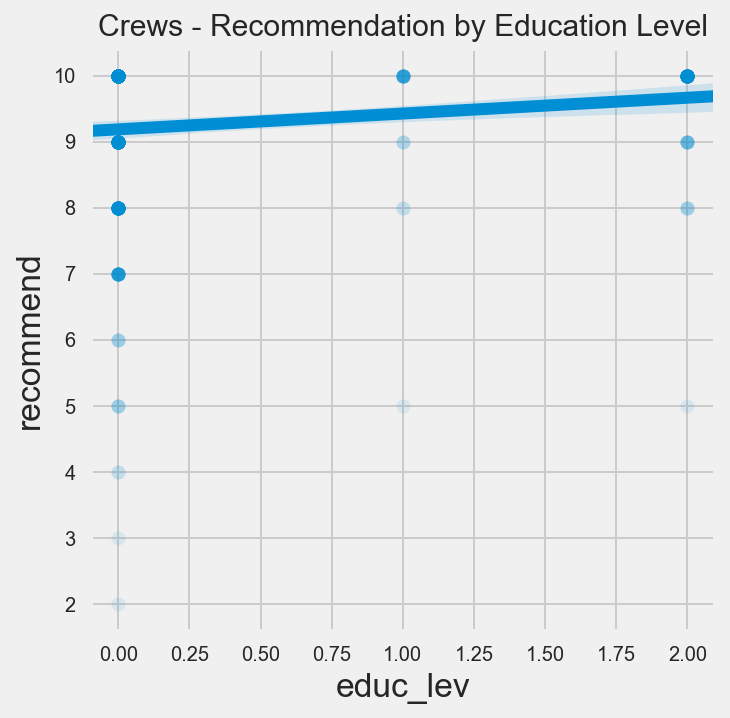

In [261]:
# Make some visualizations

# Regression plot vs. education level
fig=plt.figure(figsize=(5,5))
plt.title('Crews - Recommendation by Education Level',fontsize=15)
ax2= sns.regplot(data= crew,x='educ_lev',y='recommend',scatter_kws={'alpha':0.1})


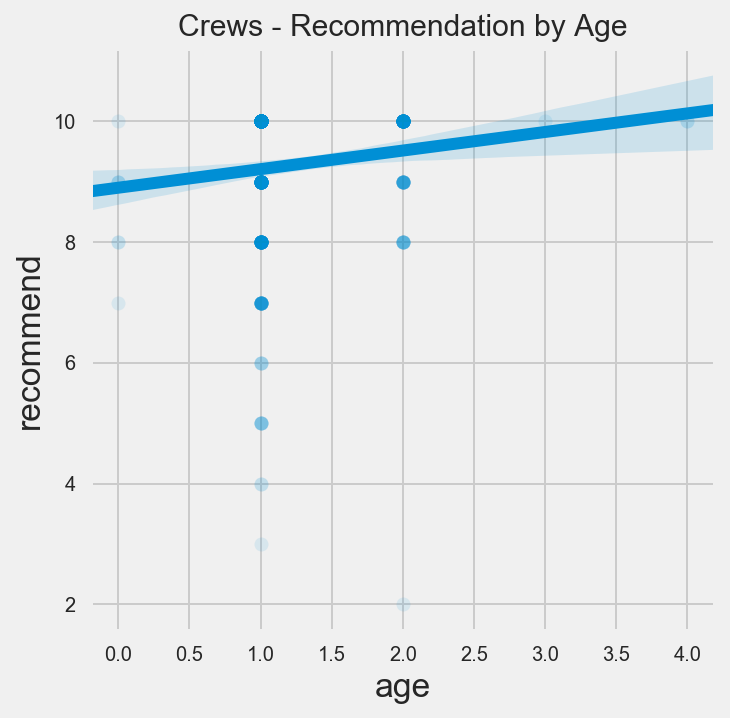

In [262]:
# Regression plot vs. age
fig=plt.figure(figsize=(5,5))
plt.title('Crews - Recommendation by Age',fontsize=15)
ax2= sns.regplot(data= crew,x='age',y='recommend',scatter_kws={'alpha':0.1})


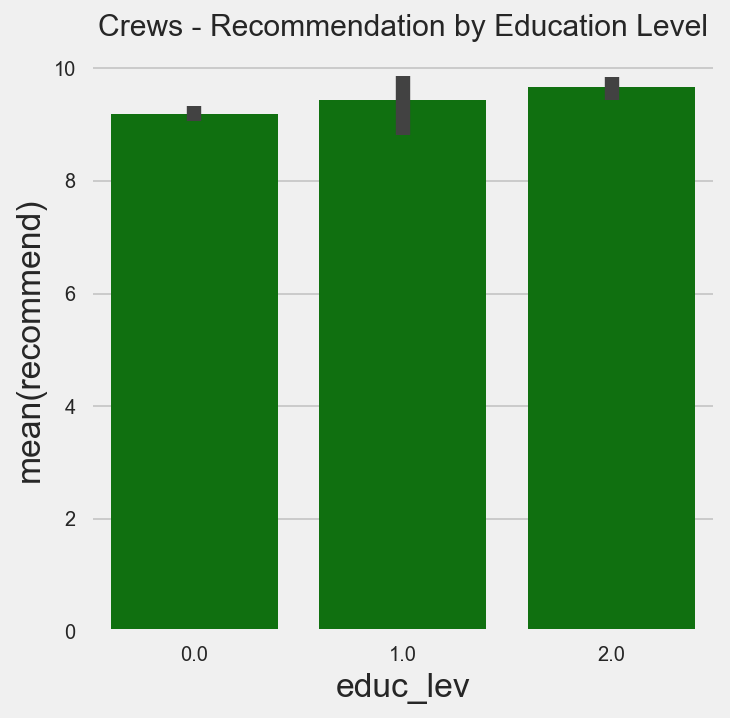

In [263]:
# Bar plot vs. education level
fig=plt.figure(figsize=(5,5))
plt.title('Crews - Recommendation by Education Level',fontsize=15)
#ax2= sns.barplot(data= crew,x='educ_lev',y='recommend',hue='age')
ax2= sns.barplot(data= crew,x='educ_lev',y='recommend',color='green')


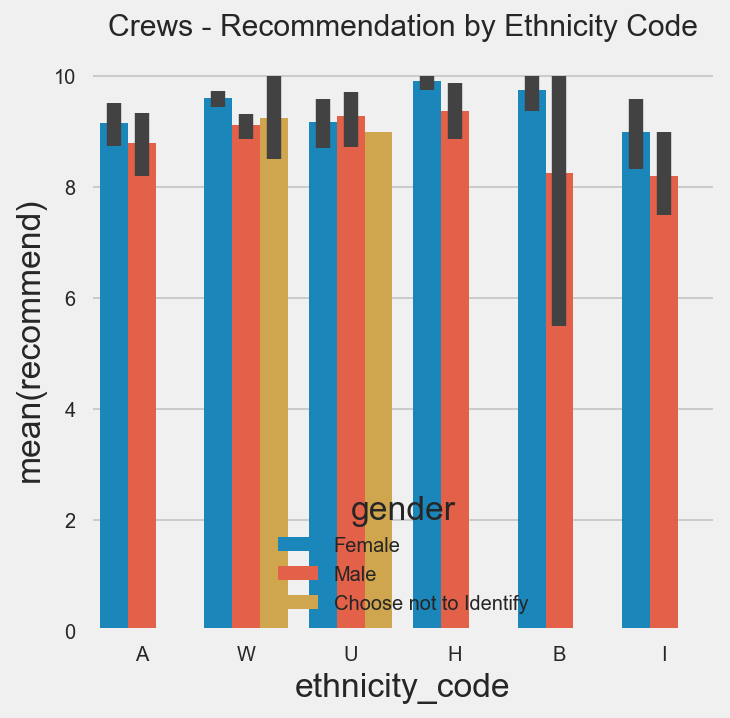

In [264]:
# Bar plot vs. ethnicity code and gender
fig=plt.figure(figsize=(5,5))
plt.title('Crews - Recommendation by Ethnicity Code',fontsize=15)
ax2= sns.barplot(data= crew,x='ethnicity_code',y='recommend',hue='gender')


Corps Analysis 

In [265]:
print corps.shape
print corps.isnull().sum()

(496, 113)
time_stamp          0
op_id               0
americorps          0
budget_cd           0
q18                 1
q19                51
q20                50
q22                 1
q24                 6
q26a                3
q26b                4
q26c                2
q26d                2
q35                 1
q36               496
q48a              496
q48b              496
q48c              496
q48d              496
q48e              496
q48f              496
q49                 4
q50               496
q76               496
q85a              496
q85b              496
q85c              496
q85d              496
q85e              496
q85f              496
q86               496
q88a              496
q88b              496
q88c              496
q93a              496
q93b              496
q93c              496
q93d              496
q93e              496
q94a              496
q94b              496
q94c              496
q95a              496
q95b              496
q95c              496

In [266]:
# drop columns not useful for analyzing Corps data
drop_cols= ['time_stamp','op_id','q36','q48a','q48b','q48c','q48d','q48e','q48f','q50','q76',
           'q85a','q85b','q85c','q85d','q85e','q85f','q86','q88a','q88b','q88c',
           'q93a','q93b','q93c','q93d','q93e','q94a','q94b','q94c','q95a','q95b','q95c','q95d',
           'q96a','q96b','q96c','q96d','q96e','q96f','q96g','org','org_par','loc_str','loc_zip',
            'job_title','mem_zip','mem_school','zip_x','zip_y','loc_city_orig','recommend_av',
           'mem_id','pos_id','prog_type','ethnicity','count','precip','maxtemp','meantemp',
           'mintemp','days']

corps.drop(drop_cols, axis=1,inplace=True)

/Users/matthewterribile/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [267]:
print corps.shape
corps.describe()


(496, 52)


q18         q19         q20         q22         q24        q26a  \
count  495.000000  445.000000  446.000000  495.000000  490.000000  493.000000   
mean     1.096970    3.494382    3.887892    3.303030    3.567347    3.989858   
std      0.296216    0.868928    0.953285    1.087792    0.984831    0.891410   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      1.000000    3.000000    3.000000    3.000000    3.000000    4.000000   
50%      1.000000    3.000000    4.000000    3.000000    4.000000    4.000000   
75%      1.000000    4.000000    5.000000    4.000000    4.000000    5.000000   
max      2.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

             q26b        q26c        q26d         q35         q49        q97a  \
count  492.000000  494.000000  494.000000  495.000000  492.000000  495.000000   
mean     3.863821    3.522267    3.493927    3.498990    3.634146    3.868687   
std      0.937862    0.996195    0.998459    1.027703    1.056592    0.893595   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      3.000000    3.000000    3.000000    3.000000    3.000000    3.000000   
50%      4.000000    4.000000    4.000000    4.000000    4.000000    4.000000   
75%      5.000000    4.000000    4.000000    4.000000    4.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

             q97b        q97c        q97d        q97e        q97f        q98a  \
count  493.000000  493.000000  494.000000  493.000000  491.000000  495.000000   
mean     3.752535    3.872211    3.890688    4.010142    3.293279    4.204040   
std      0.943322    0.922780    0.905356    0.907231    1.151545    0.865899   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      3.000000    3.000000    3.000000    3.000000    3.000000    4.000000   
50%      4.000000    4.000000    4.000000    4.000000    3.000000    4.000000   
75%      4.000000    5.000000    5.000000    5.000000    4.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

             q98b        q98c        q98d        q98e        q98f        q98g  \
count  494.000000  494.000000  495.000000  494.000000  492.000000  493.000000   
mean     4.259109    4.340081    4.317172    4.489879    4.402439    4.178499   
std      0.897183    0.770746    0.878446    0.774137    0.774225    1.024390   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    4.000000    4.000000    4.000000    4.000000    4.000000   
50%      4.000000    4.000000    5.000000    5.000000    5.000000    4.000000   
75%      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

             q98h        q99a        q99b        q99c        q100   recommend  \
count  492.000000  495.000000  495.000000  494.000000  493.000000  496.000000   
mean     4.284553    4.252525    4.171717    3.919028    2.991886    8.449597   
std      0.856463    0.869448    0.931244    1.072202    0.915059    1.999363   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    4.000000    4.000000    3.000000    2.000000    8.000000   
50%      4.000000    4.000000    4.000000    4.000000    3.000000    9.000000   
75%      5.000000    5.000000    5.000000    5.000000    4.000000   10.000000   
max      5.000000    5.000000    5.000000    5.000000    4.000000   10.000000   

            weeks    educ_lev         age    employed        SNAP  health_ins  \
count  496.000000  495.000000  496.000000  486.000000  485.000000  486.000000   
mean    27.645161    2.672727    3.816532   64.347942   10.595670   90.237449   
std     12.983093    0.721253    0.501119    8.011748    8.104256    6.263647   
min      1.000000    0.000000    2.00000

In [268]:
# Look at correlations across survey questions where they are complete
ans_cols=['q18','q19','q20','q22','q24','q26a','q26b','q26c','q26d','q35','q49',
           'q97a','q97b','q97c','q97d','q97e','q97f',
           'q98a','q98b','q98c','q98d','q98e','q98f','q98g','q98h',
           'q99a','q99b','q99c','q100','recommend']
corps_1=corps[(corps[ans_cols].isnull().sum(axis=1)==0)]
print corps_1.shape
corps_1[ans_cols].corr()

(415, 52)


q18       q19       q20       q22       q24      q26a      q26b  \
q18        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
q19        NaN  1.000000  0.613911  0.197714  0.132650  0.082479  0.050788   
q20        NaN  0.613911  1.000000  0.214291  0.154976  0.164668  0.120142   
q22        NaN  0.197714  0.214291  1.000000  0.571476  0.154824  0.092020   
q24        NaN  0.132650  0.154976  0.571476  1.000000  0.329848  0.120459   
q26a       NaN  0.082479  0.164668  0.154824  0.329848  1.000000  0.166122   
q26b       NaN  0.050788  0.120142  0.092020  0.120459  0.166122  1.000000   
q26c       NaN  0.180079  0.141055  0.296599  0.388220  0.388609  0.217936   
q26d       NaN -0.052441 -0.000273  0.001263  0.161264  0.093693  0.460888   
q35        NaN  0.312180  0.386201  0.244172  0.282858  0.226978  0.104351   
q49        NaN  0.412624  0.495566  0.265636  0.225414  0.211064  0.223482   
q97a       NaN  0.259237  0.377620  0.370167  0.400789  0.362324  0.109823   
q97b       NaN  0.196347  0.310032  0.279773  0.314295  0.317823  0.160576   
q97c       NaN  0.210931  0.240477  0.229968  0.304857  0.287124  0.051738   
q97d       NaN  0.196574  0.290180  0.228995  0.281338  0.255487  0.134908   
q97e       NaN  0.119810  0.184595  0.232491  0.288022  0.217178  0.161499   
q97f       NaN  0.257741  0.238178  0.311328  0.350313  0.308351  0.116101   
q98a       NaN  0.033990  0.125287  0.120024  0.179323  0.313213  0.210695   
q98b       NaN  0.142876  0.270198  0.198236  0.234095  0.183705  0.183348   
q98c       NaN  0.058454  0.167674  0.172961  0.244725  0.285664  0.209368   
q98d       NaN  0.113366  0.246438  0.262803  0.266182  0.296183  0.193423   
q98e       NaN  0.031597  0.175115  0.160707  0.212819  0.276179  0.166872   
q98f       NaN  0.038739  0.134307  0.152725  0.257131  0.285876  0.133468   
q98g       NaN  0.181346  0.314993  0.171826  0.228069  0.179710  0.157029   
q98h       NaN  0.103060  0.199332  0.203132  0.277268  0.317533  0.195224   
q99a       NaN  0.145829  0.204856  0.172347  0.231015  0.166687  0.199135   
q99b       NaN  0.149686  0.220920  0.240808  0.264799  0.271431  0.188872   
q99c       NaN  0.102079  0.183629  0.232792  0.268033  0.315680  0.291844   
q100       NaN -0.057465 -0.018263 -0.102904 -0.163364 -0.146465 -0.131230   
recommend  NaN  0.064563  0.127086  0.159970  0.262790  0.339965  0.239264   

               q26c      q26d       q35       q49      q97a      q97b  \
q18             NaN       NaN       NaN       NaN       NaN       NaN   
q19        0.180079 -0.052441  0.312180  0.412624  0.259237  0.196347   
q20        0.141055 -0.000273  0.386201  0.495566  0.377620  0.310032   
q22        0.296599  0.001263  0.244172  0.265636  0.370167  0.279773   
q24        0.388220  0.161264  0.282858  0.225414  0.400789  0.314295   
q26a       0.388609  0.093693  0.226978  0.211064  0.362324  0.317823   
q26b       0.217936  0.460888  0.104351  0.223482  0.109823  0.160576   
q26c       1.000000  0.117181  0.293623  0.231713  0.349427  0.385054   
q26d       0.117181  1.000000  0.103138  0.123256  0.049273  0.094900   
q35        0.293623  0.103138  1.000000  0.423893  0.387434  0.493679   
q49        0.231713  0.123256  0.423893  1.000000  0.331846  0.422356   
q97a       0.349427  0.049273  0.387434  0.331846  1.000000  0.603504   
q97b       0.385054  0.094900  0.493679  0.422356  0.603504  1.000000   
q97c       0.336942  0.095154  0.484101  0.385829  0.444336  0.631846   
q97d       0.304481  0.146344  0.504540  0.399854  0.451325  0.614790   
q97e       0.240103  0.105293  0.389203  0.347859  0.467705  0.562357   
q97f       0.423871  0.072113  0.526073  0.357909  0.465097  0.576287   
q98a       0.312530  0.214309  0.275689  0.294109  0.290184  0.398613   
q98b       0.216595  0.124298  0.255061  0.446872  0.365294  0.362231   
q98c       0.294890  0.214361  0.328577  0.300191  0.333542  0.424579   
q98d       0.235401  0.102727  0.281247  0.226947  0.304717

In [269]:
# Run statsmodel linear regression to see which of the above are significantly correlated
corps_1=corps_1[ans_cols]
X=corps_1.drop('recommend', axis=1)
y=corps_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     10.02
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           2.99e-31
Time:                        14:00:34   Log-Likelihood:                -691.85
No. Observations:                 415   AIC:                             1442.
Df Residuals:                     386   BIC:                             1559.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
q18            2.9042      0.748      3.881      0.000       1.433       4.376
q19           -0.0413      0.103     -0.401      0.688      -0.243       0.161
q20            0.0077      0.100      0.077      0.938      -0.188       0.203
q22           -0.0745      0.080     -0.930      0.353      -0.232       0.083
q24            0.0694      0.094      0.740      0.460      -0.115       0.254
q26a           0.1835      0.092      2.003      0.046       0.003       0.364
q26b           0.0975      0.088      1.107      0.269      -0.076       0.271
q26c           0.1384      0.089      1.551      0.122      -0.037       0.314
q26d           0.1002      0.083      1.202      0.230      -0.064       0.264
q35            0.1050      0.094      1.121      0.263      -0.079       0.289
q49            0.0535      0.095      0.563      0.574      -0.133       0.240
q97a           0.1734      0.113      1.528      0.127      -0.050       0.396
q97b          -0.2040      0.125     -1.638      0.102      -0.449       0.041
q97c           0.3252      0.131      2.475      0.014       0.067       0.584
q97d          -0.3097      0.130     -2.384      0.018      -0.565      -0.054
q97e           0.0166      0.108      0.154      0.878      -0.195       0.228
q97f          -0.1162      0.090     -1.291      0.198      -0.293       0.061
q98a          -0.1177      0.138     -0.852      0.395      -0.389       0.154
q98b           0.0032      0.135      0.024      0.981      -0.262       0.268
q98c           0.3158      0.171      1.849      0.065      -0.020       0.652
q98d           0.2644      0.141      1.874      0.062      -0.013       0.542
q98e           0.1792      0.143      1.253      0.211      -0.102       0.460
q98f           0.0610      0.140      0.435      0.664      -0.215       0.337
q98g          -0.2235      0.107     -2.093      0.037      -0.434      -0.014
q98h           0.1360      0.145      0.941      0.347      -0.148       0.420
q99a          -0.0919      0.111     -0.827      0.409      -0.310       0.127
q99b           0.2086      0.119      1.756      0.080      -0.025       0.442
q99c           0.3539      0.104      3.414      0.001       0.150       0.558
q100          -0.3299      0.077     -4.276      0.000      -0.482      -0.178
==============================================================================
Omnibus:                       53.367   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.669
Skew:                          -0.795   Prob(JB):                     9.18e-20
Kurtosis:                       4.595   Cond. No.                         243.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is

In [270]:
# Do pairwise linear regressions to find ones that are potential predictors of recommendation
# Start with variables that were significant for community or crew

# Ethnicity code
regr2(corps,'ethnicity_code').summary()

X shape: (496, 6)
y shape: (496,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.869
Date:                Tue, 05 Sep 2017   Prob (F-statistic):             0.0982
Time:                        14:00:34   Log-Likelihood:                -1042.3
No. Observations:                 496   AIC:                             2097.
Df Residuals:                     490   BIC:                             2122.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.4000      0.514     16.343      0.000       7.390       9.410
ethnicity_code_B      -0.1895      0.688     -0.276      0.783      -1.540       1.161
ethnicity_code_H       0.7951      0.601      1.324      0.186      -0.385       1.975
ethnicity_code_I      -0.0667      1.259     -0.053      0.958      -2.540       2.407
ethnicity_code_U       0.6000      0.633      0.948      0.344      -0.644       1.844
ethnicity_code_W      -0.0555      0.524     -0.106      0.916      -1.085       0.974
ethnicity_code_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      169.047   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              434.590
Skew:                          -1.725   Prob(JB):                     4.27e-95
Kurtosis:                       6.021   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [271]:
# Ethnicity code is not significant to recommendation score

In [272]:
# Age
regr2(corps,'age').summary()

X shape: (496, 1)
y shape: (496,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.589
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.208
Time:                        14:00:34   Log-Likelihood:                -1046.1
No. Observations:                 496   AIC:                             2096.
Df Residuals:                     494   BIC:                             2105.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3119      0.690     13.498      0.000       7.957      10.667
age           -0.2260      0.179     -1.261      0.208      -0.578       0.126
==============================================================================
Omnibus:                      170.167   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              439.008
Skew:                          -1.736   Prob(JB):                     4.68e-96
Kurtosis:                       6.032   Cond. No.                         31.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [273]:
# Age is not significant to recommendation score

In [274]:
# Education level
regr2(corps,'educ_lev').summary()

X shape: (495, 1)
y shape: (495,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5288
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.467
Time:                        14:00:34   Log-Likelihood:                -1044.8
No. Observations:                 495   AIC:                             2094.
Df Residuals:                     493   BIC:                             2102.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2039      0.346     23.741      0.000       7.525       8.883
educ_lev       0.0908      0.125      0.727      0.467      -0.154       0.336
==============================================================================
Omnibus:                      171.106   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              443.825
Skew:                          -1.747   Prob(JB):                     4.21e-97
Kurtosis:                       6.052   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [275]:
# Education level is not significant to recommendation score

In [276]:
# Median income in home zip code
regr2(corps,'income').summary()

X shape: (483, 1)
y shape: (483,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.221
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.270
Time:                        14:00:34   Log-Likelihood:                -1022.5
No. Observations:                 483   AIC:                             2049.
Df Residuals:                     481   BIC:                             2057.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6923      0.237     36.749      0.000       8.227       9.157
income      -3.65e-06    3.3e-06     -1.105      0.270   -1.01e-05    2.84e-06
==============================================================================
Omnibus:                      169.984   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              448.960
Skew:                          -1.766   Prob(JB):                     3.23e-98
Kurtosis:                       6.135   Cond. No.                     1.85e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [277]:
# Median income in home zip code is not significant

In [278]:
# Americorps participant (most are)
regr2(corps,'americorps').summary()

X shape: (496, 2)
y shape: (496,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4435
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.506
Time:                        14:00:34   Log-Likelihood:                -1046.7
No. Observations:                 496   AIC:                             2097.
Df Residuals:                     494   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.6897      0.371     23.392      0.000       7.960       9.420
americorps_Yes    -0.2550      0.383     -0.666      0.506      -1.007       0.497
americorps_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      174.119   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              461.015
Skew:                          -1.764   Prob(JB):                    7.80e-101
Kurtosis:                       6.139   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [279]:
# Americorps participation is not significant

In [280]:
# Budget code
regr2(corps,'budget_cd').summary()

X shape: (496, 17)
y shape: (496,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     4.953
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           1.68e-09
Time:                        14:00:34   Log-Likelihood:                -1009.0
No. Observations:                 496   AIC:                             2052.
Df Residuals:                     479   BIC:                             2123.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.0000      1.883      4.780      0.000       5.301      12.699
budget_cd_221    -5.0000      2.663     -1.878      0.061     -10.232       0.232
budget_cd_254    -2.0000      2.105     -0.950      0.343      -6.136       2.136
budget_cd_258     0.1429      2.013      0.071      0.943      -3.812       4.098
budget_cd_270    -2.3750      1.997     -1.189      0.235      -6.299       1.549
budget_cd_275    -0.8403      1.889     -0.445      0.657      -4.552       2.872
budget_cd_307     1.0000      2.663      0.376      0.707      -4.232       6.232
budget_cd_310     0.3077      1.954      0.157      0.875      -3.531       4.147
budget_cd_312     0.2941      1.910      0.154      0.878      -3.459       4.048
budget_cd_330    -0.8750      1.922     -0.455      0.649      -4.651       2.901
budget_cd_332    -0.3889      1.909     -0.204      0.839      -4.139       3.362
budget_cd_334     0.4500      1.906      0.236      0.813      -3.295       4.195
budget_cd_336     0.0571      1.909      0.030      0.976      -3.695       3.809
budget_cd_337    -7.0000      2.306     -3.036      0.003     -11.531      -2.469
budget_cd_338    -0.3659      1.894     -0.193      0.847      -4.088       3.356
budget_cd_339    -1.5000      1.916     -0.783      0.434      -5.265       2.265
budget_cd_340    -0.9722      1.909     -0.509      0.611      -4.723       2.778
budget_cd_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      152.679   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              380.108
Skew:                          -1.557   Prob(JB):                     2.89e-83
Kurtosis:                       5.948   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [281]:
# Budget code 337 has worse scores, but there are only 2 samples with that budget code

In [282]:
# Location city of project
regr2(corps,'loc_city').summary()

X shape: (492, 75)
y shape: (492,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     2.961
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           3.14e-12
Time:                        14:00:34   Log-Likelihood:                -935.98
No. Observations:                 492   AIC:                             2022.
Df Residuals:                     417   BIC:                             2337.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               8.0000      0.881      9.083      0.000       6.269       9.731
loc_city_Alexandria Bay            -6.0000      1.525     -3.933      0.000      -8.999      -3.001
loc_city_Allenstown                 1.5833      1.017      1.557      0.120      -0.416       3.582
loc_city_Anchorage                  1.2143      0.999      1.216      0.225      -0.749       3.177
loc_city_Avalon                     1.5000      1.079      1.391      0.165      -0.620       3.620
loc_city_Babylon                   -2.0000      1.525     -1.311      0.191      -4.999       0.999
loc_city_Barstow                   -4.0000      1.525     -2.622      0.009      -6.999      -1.001
loc_city_Bear Mountain              1.5000      1.137      1.319      0.188      -0.735       3.735
loc_city_Blue Mountain Lake         2.0000      1.969      1.016      0.310      -1.871       5.871
loc_city_Cairo                     -1.0000      1.969     -0.508      0.612      -4.871       2.871
loc_city_Chadron                    0.2500      1.079      0.232      0.817      -1.870       2.370
loc_city_Challis                    0.6111      0.928      0.658      0.511      -1.214       2.436
loc_city_Cheney                    -1.5000      1.246     -1.204      0.229      -3.948       0.948
loc_city_Cody                      -0.5000      1.525     -0.328      0.743      -3.499       2.499
loc_city_Cold Spring                2.0000      1.182      1.693      0.091      -0.323       4.323
loc_city_Concord                    1.1364      0.957      1.187      0.236      -0.746       3.018
loc_city_Cragsmoor                 -1.0000      1.969     -0.508      0.612      -4.871       2.871
loc_city_Craig                      1.0000      1.345      0.743      0.458      -1.645       3.645
loc_city_Custer                     1.3750      1.079      1.275      0.203      -0.745       3.495
loc_city_Delmar                     0.8333      1.137      0.733      0.464      -1.402       3.068
loc_city_Denali Park                1.2500      1.246      1.004      0.316      -1.198       3.698
loc_city_Eagle                      1.0000      1.345      0.743      0.458      -1.645       3.645
loc_city_Fairview Park             -2.0000      1.345     -1.487      0.138      -4.645       0.645
loc_city_Flagstaff                 -0.5000      1.525     -0.328      0.743      -3.499       2.499
loc_city_Frazier Park               0.6000      1.182      0.508      0.612      -1.723       2.923
loc_city_Gansevoort                 1.5000      1.525      0.983      0.326      -1.499       4.499
loc_city_Gautier                 2.665e-14      1.969   1.35e-14      1.000      -3.871       3.871
loc_city_Georgetown                 0.5000      1.246      0.401      0.688      -1

In [283]:
# Worse scores in Alexandria Bay (2 surveys), Barstow (2 surveys), Greybull (4 surveys),
# Huger (1 survey), Kingston (1 survey), Staatsburg (6 surveys)
# Besides Staatsburg and perhaps Greybull, not worth looking at

In [284]:
# Opening status (most are 'Out of Field', a few 'Left Early')
regr2(corps,'op_stat').summary()

X shape: (496, 4)
y shape: (496,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.071
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.361
Time:                        14:00:34   Log-Likelihood:                -1045.3
No. Observations:                 496   AIC:                             2099.
Df Residuals:                     492   BIC:                             2115.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              8.1000      0.632     12.814      0.000       6.858       9.342
op_stat_Early Exit: Quit          -0.5000      0.816     -0.613      0.540      -2.103       1.103
op_stat_Early Exit: Terminated    -0.1000      2.096     -0.048      0.962      -4.219       4.019
op_stat_Out of the Field           0.3851      0.639      0.603      0.547      -0.870       1.640
op_stat_nan                             0          0        nan        nan           0           0
==============================================================================
Omnibus:                      169.549   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              437.809
Skew:                          -1.728   Prob(JB):                     8.53e-96
Kurtosis:                       6.040   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [285]:
# No significant relationship for opening status

In [286]:
# Length in weeks of project
regr2(corps,'weeks').summary()

X shape: (496, 1)
y shape: (496,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.09710
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.755
Time:                        14:00:34   Log-Likelihood:                -1046.9
No. Observations:                 496   AIC:                             2098.
Df Residuals:                     494   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3899      0.212     39.658      0.000       7.974       8.806
weeks          0.0022      0.007      0.312      0.755      -0.011       0.016
==============================================================================
Omnibus:                      172.324   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              449.640
Skew:                          -1.753   Prob(JB):                     2.30e-98
Kurtosis:                       6.076   Cond. No.                         72.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [287]:
# No relationship with weeks

In [288]:
# Gender
regr2(corps,'gender').summary()

X shape: (496, 3)
y shape: (496,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     5.083
Date:                Tue, 05 Sep 2017   Prob (F-statistic):            0.00653
Time:                        14:00:34   Log-Likelihood:                -1041.9
No. Observations:                 496   AIC:                             2090.
Df Residuals:                     493   BIC:                             2102.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.0000      1.145      8.734      0.000       7.750      12.250
gender_Female    -1.3140      1.152     -1.141      0.254      -3.577       0.949
gender_Male      -1.8298      1.152     -1.588      0.113      -4.094       0.434
gender_nan             0          0        nan        nan           0           0
==============================================================================
Omnibus:                      178.531   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              495.081
Skew:                          -1.785   Prob(JB):                    3.12e-108
Kurtosis:                       6.349   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [289]:
# Gender has no significant relationship with recommendation

In [290]:
# Organization Managing project
regr2(corps,'org_mng').summary()

X shape: (496, 71)
y shape: (496,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     2.917
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           1.44e-11
Time:                        14:00:34   Log-Likelihood:                -949.63
No. Observations:                 496   AIC:                             2041.
Df Residuals:                     425   BIC:                             2340.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================================
                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                               10.0000      1.773      5.639      0.000       6.514      13.486
org_mng_Allegheny County                                                            -4.1765      1.825     -2.289      0.023      -7.763      -0.590
org_mng_Allegheny County Conservation District                                     9.73e-15      2.508   3.88e-15      1.000      -4.929       4.929
org_mng_Audubon New York                                                         -2.043e-14      2.172  -9.41e-15      1.000      -4.269       4.269
org_mng_BLM Arizona (AZ)                                                         -3.075e-14      2.508  -1.23e-14      1.000      -4.929       4.929
org_mng_BLM California (CA)                                                         -2.4545      1.852     -1.325      0.186      -6.095       1.186
org_mng_Bear Mountain State Park, NYS OPRHP                                         -0.5000      1.983     -0.252      0.801      -4.397       3.397
org_mng_Bighorn National Forest                                                     -3.8571      1.896     -2.035      0.043      -7.583      -0.131
org_mng_Black Hills National Forest                                                 -0.6250      1.881     -0.332      0.740      -4.322       3.072
org_mng_Catalina Island Conservancy                                                 -0.5000      1.881     -0.266      0.791      -4.197       3.197
org_mng_City of Pittsburgh                                                          -2.8000      1.943     -1.441      0.150      -6.618       1.018
org_mng_Clay Pit Ponds State Park NYS OPRHP                                         -1.0000      2.172     -0.460      0.645      -5.269       3.269
org_mng_Coconino National Forest                                                    -2.5000      2.172     -1.151      0.250      -6.769       1.769
org_mng_Congaree National Park                                                      -1.6667      2.048     -0.814      0.416      -5.692       2.358
org_mng_Cuyahoga River Community Planning Organization                              -2.8333      1.915     -1.479      0.140      -6.598       0.932
org_mng_Daniel Boone National Forest                                                -2.0000      2.508     -0.797      0.426      -6.929       2.929
org_mng_Delaware Water Gap National Recreation Area                                 -2.0000      1.852     -1.080      0.281      -5.641       1.641
org_mng_Eldorado National Forest                                                    -1.5000      1.983 

In [291]:
# Significantly worse experiences from : Allegheny County (17 surveys), 
# Bighorn National Forest (7 surveys), SCA Oakland Office (5 surveys),  
# Thousand Islands Regional Parks NYS OPRHP (2 surveys),
# NYC Department of Environmental Protection (1 survey)

In [292]:
# Home state of participant
regr2(corps,'mem_st').summary()

X shape: (496, 44)
y shape: (496,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.6952
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.929
Time:                        14:00:34   Log-Likelihood:                -1031.1
No. Observations:                 496   AIC:                             2150.
Df Residuals:                     452   BIC:                             2335.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.2500      1.013      9.130      0.000       7.259      11.241
mem_st_AR                0.2500      1.755      0.142      0.887      -3.199       3.699
mem_st_AZ               -0.9167      1.218     -0.753      0.452      -3.310       1.476
mem_st_CA               -0.7955      1.073     -0.741      0.459      -2.904       1.313
mem_st_CO               -1.1389      1.218     -0.935      0.350      -3.532       1.254
mem_st_CT               -1.0278      1.218     -0.844      0.399      -3.421       1.365
mem_st_DC               -0.2500      1.548     -0.162      0.872      -3.292       2.792
mem_st_FL               -0.4318      1.101     -0.392      0.695      -2.596       1.733
mem_st_GA               -0.2500      1.218     -0.205      0.837      -2.643       2.143
mem_st_HUNGARY          -1.2500      1.755     -0.712      0.477      -4.699       2.199
mem_st_ID               -0.9167      1.548     -0.592      0.554      -3.958       2.125
mem_st_IL               -0.7115      1.088     -0.654      0.514      -2.850       1.427
mem_st_IN               -0.3167      1.140     -0.278      0.781      -2.558       1.924
mem_st_KS               -1.2500      1.308     -0.956      0.340      -3.821       1.321
mem_st_KY               -1.0500      1.359     -0.772      0.440      -3.721       1.621
mem_st_LA               -1.2500      1.755     -0.712      0.477      -4.699       2.199
mem_st_MA               -0.2885      1.088     -0.265      0.791      -2.427       1.850
mem_st_MD               -0.9167      1.218     -0.753      0.452      -3.310       1.476
mem_st_ME               -0.0500      1.359     -0.037      0.971      -2.721       2.621
mem_st_MI               -0.0833      1.170     -0.071      0.943      -2.382       2.216
mem_st_MN               -0.4500      1.359     -0.331      0.741      -3.121       2.221
mem_st_MO               -0.4722      1.218     -0.388      0.698      -2.865       1.921
mem_st_MT                0.2500      1.755      0.142      0.887      -3.199       3.699
mem_st_NAN              -0.2500      1.433     -0.174      0.862      -3.066       2.566
mem_st_NC               -0.9167      1.218     -0.753      0.452      -3.310       1.476
mem_st_NH               -0.0833      1.308     -0.064      0.949      -2.654       2.487
mem_st_NJ               -1.0833      1.120     -0.967      0.334      -3.285       1.118
mem_st_NM                0.4643      1.270      0.366      0.715      -2.032       2.960
mem_st_NY               -1.0100      1.033     -0.977      0.329      -3.041       1.021
mem_st_OH               -1.0278      1.120     -0.918      0.359      -3.229       1.174
mem_st_OK                0.7500      2.266      0.331      0.741      -3.702       5.202
mem_st_OR               -0.2500      1.359     -0.184    

In [293]:
# Participants from South Carolina (6) significantly lower

In [294]:
# Economic indicators from home zip code of participants
# Median income
regr2(corps,'income').summary()

X shape: (483, 1)
y shape: (483,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.221
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.270
Time:                        14:00:34   Log-Likelihood:                -1022.5
No. Observations:                 483   AIC:                             2049.
Df Residuals:                     481   BIC:                             2057.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6923      0.237     36.749      0.000       8.227       9.157
income      -3.65e-06    3.3e-06     -1.105      0.270   -1.01e-05    2.84e-06
==============================================================================
Omnibus:                      169.984   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              448.960
Skew:                          -1.766   Prob(JB):                     3.23e-98
Kurtosis:                       6.135   Cond. No.                     1.85e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [295]:
# % families below poverty level
regr2(corps,'poverty').summary()

X shape: (483, 1)
y shape: (483,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.691
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.194
Time:                        14:00:34   Log-Likelihood:                -1023.0
No. Observations:                 483   AIC:                             2050.
Df Residuals:                     481   BIC:                             2058.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2974      0.149     55.872      0.000       8.006       8.589
poverty        0.0167      0.013      1.301      0.194      -0.009       0.042
==============================================================================
Omnibus:                      167.981   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              437.104
Skew:                          -1.753   Prob(JB):                     1.21e-95
Kurtosis:                       6.071   Cond. No.                         18.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [296]:
# % families receiving SNAP
regr2(corps,'SNAP').summary()

X shape: (485, 1)
y shape: (485,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9421
Date:                Tue, 05 Sep 2017   Prob (F-statistic):              0.332
Time:                        14:00:34   Log-Likelihood:                -1027.6
No. Observations:                 485   AIC:                             2059.
Df Residuals:                     483   BIC:                             2067.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3249      0.151     55.175      0.000       8.028       8.621
SNAP           0.0110      0.011      0.971      0.332      -0.011       0.033
==============================================================================
Omnibus:                      167.690   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              433.675
Skew:                          -1.746   Prob(JB):                     6.74e-95
Kurtosis:                       6.044   Cond. No.                         22.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [297]:
# % people employed
regr2(corps,'employed').summary()

X shape: (486, 1)
y shape: (486,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     5.234
Date:                Tue, 05 Sep 2017   Prob (F-statistic):             0.0226
Time:                        14:00:34   Log-Likelihood:                -1027.1
No. Observations:                 486   AIC:                             2058.
Df Residuals:                     484   BIC:                             2066.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7662      0.737      9.175      0.000       5.317       8.215
employed       0.0260      0.011      2.288      0.023       0.004       0.048
==============================================================================
Omnibus:                      164.876   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.412
Skew:                          -1.721   Prob(JB):                     1.39e-91
Kurtosis:                       5.968   Cond. No.                         525.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [298]:
# % families with health insurance
regr2(corps,'health_ins').summary()

X shape: (486, 1)
y shape: (486,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.651
Date:                Tue, 05 Sep 2017   Prob (F-statistic):             0.0315
Time:                        14:00:34   Log-Likelihood:                -1027.3
No. Observations:                 486   AIC:                             2059.
Df Residuals:                     484   BIC:                             2067.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.2730      1.317      8.562      0.000       8.686      13.860
health_ins    -0.0314      0.015     -2.157      0.032      -0.060      -0.003
==============================================================================
Omnibus:                      168.794   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.777
Skew:                          -1.745   Prob(JB):                     7.11e-97
Kurtosis:                       6.112   Cond. No.                     1.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [299]:
# Only % of families with health insurance is statistically significant, and that is negatively
# correlated

In [300]:
# Regress with all variables that appeared significant.  
regr_cols = ['loc_city','recommend','mem_st','org_mng','health_ins']

# remove rows with nulls and columns not using
corps_1=corps[(corps[regr_cols].isnull().sum(axis=1)==0)]
corps_1 = corps_1[regr_cols]

# get dummy variables for selected non quantitative answers
corps_1 = pd.get_dummies(corps_1, dummy_na=True, drop_first=True)
print corps_1.shape

# set X and y variables and do StatsModel linear regression
X=corps_1.drop('recommend', axis=1)
y=corps_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(482, 189)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     2.230
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           2.79e-09
Time:                        14:00:35   Log-Likelihood:                -877.47
No. Observations:                 482   AIC:                             2017.
Df Residuals:                     351   BIC:                             2564.
Df Model:                         130                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================================
                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                9.5568      1.960      4.877      0.000       5.703      13.411
health_ins                                                                          -0.0248      0.019     -1.338      0.182      -0.061       0.012
loc_city_Alexandria Bay                                                             -2.7622      0.654     -4.224      0.000      -4.048      -1.476
loc_city_Allenstown                                                                  0.6710      0.395      1.697      0.091      -0.107       1.449
loc_city_Anchorage                                                                   0.5928      0.520      1.140      0.255      -0.430       1.615
loc_city_Avalon                                                                      0.7796      0.365      2.136      0.033       0.062       1.498
loc_city_Babylon                                                                    -0.8315      0.639     -1.302      0.194      -2.088       0.425
loc_city_Barstow                                                                    -2.8402      0.886     -3.206      0.001      -4.582      -1.098
loc_city_Bear Mountain                                                               0.9602      0.531      1.810      0.071      -0.083       2.004
loc_city_Blue Mountain Lake                                                          1.6697      1.746      0.956      0.340      -1.765       5.104
loc_city_Cairo                                                                      -0.4674      0.875     -0.534      0.594      -2.189       1.254
loc_city_Chadron                                                                     0.0359      0.326      0.110      0.912      -0.605       0.677
loc_city_Challis                                                                     0.7919      0.620      1.278      0.202      -0.427       2.010
loc_city_Cheney                                                                     -0.8340      0.451     -1.849      0.065      -1.721       0.053
loc_city_Cody                                                                       -0.3840      0.630     -0.610      0.542      -1.623       0.855
loc_city_Cold Spring                                                                 1.3580      0.549      2.473      0.014       0.278       2.438
loc_city_Concord                                                                     0.1827      0.337      0.542      0.588      -0.480       0.846
loc_city_Cragsmoor                                                                  -1.0740      1.621 

In [301]:
# Member state and health insurance don't look significant.   Remove them and repeat
# Just left with 2 very specific (and related) variables
regr_cols = ['loc_city','recommend','org_mng']

# remove rows with nulls and columns not using
corps_1=corps[(corps[regr_cols].isnull().sum(axis=1)==0)]
corps_1 = corps_1[regr_cols]

# get dummy variables for selected non quantitative answers
corps_1 = pd.get_dummies(corps_1, dummy_na=True, drop_first=True)
print corps_1.shape

# set X and y variables and do StatsModel linear regression
X=corps_1.drop('recommend', axis=1)
y=corps_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(492, 147)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     2.893
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           5.45e-13
Time:                        14:00:35   Log-Likelihood:                -918.08
No. Observations:                 492   AIC:                             2016.
Df Residuals:                     402   BIC:                             2394.
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================================
                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                7.9738      0.139     57.313      0.000       7.700       8.247
loc_city_Alexandria Bay                                                             -2.9869      0.607     -4.922      0.000      -4.180      -1.794
loc_city_Allenstown                                                                  0.6855      0.357      1.921      0.055      -0.016       1.387
loc_city_Anchorage                                                                   0.7256      0.484      1.499      0.135      -0.226       1.677
loc_city_Avalon                                                                      0.7631      0.309      2.467      0.014       0.155       1.371
loc_city_Babylon                                                                    -0.9869      0.607     -1.626      0.105      -2.180       0.206
loc_city_Barstow                                                                    -2.7690      0.836     -3.313      0.001      -4.412      -1.126
loc_city_Bear Mountain                                                               1.0175      0.499      2.041      0.042       0.037       1.998
loc_city_Blue Mountain Lake                                                          2.0262      1.686      1.202      0.230      -1.288       5.340
loc_city_Cairo                                                                      -0.4869      0.855     -0.569      0.570      -2.169       1.195
loc_city_Chadron                                                                     0.1381      0.309      0.446      0.655      -0.470       0.746
loc_city_Challis                                                                     0.5327      0.580      0.918      0.359      -0.607       1.673
loc_city_Cheney                                                                     -0.7369      0.432     -1.706      0.089      -1.586       0.112
loc_city_Cody                                                                       -0.2369      0.607     -0.390      0.696      -1.430       0.956
loc_city_Cold Spring                                                                 1.3508      0.525      2.575      0.010       0.320       2.382
loc_city_Concord                                                                     0.2385      0.300      0.794      0.428      -0.352       0.829
loc_city_Cragsmoor                                                                  -0.9028      1.598     -0.565      0.573      -4.045       2.239
loc_city_Craig                                                                       0.5131      0.497 

In [302]:
# This feels badly overfit since the variables that are significant are moving around some.
# Recommend that the SCA look into experiences with 4 or more surveys that showed significant
# difference.

In [303]:
# Will try one more regression with multiple common variables to see if find anything else.
regr_cols = ['gender','age','income','vet','ethnicity_code','recommend']

# remove rows with nulls and columns not using
corps_1=corps[(corps[regr_cols].isnull().sum(axis=1)==0)]
corps_1 = corps_1[regr_cols]

# get dummy variables for selected non quantitative answers
corps_1 = pd.get_dummies(corps_1, dummy_na=True, drop_first=True)
print corps_1.shape

# set X and y variables and do StatsModel linear regression
X=corps_1.drop('recommend', axis=1)
y=corps_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

(483, 15)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.197
Date:                Tue, 05 Sep 2017   Prob (F-statistic):             0.0136
Time:                        14:00:35   Log-Likelihood:                -1011.0
No. Observations:                 483   AIC:                             2046.
Df Residuals:                     471   BIC:                             2096.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         11.0815      1.448      7.652      0.000       8.236      13.927
age                           -0.2264      0.188     -1.202      0.230      -0.596       0.144
income                     -3.354e-06   3.34e-06     -1.005      0.315   -9.91e-06     3.2e-06
gender_Female                 -1.4690      1.156     -1.271      0.204      -3.740       0.802
gender_Male                   -1.9911      1.159     -1.718      0.086      -4.268       0.286
gender_nan                 -5.218e-15   1.29e-15     -4.050      0.000   -7.75e-15   -2.69e-15
vet_I choose not to answer     0.3050      2.027      0.150      0.880      -3.678       4.288
vet_Post 9/11 veteran         -0.2534      0.343     -0.738      0.461      -0.928       0.421
vet_nan                    -1.992e-15    7.7e-16     -2.586      0.010   -3.51e-15   -4.78e-16
ethnicity_code_B              -0.2333      0.709     -0.329      0.742      -1.626       1.159
ethnicity_code_H               0.9308      0.605      1.538      0.125      -0.259       2.120
ethnicity_code_I               0.4360      1.276      0.342      0.733      -2.071       2.943
ethnicity_code_U               0.8281      0.640      1.295      0.196      -0.429       2.085
ethnicity_code_W               0.0773      0.528      0.147      0.884      -0.959       1.114
ethnicity_code_nan                  0          0        nan        nan           0           0
==============================================================================
Omnibus:                      169.958   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              463.076
Skew:                          -1.745   Prob(JB):                    2.78e-101
Kurtosis:                       6.291   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [304]:
# Nothing of interest in the above.

## Internships Analysis

In [305]:
print interns.shape
interns.isnull().sum()

(2474, 113)


time_stamp           0
op_id                0
americorps           0
budget_cd            0
q18                 25
q19                511
q20                511
q22                  6
q24                 19
q26a                 7
q26b                14
q26c                 8
q26d                 6
q35               2474
q36                  7
q48a                12
q48b                16
q48c                14
q48d                14
q48e                21
q48f                22
q49               2474
q50                 29
q76               2474
q85a              2474
q85b              2474
q85c              2474
q85d              2474
q85e              2474
q85f              2474
q86               2474
q88a              2474
q88b              2474
q88c              2474
q93a              2474
q93b              2474
q93c              2474
q93d              2474
q93e              2474
q94a              2474
q94b              2474
q94c              2474
q95a              2474
q95b       

In [306]:
# drop columns not useful for analyzing Corps data
drop_cols= ['time_stamp','op_id','q35','q49','q76',
           'q85a','q85b','q85c','q85d','q85e','q85f','q86','q88a','q88b','q88c',
           'q93a','q93b','q93c','q93d','q93e','q94a','q94b','q94c','q95a','q95b','q95c','q95d',
           'q96a','q96b','q96c','q96d','q96e','q96f','q96g','org','org_par','loc_str','loc_zip',
            'job_title','mem_zip','mem_school','zip_x','zip_y','loc_city_orig','recommend_av',
           'mem_id','pos_id','prog_type','ethnicity','count','precip','maxtemp','meantemp',
           'mintemp','days']

interns.drop(drop_cols, axis=1,inplace=True)

/Users/matthewterribile/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [307]:
# Look at correlations across survey questions where they are complete
# Treat questions 19 and 20 separately due to the number of nulls
ans_cols=['q19','q20','recommend']
interns_1=interns[(interns[ans_cols].isnull().sum(axis=1)==0)]
print interns_1.shape
interns_1[ans_cols].corr()

(1962, 58)


q19       q20  recommend
q19        1.000000  0.632767   0.190747
q20        0.632767  1.000000   0.237023
recommend  0.190747  0.237023   1.000000

In [308]:
# Neither appear to be correlated with recommend. Won't analyze them any more

In [309]:
# Look at correlations across survey questions where they are complete
# Treat questions 19 and 20 separately due to the number of nulls
ans_cols=['q18','q22','q24','q26a','q26b','q26c','q26d','q36',
          'q48a','q48b','q48c','q48d','q48e','q48f','q50', 
           'q97a','q97b','q97c','q97d','q97e','q97f',
           'q98a','q98b','q98c','q98d','q98e','q98f','q98g','q98h',
           'q99a','q99b','q99c','q100','recommend']
interns_1=interns[(interns[ans_cols].isnull().sum(axis=1)==0)]
print interns_1.shape
interns_1[ans_cols].corr()

(2289, 58)


q18       q22       q24      q26a      q26b      q26c  \
q18        1.000000 -0.269448 -0.269816 -0.220208 -0.073013 -0.254324   
q22       -0.269448  1.000000  0.628731  0.378350  0.145340  0.427130   
q24       -0.269816  0.628731  1.000000  0.399478  0.189868  0.467987   
q26a      -0.220208  0.378350  0.399478  1.000000  0.224880  0.440207   
q26b      -0.073013  0.145340  0.189868  0.224880  1.000000  0.278448   
q26c      -0.254324  0.427130  0.467987  0.440207  0.278448  1.000000   
q26d      -0.074121  0.114068  0.149014  0.161156  0.436704  0.244906   
q36       -0.321507  0.461227  0.466762  0.344833  0.161062  0.394106   
q48a      -0.270768  0.309680  0.362693  0.390293  0.239932  0.340677   
q48b      -0.223856  0.265057  0.318013  0.319076  0.224809  0.317529   
q48c      -0.271144  0.245872  0.294516  0.329288  0.214045  0.302950   
q48d      -0.336566  0.330144  0.376575  0.378474  0.212829  0.377392   
q48e      -0.392776  0.332129  0.348767  0.348261  0.249713  0.379800   
q48f      -0.285374  0.248857  0.300869  0.283846  0.200899  0.318572   
q50       -0.351971  0.370981  0.365582  0.306140  0.166803  0.345876   
q97a      -0.311312  0.507569  0.502737  0.410816  0.173148  0.447079   
q97b      -0.327552  0.459781  0.467050  0.377972  0.187433  0.429576   
q97c      -0.321760  0.430032  0.437651  0.387509  0.178725  0.424099   
q97d      -0.276183  0.415863  0.442128  0.358698  0.171542  0.385629   
q97e      -0.225997  0.371185  0.385905  0.310706  0.168281  0.360747   
q97f      -0.273759  0.486133  0.491715  0.340763  0.134009  0.427529   
q98a      -0.240735  0.301812  0.349772  0.330876  0.196536  0.390948   
q98b      -0.307942  0.353049  0.403223  0.344221  0.174522  0.413184   
q98c      -0.212930  0.271663  0.348694  0.335866  0.197589  0.372747   
q98d      -0.309256  0.302938  0.354161  0.428290  0.181588  0.355997   
q98e      -0.288005  0.314900  0.373114  0.425446  0.214759  0.396763   
q98f      -0.188556  0.263346  0.310586  0.423268  0.174851  0.350394   
q98g      -0.295219  0.308477  0.362842  0.305608  0.142125  0.401279   
q98h      -0.294363  0.356137  0.411883  0.418845  0.203405  0.493174   
q99a      -0.315044  0.327121  0.386044  0.363097  0.236572  0.393540   
q99b      -0.358036  0.349248  0.402481  0.425787  0.201383  0.411943   
q99c      -0.307287  0.365293  0.436374  0.421671  0.212849  0.413398   
q100       0.118087 -0.173134 -0.197046 -0.190541 -0.126353 -0.155294   
recommend -0.195941  0.268772  0.321761  0.374059  0.240985  0.351338   

               q26d       q36      q48a      q48b      q48c      q48d  \
q18       -0.074121 -0.321507 -0.270768 -0.223856 -0.271144 -0.336566   
q22        0.114068  0.461227  0.309680  0.265057  0.245872  0.330144   
q24        0.149014  0.466762  0.362693  0.318013  0.294516  0.376575   
q26a       0.161156  0.344833  0.390293  0.319076  0.329288  0.378474   
q26b       0.436704  0.161062  0.239932  0.224809  0.214045  0.212829   
q26c       0.244906  0.394106  0.340677  0.317529  0.302950  0.377392   
q26d       1.000000  0.132481  0.188529  0.191842  0.188057  0.201383   
q36        0.132481  1.000000  0.411496  0.375200  0.366973  0.431849   
q48a       0.188529  0.411496  1.000000  0.449095  0.563782  0.526302   
q48b       0.191842  0.375200  0.449095  1.000000  0.451962  0.610810   
q48c       0.188057  0.366973  0.563782  0.451962  1.000000  0.548481   
q48d       0.201383  0.431849  0.526302  0.610810  0.548481  1.000000   
q48e       0.204304  0.446270  0.531362  0.543270  0.531202  0.724490   
q48f       0.169492  0.342709  0.477827  0.444680  0.427134  0.499888   
q50        0.135629  0.490223  0.446063  0.392835  0.414925  0.481035   
q97a       0.110080  0.474249  0.432034  0.362862  0.374690  0.464692   
q97b       0.140969  0.537895  0.427323  0.375605  0.364147  0.457459   
q97c       0.150860  0.550522  0.445289  0.384242  0.429806  0.490048   
q97d       0.129834  0.571501  0.436171  0.354714  0.378325  0.447014   


In [310]:
# some questions have .40 or more correlation
# Run statsmodel linear regression to see which of the above are significantly correlated
interns_1=interns_1[ans_cols]
X=interns_1.drop('recommend', axis=1)
y=interns_1['recommend']
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     48.92
Date:                Tue, 05 Sep 2017   Prob (F-statistic):          2.43e-236
Time:                        14:00:35   Log-Likelihood:                -4061.7
No. Observations:                2289   AIC:                             8191.
Df Residuals:                    2255   BIC:                             8386.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4213      0.350      6.915      0.000       1.735       3.108
q18            0.0614      0.086      0.716      0.474      -0.107       0.230
q22            0.0153      0.037      0.414      0.679      -0.057       0.088
q24            0.0521      0.041      1.280      0.201      -0.028       0.132
q26a           0.1454      0.043      3.388      0.001       0.061       0.230
q26b           0.0161      0.036      0.446      0.656      -0.055       0.087
q26c           0.1177      0.043      2.717      0.007       0.033       0.203
q26d           0.2332      0.031      7.472      0.000       0.172       0.294
q36           -0.1006      0.040     -2.518      0.012      -0.179      -0.022
q48a          -0.0570      0.049     -1.166      0.244      -0.153       0.039
q48b          -0.0373      0.053     -0.703      0.482      -0.142       0.067
q48c           0.1029      0.043      2.393      0.017       0.019       0.187
q48d          -0.0020      0.056     -0.036      0.971      -0.112       0.108
q48e           0.0594      0.060      0.987      0.324      -0.059       0.177
q48f           0.1357      0.055      2.464      0.014       0.028       0.244
q50           -0.0595      0.039     -1.529      0.126      -0.136       0.017
q97a           0.0351      0.050      0.704      0.481      -0.063       0.133
q97b           0.0407      0.050      0.813      0.416      -0.058       0.139
q97c           0.0652      0.058      1.117      0.264      -0.049       0.180
q97d          -0.0073      0.051     -0.142      0.887      -0.108       0.093
q97e           0.0277      0.045      0.609      0.543      -0.062       0.117
q97f          -0.0759      0.040     -1.880      0.060      -0.155       0.003
q98a           0.0262      0.056      0.468      0.639      -0.084       0.136
q98b          -0.1050      0.052     -2.023      0.043      -0.207      -0.003
q98c           0.0156      0.067      0.233      0.816      -0.116       0.147
q98d           0.2568      0.056      4.604      0.000       0.147       0.366
q98e           0.1001      0.063      1.590      0.112      -0.023       0.224
q98f           0.1885      0.055      3.456      0.001       0.082       0.295
q98g          -0.1406      0.038     -3.722      0.000      -0.215      -0.067
q98h           0.0947      0.062      1.536      0.125      -0.026       0.215
q99a           0.2027      0.059      3.434      0.001       0.087       0.318
q99b          -0.1206      0.055     -2.182      0.029      -0.229      -0.012
q99c           0.4556      0.042     10.866      0.000       0.373       0.538
q100          -0.3438      0.033    -10.458      0.000      -0.408      -0.279
==============================================================================
Omnibus:                      415.885   Durbin-Watson:                   2.043
Pr

In [311]:
# Do sklearn logistic regression with Lasso regularization to get preliminary look at
# features likely to be significant
regr_cols = ['income','ethnicity_code','age','weeks','recommend','org_mng',
            'gender','americorps','vet']
# 'loc_city', 'mem_st','budget_cd'
# remove rows with nulls
interns_1=interns[(interns[regr_cols].isnull().sum(axis=1)==0)]

# remove columns not regressing on
interns_1 = interns_1[regr_cols]

# add dummies as needed
interns_1 = pd.get_dummies(interns_1, dummy_na=True, drop_first=True)

# set up X and y
X=interns_1.drop('recommend', axis=1)
y=interns_1['recommend']

# model using sklearn with L1 regression to do feature selection 
lm=linear_model.LogisticRegression(penalty='l1',C=0.1)
model = lm.fit(X,y)
y_pred=lm.predict(X)
print model.score(X, y)

# Put coefficients into readable format
coeff_vals = pd.DataFrame(lm.coef_.transpose(),index = X.columns).sort_values(by=9)
coeff_vals

0.432635983264


0         1  \
ethnicity_code_W                                    0.000000  0.000000   
americorps_Yes                                      0.000000  0.000000   
weeks                                               0.000000  0.016609   
income                                             -0.000027 -0.000034   
org_mng_Ouray National Wildlife Refuge              0.000000  0.000000   
org_mng_Ozark Plateau National Wildlife Refuge      0.000000  0.000000   
org_mng_Ozark-St. Francis National Forest           0.000000  0.000000   
org_mng_Pacific Northwest Research Station          0.000000  0.000000   
org_mng_Padre Island National Seashore              0.000000  0.000000   
org_mng_Paint Creek Lake                            0.000000  0.000000   
org_mng_Parker River National Wildlife Refuge       0.000000  0.000000   
org_mng_Ottawa National Wildlife Refuge             0.000000  0.000000   
org_mng_Paterson Great Falls National Historica...  0.000000  0.000000   
org_mng_Patoka River National Wildlife Refuge       0.000000  0.000000   
org_mng_Patuxent Research Refuge                    0.000000  0.000000   
org_mng_Payette National Forest                     0.000000  0.000000   
org_mng_Pennsylvania Resources Council              0.000000  0.000000   
org_mng_Palm Springs/South Coast Field Office       0.000000  0.000000   
org_mng_Osceola National Forest                     0.000000  0.000000   
org_mng_Olympic National Park                       0.000000  0.000000   
org_mng_Pennsylvania State University - Univers...  0.000000  0.000000   
org_mng_New Bedford Whaling National Historical...  0.000000  0.000000   
org_mng_New Jersey Academy for Aquatic Sciences     0.000000  0.000000   
org_mng_New River Gorge National River              0.000000  0.000000   
org_mng_Nicodemus National Historic Site            0.000000  0.000000   
org_mng_Niobrara National Scenic River              0.000000  0.000000   
org_mng_North Cascades National Park                0.000000  0.000000   
org_mng_Organ Pipe Cactus National Monument         0.000000  0.000000   
org_mng_North Louisiana Refuge Complex              0.000000  0.000000   
org_mng_Obed Wild and Scenic River                  0.000000  0.000000   
org_mng_Ocala National Forest                       0.000000  0.000000   
org_mng_Ohio River Islands National Wildlife Re...  0.000000  0.000000   
org_mng_Okefenokee National Wildlife Refuge         0.000000  0.000000   
org_mng_Olmsted Center for Landscape Preservation   0.000000  0.000000   
org_mng_Olympic National Forest                     0.000000  0.000000   
org_mng_North Mississippi Refuges Complex           0.000000  0.000000   
org_mng_Petersburg National Battlefield             0.000000  0.000000   
org_mng_Pfeiffer Big Sur State Park                 0.000000  0.000000   
org_mng_Necedah National Wildlife Refuge            0.000000  0.000000   
org_mng_Raystown Lake                               0.000000  0.000000   
org_mng_Redwood National and State Parks            0.000000  0.000000   
org_mng_Resource Systems Group, Inc.                0.000000  0.000000   
org_mng_Rhode Island National Wildlife Refuge C...  0.000000  0.000000   
org_mng_Richmond NBP and Maggie L. Walker NHS       0.000000  0.000000   
org_mng_Richmond National Battlefield Park          0.000000  0.000000   
org_mng_Rainbow Bridge National Monument            0.000000  0.000000   
org_mng_Ridge and Valley Conservancy                0.000000  0.000000   
org_mng_River Raisin National Battlefield Park      0.000000  0.000000   
org_mng_Rock Creek Park                             0.000000  0.000000   
org_mng_Rocky Mountain Arsenal National Wildlif...  0.000000  0.000000   
org_mng_Rocky Mountain National Park                0.000000  0.000000   
org_mng_Roger Williams National Memorial            0.000000  0.000000   
org_mng_Roosevelt-Vanderbilt National Historic ...  0.000000  0.000000   
org_mng_Ridgecrest Field Office BLM                 0.000000  0

In [312]:
# veteran and organiztion managing don't look important.   Gender, income, age, # of weeks, Americorps,
# and ethnicity may be.

In [313]:
# Retry with a bit different mix of variables
regr_cols = ['poverty','ethnicity_code','educ_lev','weeks','recommend','budget_cd',
            'gender','americorps']
# 'loc_city', 'mem_st','budget_cd'
# remove rows with nulls
interns_1=interns[(interns[regr_cols].isnull().sum(axis=1)==0)]

# remove columns not regressing on
interns_1 = interns_1[regr_cols]

# add dummies as needed
interns_1 = pd.get_dummies(interns_1, dummy_na=True, drop_first=True)

# set up X and y
X=interns_1.drop('recommend', axis=1)
y=interns_1['recommend']

# model using sklearn with L1 regression to do feature selection 
lm=linear_model.LogisticRegression(penalty='l1',C=0.1)
model = lm.fit(X,y)
y_pred=lm.predict(X)
print model.score(X, y)

# Put coefficients into readable format
coeff_vals = pd.DataFrame(lm.coef_.transpose(),index = X.columns)
coeff_vals

0.432036804684


0         1         2         3         4  \
poverty            -0.087699 -0.070834 -0.052630 -0.091606  0.002916   
educ_lev           -0.462798 -0.513552 -0.325019 -0.581853 -0.113866   
weeks              -0.006828  0.000211 -0.067635 -0.014846 -0.004146   
ethnicity_code_B    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_H    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_I    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_U    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_W    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_nan  0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_206       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_255       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_257       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_267       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_268       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_272       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_275       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_310       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_330       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_332       0.000000  0.000000  0.000000  0.000000  0.000000   
budget_cd_nan       0.000000  0.000000  0.000000  0.000000  0.000000   
gender_Female       0.000000  0.000000  0.000000  0.000000 -0.271756   
gender_Male         0.000000  0.000000  0.000000  0.000000  0.000000   
gender_nan          0.000000  0.000000  0.000000  0.000000  0.000000   
americorps_Yes      0.000000  0.000000  0.000000  0.000000  0.000000   
americorps_nan      0.000000  0.000000  0.000000  0.000000  0.000000   

                           5         6         7         8         9  
poverty            -0.006859 -0.010302 -0.022534 -0.013888  0.010914  
educ_lev           -0.290730 -0.116701 -0.099974  0.000000 -0.049512  
weeks               0.009075  0.006319  0.008692 -0.008836 -0.013119  
ethnicity_code_B    0.000000  0.000000  0.000000  0.000000  0.000000  
ethnicity_code_H    0.000000  0.000000  0.000000 -0.009849  0.281971  
ethnicity_code_I    0.000000  0.000000  0.000000  0.000000  0.000000  
ethnicity_code_U    0.000000  0.000000  0.000000  0.000000  0.000000  
ethnicity_code_W    0.000000  0.000000  0.000000  0.000000 -0.227092  
ethnicity_code_nan  0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_206       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_255       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_257       0.000000  0.000000 -0.155539 -0.090707  0.203473  
budget_cd_267       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_268       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_272       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_275       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_310       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_330       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_332       0.000000  0.000000  0.000000  0.000000  0.000000  
budget_cd_nan       0.000000  0.000000  0.000000  0.000000  0.000000  
gender_Female       0.000000 -0.032903 -0.187390  0.000000  0.264891  
gender_Male         0.000000  0.000000  0.000000  0.000000  0.000000  
gender_nan          0.000000  0.000000  0.000000  0.000000  0.000000  
americorps_Yes      0.000000  0.000000  0.039611 -0.063923 -0.088486  
americorps_nan      0.000000  0.000000  0.000000  0.000000  0.000000

In [314]:
# higher poverty seems to pull to higher scores
# more weeks seem to pull to scores of 6 to 8 
# Americorps 'no' have higher scores than Americorps 'yes'
# Females have higher scores than males or 'does not identify'
# budget code 257 has higher proportion of 10 ratings
# ethnicity hispanics have more 10's and whites have less 10's
# Education level may have some impact

In [317]:
# Find number of Americorps=Y
interns.budget_cd.value_counts()

205    1262
206     696
257     460
310      25
330      17
267       5
275       3
272       3
268       1
255       1
332       1
Name: budget_cd, dtype: int64

In [322]:
# Retry with a bit different mix of variables, increase regularization strength
regr_cols = ['SNAP','ethnicity_code','age','recommend','loc_st',
            'gender','health_ins','employed']

# remove rows with nulls
interns_1=interns[(interns[regr_cols].isnull().sum(axis=1)==0)]

# remove columns not regressing on
interns_1 = interns_1[regr_cols]

# add dummies as needed
interns_1 = pd.get_dummies(interns_1, dummy_na=True, drop_first=True)

# set up X and y
X=interns_1.drop('recommend', axis=1)
y=interns_1['recommend']

# model using sklearn with L1 regression to do feature selection 
lm=linear_model.LogisticRegression(penalty='l1',C=0.05)
model = lm.fit(X,y)
y_pred=lm.predict(X)
print model.score(X, y)

# Put coefficients into readable format
coeff_vals = pd.DataFrame(lm.coef_.transpose(),index = X.columns)
coeff_vals

0.432972522898


0         1         2         3         4  \
SNAP               -0.046495 -0.015465 -0.029677 -0.040846 -0.008234   
age                 0.000000  0.000000  0.000000  0.000000  0.000000   
health_ins         -0.013148 -0.050470 -0.022454 -0.037168 -0.015557   
employed           -0.042812  0.000000 -0.035703 -0.010620 -0.026604   
ethnicity_code_B    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_H    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_I    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_U    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_W    0.000000  0.000000  0.000000  0.000000  0.000000   
ethnicity_code_nan  0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_AL           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_AR           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_AZ           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_CA           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_CO           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_CT           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_CU           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_DC           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_DE           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_FL           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_GA           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_HI           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_IA           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_ID           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_IL           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_IN           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_KS           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_KY           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_LA           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_MA           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_MD           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_ME           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_MI           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_MN           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_MO           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_MS           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_MT           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_NC           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_ND           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_NE           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_NH           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_NJ           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_NM           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_NV           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_NY           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_OH           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_OK           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_OR           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_PA           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_PR           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_RI           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_SC           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_SD           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_TN           0.000000  0.000000  0.000000  0.000000  0.000000   
loc_st_TX           0.000000  0.000000  0.000000  0.000000  0.00000

In [ ]:
# More SNAP and more employed, higher scores (doesn't make sense)
# Hispanics more 10's, Whites less 10's
# No difference between location states
# Females have stronger scores
# Age not important

In [324]:
# Retry with loc_city group of variables
regr_cols = ['ethnicity_code','educ_lev','recommend','loc_city',
            'gender','americorps']
# 'loc_city', 'mem_st','budget_cd'
# remove rows with nulls
interns_1=interns[(interns[regr_cols].isnull().sum(axis=1)==0)]

# remove columns not regressing on
interns_1 = interns_1[regr_cols]

# add dummies as needed
interns_1 = pd.get_dummies(interns_1, dummy_na=True, drop_first=True)

# set up X and y
X=interns_1.drop('recommend', axis=1)
y=interns_1['recommend']

# model using sklearn with L1 regression to do feature selection 
lm=linear_model.LogisticRegression(penalty='l1',C=0.1)
model = lm.fit(X,y)
y_pred=lm.predict(X)
print model.score(X, y)

# Put coefficients into readable format
coeff_vals = pd.DataFrame(lm.coef_.transpose(),index = X.columns).sort_values(by=9)
coeff_vals

0.43716741711


0         1         2         3  \
ethnicity_code_W                      0.000000  0.000000  0.000000  0.000000   
americorps_Yes                        0.000000  0.000000 -0.106063  0.000000   
educ_lev                             -0.424887 -0.482667 -0.449716 -0.593813   
loc_city_nan                          0.000000  0.000000  0.000000  0.000000   
loc_city_Patchogue                    0.000000  0.000000  0.000000  0.000000   
loc_city_Paterson                     0.000000  0.000000  0.000000  0.000000   
loc_city_Patuxent River               0.000000  0.000000  0.000000  0.000000   
loc_city_Pearl Harbor                 0.000000  0.000000  0.000000  0.000000   
loc_city_Pensacola                    0.000000  0.000000  0.000000  0.000000   
loc_city_Peoria                       0.000000  0.000000  0.000000  0.000000   
loc_city_Perdido                      0.000000  0.000000  0.000000  0.000000   
loc_city_Petersburg                   0.000000  0.000000  0.000000  0.000000   
loc_city_Philadelphia                 0.000000  0.000000  0.000000  0.000000   
loc_city_Philipsburg                  0.000000  0.000000  0.000000  0.000000   
loc_city_Phoenix                      0.000000  0.000000  0.000000  0.000000   
loc_city_Pisgah Forest                0.000000  0.000000  0.000000  0.000000   
loc_city_Pittsburgh                   0.000000  0.000000  0.000000  0.000000   
loc_city_Placerville                  0.000000  0.000000  0.000000  0.000000   
loc_city_Plains                       0.000000  0.000000  0.000000  0.000000   
loc_city_Parsons                      0.000000  0.000000  0.000000  0.000000   
loc_city_Pleasant Valley              0.000000  0.000000  0.000000  0.000000   
loc_city_Parker                       0.000000  0.000000  0.000000  0.000000   
loc_city_Palmetto Bay                 0.000000  0.000000  0.000000  0.000000   
loc_city_Oceanville                   0.000000  0.000000  0.000000  0.000000   
loc_city_Ochopee                      0.000000  0.000000  0.000000  0.000000   
loc_city_Odessa                       0.000000  0.000000  0.000000  0.000000   
loc_city_Ogden                        0.000000  0.000000  0.000000  0.000000   
loc_city_Okmulgee                     0.000000  0.000000  0.000000  0.000000   
loc_city_Olustee                      0.000000  0.000000  0.000000  0.000000   
loc_city_Olympia                      0.000000  0.000000  0.000000  0.000000   
loc_city_Omaha                        0.000000  0.000000  0.000000  0.000000   
loc_city_Onamia                       0.000000  0.000000  0.000000  0.000000   
loc_city_Oneida                       0.000000  0.000000  0.000000  0.000000   
loc_city_Orick                        0.000000  0.000000  0.000000  0.000000   
loc_city_Oyster Bay, NY               0.000000  0.000000  0.000000  0.000000   
loc_city_Page                         0.000000  0.000000  0.000000  0.000000   
loc_city_Pago Pago                    0.000000  0.000000  0.000000  0.000000   
loc_city_Paicines                     0.000000  0.000000  0.000000  0.000000   
loc_city_Panama City                  0.000000  0.000000  0.000000  0.000000   
loc_city_Oakland City                 0.000000  0.000000  0.000000  0.000000   
loc_city_Pleasanton                   0.000000  0.000000  0.000000  0.000000   
loc_city_Pollock Pines                0.000000  0.000000  0.000000  0.000000   
loc_city_Redding                      0.000000  0.000000  0.000000  0.000000   
loc_city_Redwood City                 0.000000  0.000000  0.000000  0.000000   
loc_city_Reedsport                    0.000000  0.000000  0.000000  0.000000   
loc_city_Richmond                     0.000000  0.000000  0.000000  0.000000   
loc_city_Ridgecrest                   0.000000  0.000000  0.000000  0.000000   
loc_city_Riverhead                    0.000000  0.000000  0.000000  0.000000   
loc_city_Rochert                      0.000000  0.000000  0.000000  0.000000   
loc_city_Rockland                     0.00000

In [ ]:
# Hispanics and Females have higher scores
# City doesn't matter
# Education level lower scores?
# Americorps lower scores
# Whites lower scores

In [310]:
# Do pairwise linear regressions to find explore the above findings more 

# Age
regr2(interns,'age').summary()

X shape: (2474, 1)
y shape: (2474,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     10.14
Date:                Mon, 04 Sep 2017   Prob (F-statistic):            0.00147
Time:                        13:25:14   Log-Likelihood:                -5081.4
No. Observations:                2474   AIC:                         1.017e+04
Df Residuals:                    2472   BIC:                         1.018e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2741      0.239     38.876      0.000       8.806       9.742
age           -0.2015      0.063     -3.184      0.001      -0.326      -0.077
==============================================================================
Omnibus:                      804.659   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2267.603
Skew:                          -1.715   Prob(JB):                         0.00
Kurtosis:                       6.200   Cond. No.                         25.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

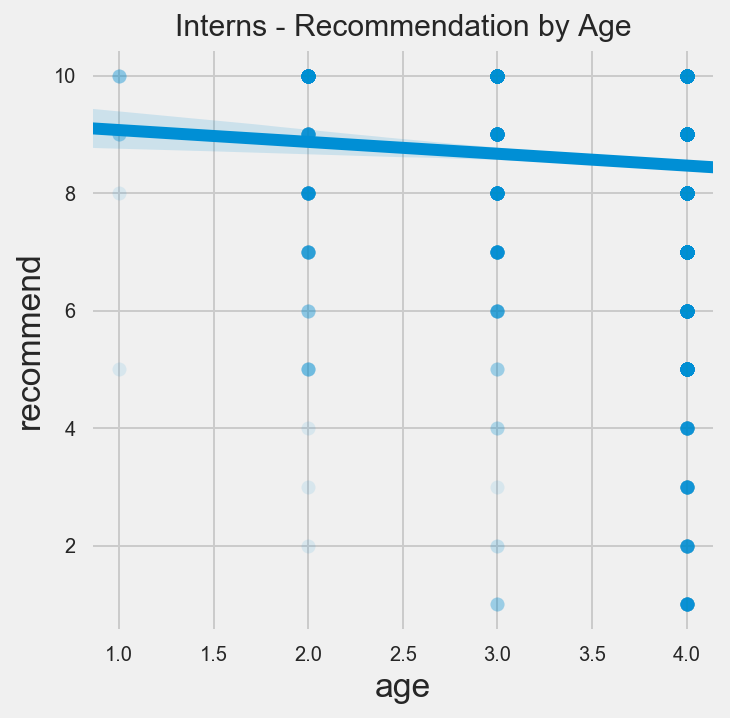

In [335]:
# Age is significant with negative correlation

# Regression plot vs. age
fig=plt.figure(figsize=(5,5))
plt.title('Interns - Recommendation by Age',fontsize=15)
ax2= sns.regplot(data= interns,x='age',y='recommend',scatter_kws={'alpha':0.1})

In [312]:
# Education level
regr2(interns,'educ_lev').summary()

X shape: (2467, 1)
y shape: (2467,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     13.84
Date:                Mon, 04 Sep 2017   Prob (F-statistic):           0.000203
Time:                        13:25:15   Log-Likelihood:                -5067.0
No. Observations:                2467   AIC:                         1.014e+04
Df Residuals:                    2465   BIC:                         1.015e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9958      0.132     67.979      0.000       8.736       9.255
educ_lev      -0.1722      0.046     -3.721      0.000      -0.263      -0.081
==============================================================================
Omnibus:                      796.997   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2228.157
Skew:                          -1.706   Prob(JB):                         0.00
Kurtosis:                       6.167   Cond. No.                         11.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

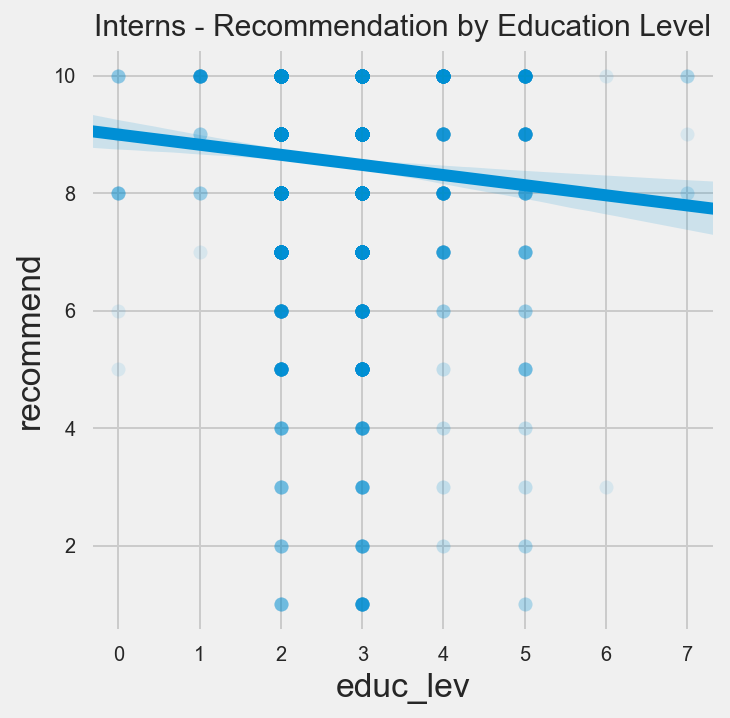

In [336]:
# Education level is also significant with negative correlation

# Regression plot vs. education level
fig=plt.figure(figsize=(5,5))
plt.title('Interns - Recommendation by Education Level',fontsize=15)
ax2= sns.regplot(data= interns,x='educ_lev',y='recommend',scatter_kws={'alpha':0.1})

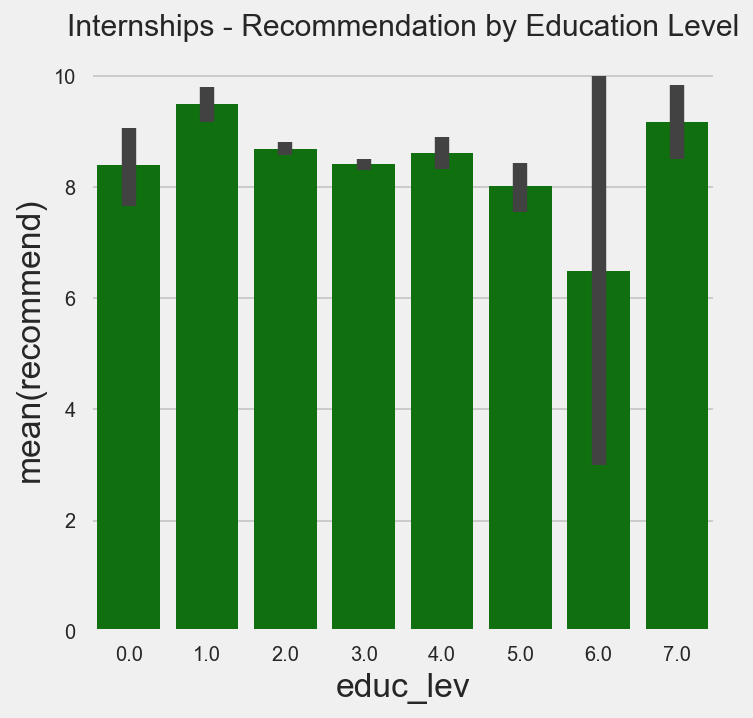

In [337]:
# Bar plot vs. education level
fig=plt.figure(figsize=(5,5))
plt.title('Internships - Recommendation by Education Level',fontsize=15)
ax2= sns.barplot(data= interns,x='educ_lev',y='recommend',color='green')


In [325]:
# Gender
regr2(interns,'gender').summary()

X shape: (2473, 3)
y shape: (2473,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.608
Date:                Mon, 04 Sep 2017   Prob (F-statistic):             0.0101
Time:                        13:54:16   Log-Likelihood:                -5080.2
No. Observations:                2473   AIC:                         1.017e+04
Df Residuals:                    2470   BIC:                         1.018e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.1667      0.445     18.344      0.000       7.294       9.040
gender_Female     0.4437      0.448      0.991      0.322      -0.434       1.322
gender_Male       0.2110      0.450      0.469      0.639      -0.671       1.093
gender_nan             0          0        nan        nan           0           0
==============================================================================
Omnibus:                      812.462   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2320.817
Skew:                          -1.726   Prob(JB):                         0.00
Kurtosis:                       6.257   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

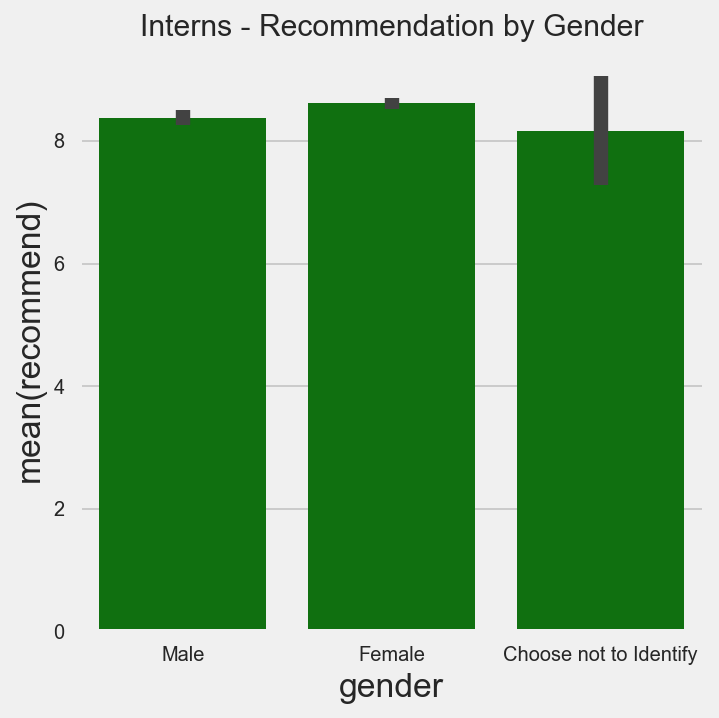

In [338]:
# Gender is not significant at 95% level
# Bar plot vs. gender
fig=plt.figure(figsize=(5,5))
plt.title('Interns - Recommendation by Gender',fontsize=15)
ax2= sns.barplot(data= interns,x='gender',y='recommend',color='green')


In [326]:
# Ethnicity
regr2(interns,'ethnicity_code').summary()

X shape: (2474, 6)
y shape: (2474,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     7.375
Date:                Mon, 04 Sep 2017   Prob (F-statistic):           7.12e-07
Time:                        13:55:24   Log-Likelihood:                -5068.1
No. Observations:                2474   AIC:                         1.015e+04
Df Residuals:                    2468   BIC:                         1.018e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.8868      0.183     48.690      0.000       8.529       9.245
ethnicity_code_B       0.0642      0.261      0.246      0.805      -0.447       0.575
ethnicity_code_H       0.1777      0.223      0.798      0.425      -0.259       0.614
ethnicity_code_I       0.0740      0.320      0.231      0.817      -0.554       0.702
ethnicity_code_U      -0.4970      0.231     -2.153      0.031      -0.950      -0.044
ethnicity_code_W      -0.4711      0.188     -2.509      0.012      -0.839      -0.103
ethnicity_code_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      807.840   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2301.256
Skew:                          -1.716   Prob(JB):                         0.00
Kurtosis:                       6.248   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

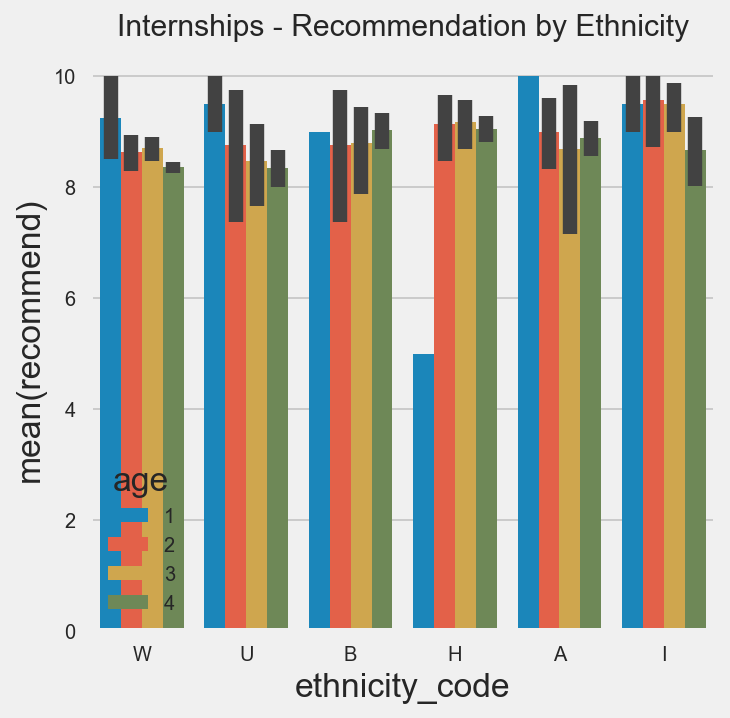

In [342]:
# Ethnicity codes W and unknown (usually multiple ethinicities or chose not to answer)
# are lower at 95% significance
# Bar plot vs. education level
fig=plt.figure(figsize=(5,5))
plt.title('Internships - Recommendation by Ethnicity',fontsize=15)
ax2= sns.barplot(data= interns,x='ethnicity_code',y='recommend', hue='age')

In [327]:
# Americorps
regr2(interns,'americorps').summary()

X shape: (2474, 2)
y shape: (2474,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.707
Date:                Mon, 04 Sep 2017   Prob (F-statistic):            0.00320
Time:                        13:57:27   Log-Likelihood:                -5082.1
No. Observations:                2474   AIC:                         1.017e+04
Df Residuals:                    2472   BIC:                         1.018e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.6853      0.066    130.664      0.000       8.555       8.816
americorps_Yes    -0.2389      0.081     -2.951      0.003      -0.398      -0.080
americorps_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      810.378   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2302.505
Skew:                          -1.723   Prob(JB):                         0.00
Kurtosis:                       6.233   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

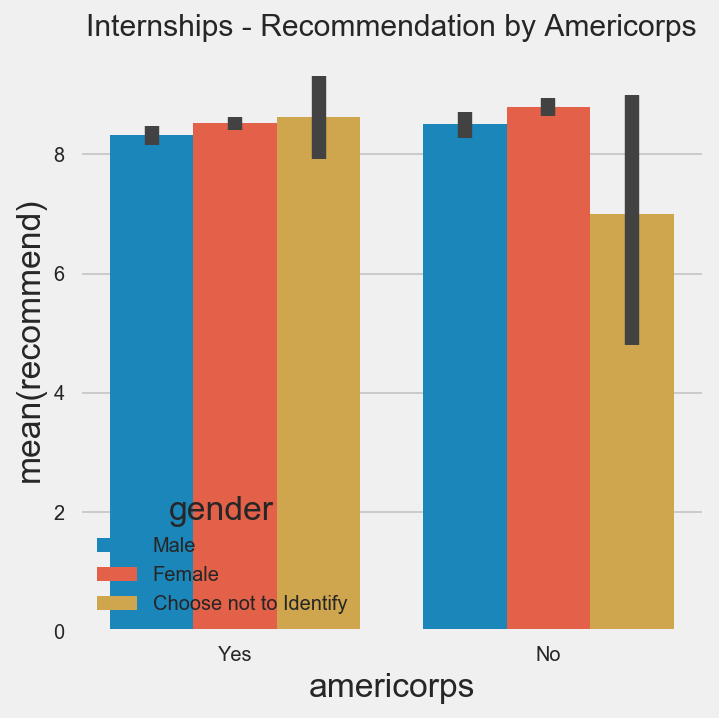

In [353]:
# Americorps = y is lower at 95% significance
fig=plt.figure(figsize=(5,5))
plt.title('Internships - Recommendation by Americorps',fontsize=15)
ax2= sns.barplot(data= interns,x='americorps',y='recommend', hue='gender')

In [328]:
# Budget code
regr2(interns,'budget_cd').summary()

X shape: (2474, 11)
y shape: (2474,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.300
Date:                Mon, 04 Sep 2017   Prob (F-statistic):           0.000291
Time:                        13:58:44   Log-Likelihood:                -5070.0
No. Observations:                2474   AIC:                         1.016e+04
Df Residuals:                    2463   BIC:                         1.023e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.6109      0.053    162.499      0.000       8.507       8.715
budget_cd_206    -0.3753      0.089     -4.223      0.000      -0.550      -0.201
budget_cd_255     0.3891      1.883      0.207      0.836      -3.304       4.082
budget_cd_257     0.1521      0.103      1.484      0.138      -0.049       0.353
budget_cd_267     0.9891      0.844      1.173      0.241      -0.665       2.643
budget_cd_268     1.3891      1.883      0.738      0.461      -2.304       5.082
budget_cd_272    -0.6109      1.088     -0.561      0.575      -2.745       1.523
budget_cd_275    -0.6109      1.088     -0.561      0.575      -2.745       1.523
budget_cd_310    -0.4509      0.380     -1.186      0.236      -1.196       0.295
budget_cd_330    -0.8462      0.460     -1.841      0.066      -1.748       0.055
budget_cd_332    -0.6109      1.883     -0.324      0.746      -4.304       3.082
budget_cd_nan          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      795.755   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2214.972
Skew:                          -1.701   Prob(JB):                         0.00
Kurtosis:                       6.149   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
# Budget code 206 has lower scores at 99% convidence, 
# budget code 330 has lower scores at 93% confidence,
# budget code 257 has higher scores at 86% confidence,

In [330]:
# Median Income in home zip code
regr2(interns,'income').summary()

X shape: (2394, 1)
y shape: (2394,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 1.905e-05
Date:                Mon, 04 Sep 2017   Prob (F-statistic):              0.997
Time:                        14:08:44   Log-Likelihood:                -4939.6
No. Observations:                2394   AIC:                             9883.
Df Residuals:                    2392   BIC:                             9895.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5059      0.097     87.590      0.000       8.315       8.696
income      6.146e-09   1.41e-06      0.004      0.997   -2.76e-06    2.77e-06
==============================================================================
Omnibus:                      776.268   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2167.017
Skew:                          -1.713   Prob(JB):                         0.00
Kurtosis:                       6.160   Cond. No.                     1.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Income not significant

In [331]:
# % receiving SNAP in home zip code
regr2(interns,'SNAP').summary()

X shape: (2403, 1)
y shape: (2403,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.752
Date:                Mon, 04 Sep 2017   Prob (F-statistic):             0.0973
Time:                        14:10:07   Log-Likelihood:                -4955.9
No. Observations:                2403   AIC:                             9916.
Df Residuals:                    2401   BIC:                             9927.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4241      0.063    133.185      0.000       8.300       8.548
SNAP           0.0075      0.005      1.659      0.097      -0.001       0.016
==============================================================================
Omnibus:                      775.698   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2153.170
Skew:                          -1.708   Prob(JB):                         0.00
Kurtosis:                       6.136   Cond. No.                         22.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# At 90% confidence, the higher the % of SNAP, the higher the recommendation scores
# Not terribly useful by itself 

In [332]:
# % below poverty line in home zip code
regr2(interns,'poverty').summary()

X shape: (2399, 1)
y shape: (2399,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.266
Date:                Mon, 04 Sep 2017   Prob (F-statistic):              0.261
Time:                        14:12:04   Log-Likelihood:                -4949.5
No. Observations:                2399   AIC:                             9903.
Df Residuals:                    2397   BIC:                             9914.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4516      0.062    137.422      0.000       8.331       8.572
poverty        0.0054      0.005      1.125      0.261      -0.004       0.015
==============================================================================
Omnibus:                      775.914   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2157.595
Skew:                          -1.711   Prob(JB):                         0.00
Kurtosis:                       6.143   Cond. No.                         20.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# % below poverty line in home zip code not significant

In [333]:
# Number of weeks
regr2(interns,'weeks').summary()

X shape: (2474, 1)
y shape: (2474,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     27.95
Date:                Mon, 04 Sep 2017   Prob (F-statistic):           1.35e-07
Time:                        14:15:55   Log-Likelihood:                -5072.5
No. Observations:                2474   AIC:                         1.015e+04
Df Residuals:                    2472   BIC:                         1.016e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8339      0.070    126.710      0.000       8.697       8.971
weeks         -0.0156      0.003     -5.287      0.000      -0.021      -0.010
==============================================================================
Omnibus:                      806.151   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2285.768
Skew:                          -1.715   Prob(JB):                         0.00
Kurtosis:                       6.227   Cond. No.                         43.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56]), <a list of 57 Text xticklabel objects>)

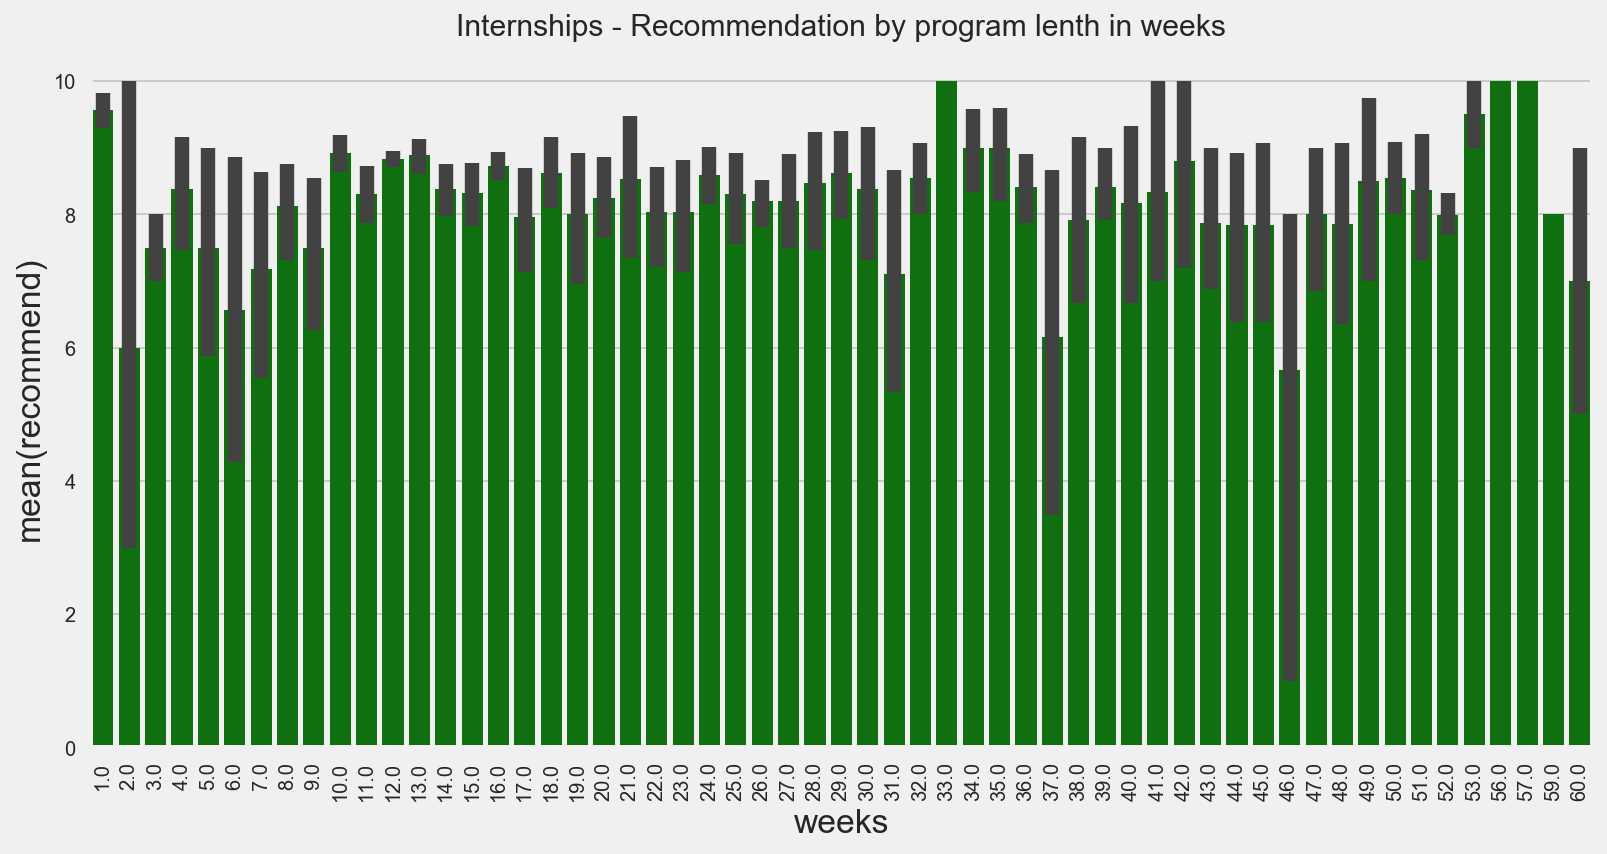

In [349]:
# Number of weeks has negative correlation. 
# Bar plot vs. # of weeks
fig=plt.figure(figsize=(12,6))
plt.title('Internships - Recommendation by program lenth in weeks',fontsize=15)
ax2= sns.barplot(data= interns,x='weeks',y='recommend',color='green')
plt.xticks(rotation='vertical')

In [314]:
interns.columns


Index([u'americorps', u'budget_cd', u'q18', u'q19', u'q20', u'q22', u'q24',
       u'q26a', u'q26b', u'q26c', u'q26d', u'q36', u'q48a', u'q48b', u'q48c',
       u'q48d', u'q48e', u'q48f', u'q50', u'q97a', u'q97b', u'q97c', u'q97d',
       u'q97e', u'q97f', u'q98a', u'q98b', u'q98c', u'q98d', u'q98e', u'q98f',
       u'q98g', u'q98h', u'q99a', u'q99b', u'q99c', u'q100', u'recommend',
       u'pos_tit', u'org_mng', u'loc_city', u'op_stat', u'weeks', u'mem_city',
       u'mem_st', u'vet', u'ethnicity_code', u'educ_lev', u'age', u'gender',
       u'loc_st', u'start_dt', u'end_dt', u'employed', u'SNAP', u'health_ins',
       u'poverty', u'income'],
      dtype='object')

In [315]:
interns.isnull().sum()

americorps          0
budget_cd           0
q18                25
q19               511
q20               511
q22                 6
q24                19
q26a                7
q26b               14
q26c                8
q26d                6
q36                 7
q48a               12
q48b               16
q48c               14
q48d               14
q48e               21
q48f               22
q50                29
q97a               14
q97b               15
q97c               15
q97d               16
q97e               21
q97f               19
q98a               13
q98b               16
q98c               18
q98d               16
q98e               14
q98f               17
q98g               15
q98h               22
q99a               11
q99b               19
q99c               12
q100                1
recommend           0
pos_tit             0
org_mng             0
loc_city           23
op_stat             0
weeks               0
mem_city           22
mem_st              0
vet       

In [316]:
interns.americorps.value_counts()

Yes    1667
No      807
Name: americorps, dtype: int64

In [533]:
interns[(interns.mem_st=='SC')].recommend.count()


6